In [1041]:
#CONDA ENV pytorch1 (python 3.9.7)
#Import packages
#---------------------------------------
import sys
import os
import glob
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from multiprocessing import Pool
import process_functions as pf
import pyBigWig as bw
import torch
from enformer_pytorch import Enformer, GenomeIntervalDataset
import polars as pl


#Import your modules
#---------------------------------------
sys.path.insert(1, '/cndd3/dburrows/CODE/admin_tools/')
from admin_tools import admin_functions as adm

# Define paths
#----------------------------------------------------------------------
l_code = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
l_data = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
l_fig = '/Users/dominicburrows/Dropbox/PhD/figures/'

s_code = '/cndd3/dburrows/CODE/'
s_data = '/cndd3/dburrows/DATA/'
s_fig = '/cndd3/dburrows/FIGS/'

%load_ext autoreload
print(f'Python version {sys.version}')
print(f'Python path {sys.executable}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python version 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:11) 
[GCC 9.4.0]
Python path /home/dburrows/mambaforge/envs/pytorch1/bin/python


# Pseudobulk mc

In [28]:
#mc
#==============
import ALLCools as ac
path = '/cndd/Public_Datasets/BICCN/BICCN_minibrain_data/data_freeze/snmc_and_snatac/dataset/mc/'
mc_df = pd.read_csv('/cndd/Public_Datasets/BICCN/BICCN_minibrain_data/data_freeze/snmc_and_snatac/study/mc/MOp.snmC-seq.AnalysisResult.csv.gz')
mc_df

,index,FullCellID,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,...,Slice,PassFilter,pca_0,pca_1,umap_0,umap_1,tsne_0,tsne_1,MajorCluster,SubCluster
0,2C_M_0,180508_CEMBA_mm_P56_P63_2C_CEMBA180409_2C_1_CE...,0.00511,0.77073,0.76955,0.02154,0.01651,1076259.0,2314862,1517338.0,...,2,True,-11.588627,-0.005045,10.051389,7.099836,-3.343437,18.330174,L4-IT-Rorb,L4-IT-Rorb_Rorb-Tenm2
1,2C_M_1,180508_CEMBA_mm_P56_P63_2C_CEMBA180409_2C_1_CE...,0.00531,0.75683,0.75553,0.02196,0.01674,1197092.0,2590626,1709334.0,...,2,True,-19.267288,-7.374098,13.717241,-1.786627,9.212860,-26.514785,L23-IT-Cux2,L23-IT-Cux2
2,2C_M_10,180508_CEMBA_mm_P56_P63_2C_CEMBA180409_2C_1_CE...,0.00581,0.75720,0.75578,0.02603,0.02034,1006630.0,2348484,1606410.0,...,2,True,-15.340144,-2.739380,4.829485,9.943986,-22.960995,13.509483,Outlier,Outlier
3,2C_M_100,180508_CEMBA_mm_P56_P63_2C_CEMBA180409_2C_1_CE...,0.00634,0.74984,0.74824,0.02718,0.02097,2026078.0,4599922,3154619.0,...,2,True,-23.625140,-5.929033,13.739521,1.107174,12.798545,-17.126331,L23-IT-Cux2,L23-IT-Cux2
4,2C_M_1000,180508_CEMBA_mm_P56_P63_2C_CEMBA180409_2C_3_CE...,0.00521,0.77073,0.76953,0.02117,0.01604,2368464.0,5320502,3648786.0,...,2,True,-21.815190,-7.130878,14.154541,-2.284118,8.443658,-27.943267,L23-IT-Cux2,L23-IT-Cux2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9871,5D_M_995,180627_CEMBA_mm_P56_P63_5D_CEMBA180605_5D_3_CE...,0.00605,0.80138,0.80017,0.03183,0.02594,800968.0,1767844,1190789.0,...,5,True,-17.305504,0.541289,8.149108,-9.383527,-11.125630,-41.527185,L5-PT-Bcl6,L5-PT-Bcl6
9872,5D_M_996,180627_CEMBA_mm_P56_P63_5D_CEMBA180605_5D_3_CE...,0.00476,0.80081,0.79986,0.02246,0.01778,718290.0,1594474,1064644.0,...,5,True,-11.722283,0.316892,6.512970,6.129021,-10.677095,27.946736,L4-IT-Rorb,L4-IT-Rorb_Rorb-Tenm2
9873,5D_M_997,180627_CEMBA_mm_P56_P63_5D_CEMBA180605_5D_3_CE...,0.00478,0.79146,0.79046,0.02040,0.01570,625473.0,1365894,928844.0,...,5,True,-9.762206,2.836793,6.878475,5.774989,-10.110227,28.544857,L4-IT-Rorb,L4-IT-Rorb_Rorb-Tenm2
9874,5D_M_998,180627_CEMBA_mm_P56_P63_5D_CEMBA180605_5D_3_CE...,0.00571,0.82569,0.82469,0.03079,0.02522,1536923.0,3652902,2506658.0,...,5,True,21.098362,30.776524,23.757244,-7.893738,21.858532,9.493263,L6-CT-Foxp2,L6-CT-Foxp2_Foxp2-Glra2


/tmp/ipykernel_804580/1272176048.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prac['cluster']=store


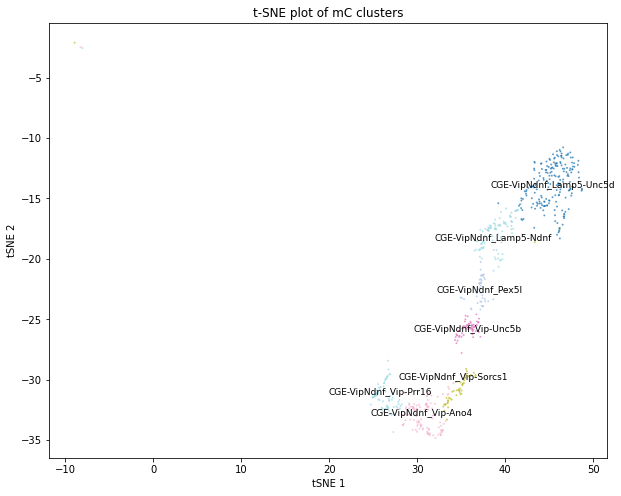

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming atac_df is already loaded as shown in your snippet
prac = mc_df[mc_df['MajorCluster'] == 'CGE-VipNdnf']
lab_v = mc_df['SubCluster'].unique()
store=[]
for p in prac['SubCluster']:
    ind = np.where(p==lab_v)[0][0]
    store.append(ind)
prac['cluster']=store

# Plot the scatter plot
plt.figure(figsize=(10, 8))  # Optional: Adjust figure size as needed
scatter = plt.scatter(prac['tsne_0'], prac['tsne_1'], s=1, cmap='tab20', c=prac['cluster'], alpha=0.6)

# Calculate centroids and label each cluster
for cluster in prac['cluster'].unique():
    cluster_data = prac[prac['cluster'] == cluster]
    centroid = [cluster_data['tsne_0'].mean(), cluster_data['tsne_1'].mean()]
    # Retrieve the first MajorCluster name associated with this cluster for labeling
    cluster_label = cluster_data['SubCluster'].iloc[0]
    plt.text(centroid[0], centroid[1], cluster_label, fontsize=9, ha='center', va='center')

plt.xlabel('tSNE 1')  # Adjust label as necessary
plt.ylabel('tSNE 2')  # Adjust label as necessary
plt.title('t-SNE plot of mC clusters')  # Optional: Adjust title as necessary
plt.show()


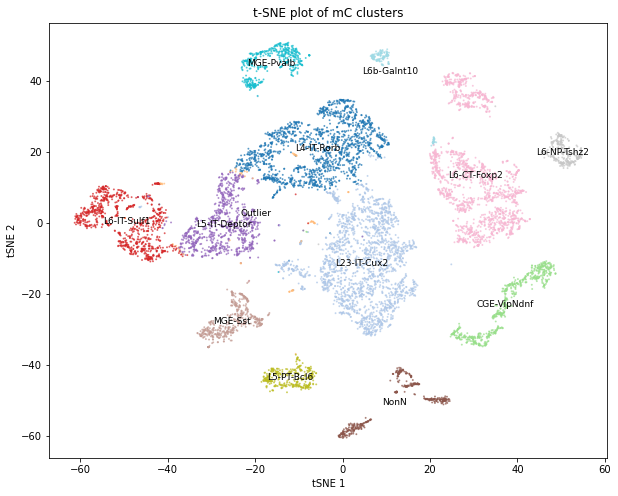

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming atac_df is already loaded as shown in your snippet
prac = mc_df
lab_v = mc_df['MajorCluster'].unique()
store=[]
for p in prac['MajorCluster']:
    ind = np.where(p==lab_v)[0][0]
    store.append(ind)
prac['cluster']=store

# Plot the scatter plot
plt.figure(figsize=(10, 8))  # Optional: Adjust figure size as needed
scatter = plt.scatter(prac['tsne_0'], prac['tsne_1'], s=1, cmap='tab20', c=prac['cluster'], alpha=0.6)

# Calculate centroids and label each cluster
for cluster in prac['cluster'].unique():
    cluster_data = prac[prac['cluster'] == cluster]
    centroid = [cluster_data['tsne_0'].mean(), cluster_data['tsne_1'].mean()]
    # Retrieve the first MajorCluster name associated with this cluster for labeling
    cluster_label = cluster_data['MajorCluster'].iloc[0]
    plt.text(centroid[0], centroid[1], cluster_label, fontsize=9, ha='center', va='center')

plt.xlabel('tSNE 1')  # Adjust label as necessary
plt.ylabel('tSNE 2')  # Adjust label as necessary
plt.title('t-SNE plot of mC clusters')  # Optional: Adjust title as necessary
plt.show()

In [14]:
#Split IDs into GLU and GABA
prac = np.unique(mc_df['MajorCluster'])
prac

array(['CGE-VipNdnf', 'L23-IT-Cux2', 'L4-IT-Rorb', 'L5-IT-Deptor',
       'L5-PT-Bcl6', 'L6-CT-Foxp2', 'L6-IT-Sulf1', 'L6-NP-Tshz2',
       'L6b-Galnt10', 'MGE-Pvalb', 'MGE-Sst', 'NonN', 'Outlier'],
      dtype=object)

In [20]:
mc_df['MajorCluster']

0        L4-IT-Rorb
1       L23-IT-Cux2
2           Outlier
3       L23-IT-Cux2
4       L23-IT-Cux2
           ...     
9871     L5-PT-Bcl6
9872     L4-IT-Rorb
9873     L4-IT-Rorb
9874    L6-CT-Foxp2
9875    L6-CT-Foxp2
Name: MajorCluster, Length: 9876, dtype: object

In [27]:
out = []
for p in mc_df['MajorCluster'].values:
    if 'GE' in p: out.append('GABA')
    elif 'L' in p: out.append('GLU')
    else: out.append('NA')
mc_df['ParentCluster'] = out

In [161]:
#symlink allc data 
arry = glob.glob('/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/mcds/**')
for a in arry:
    pref= os.path.basename(a)[:2]
    suf=os.path.basename(a).split('.')[0][3:]
    stri=f'/cndd3/Public_Datasets/CEMBA_cndd3/snmCSeq/Datasets/CEMBA_{pref}_{suf}'
    ! ln -s {stri} /cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/


In [171]:
#symlink allc data - separate in GLU + GABA
glu_n = mc_df[mc_df['ParentCluster']=='GLU']['FullCellID'].values
gaba_n = mc_df[mc_df['ParentCluster']=='GABA']['FullCellID'].values

arry = glob.glob('/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/**')
for a in arry:
    for x in glob.glob(a+'/allc/'+'*bgz'):
        base = x.split('_indexed')[0].split('allc_')[-1]

        if base in gaba_n: 
            ! ln -s {x} /cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GABA/
            ! ln -s {x+'.tbi'} /cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GABA/
        if base in glu_n:
            ! ln -s {x} /cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GLU/
            ! ln -s {x+'.tbi'} /cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GLU/

In [172]:
#check that names are all there
os.chdir('/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GLU')
glu_move = [i.split('_indexed')[0].split('allc_')[-1] for i in glob.glob('*bgz')]
os.chdir('/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GABA')
gaba_move = [i.split('_indexed')[0].split('allc_')[-1] for i in glob.glob('*bgz')]
assert sum(np.in1d(gaba_move, gaba_n) !=True) == 0,'some incorrect files have been moved into GABA'
assert sum(np.in1d(glu_move, glu_n) !=True) == 0,'some incorrect files have been moved into GLU'

In [189]:
%%bash
#move file psths into txt file for allcools
find -L /cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GLU/ -type f -name "*bgz" > /cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GLU/list.txt


In [177]:
%%bash
outpath=/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/pseudobulk/coarse/
inpath=/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/
code_path=/cndd3/dburrows/CODE/deepNN_splice/allcools_merge.sh
# chmod u+x $code_path
# scp $code_path $outpath/log.workspace

cell_arr=("GLU" "GABA")
for c in ${cell_arr[@]}
do
    echo $c
    echo $inpath$c/*.bqz
    
    #$code_path $inpath$c/*.bqz $outpath/$c/
    
done
echo Done


GLU
/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GLU/*.bqz
GABA
/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GABA/*.bqz
Done


In [179]:
#!/bin/bash
# merge with allcools

outpath=/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/pseudobulk/coarse/
inpath=/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/
code_path=/cndd3/dburrows/CODE/deepNN_splice/workspace.py
chmod u+x $code_path
scp $code_path $outpath/log.workspace

cell_arr=("GLU" "GABA")
for c in "${cell_arr[@]}"
do
    echo $c
    for num in 1 2
    do
        echo Doing $num
        allcools merge-allc \
            --cpu 30 \
            --allc_paths $inpath$c/list$num.txt \
            --output_path $outpath/$c/$num/ \
            --chrom_size_path /cndd3/dburrows/DATA/annotations/genome/grcm38.p3/modified_mm10.chrom.sizes
        echo Done $num
    done
done
echo Done


GLU
/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GLU/*.bqz
GABA
/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GABA/*.bqz
Done


In [145]:
#Check that chromosome lengths are the same -> ensure same reference was used in RNA mapping
ref = pd.read_csv('/cndd3/dburrows/DATA/annotations/genome/grcm38.p3/modified_mm10.chrom.sizes', sep='\t', header=None, index_col=0)[:21]
ref.drop(axis=0, index ='Y', inplace=True)

path = '/cndd/emukamel/enformer/CEMBA_MOp_mc_bigwigs/bigwig'
bw_l = glob.glob(f'{path}/*CG*')
for x,b in enumerate(bw_l):
    curr = bw.open(b)
    for r in ref.index.values:
        if curr.chroms()[r] != ref.loc[r].values[0]: 
            print(f'{b} with {r}')
    if len(curr.chroms()) != len(ref) | sum(np.in1d(ref.index.values, list(curr.chroms().keys()))) != len(ref):
        print(b)

In [8]:
#Visualise mc tracks -> load bigwig files 
path = '/cndd/emukamel/enformer/CEMBA_MOp_mc_bigwigs/bigwig'
cg_l = glob.glob(f'{path}/*C5_1*CG.bw')
ch_l = glob.glob(f'{path}/*C5_1*CAC.bw')
cg_l, ch_l

(['/cndd/emukamel/enformer/CEMBA_MOp_mc_bigwigs/bigwig/C5_1_Pvalb_Reln_CG.bw'],
 ['/cndd/emukamel/enformer/CEMBA_MOp_mc_bigwigs/bigwig/C5_1_Pvalb_Reln_CAC.bw'])

In [13]:
head -5 gencode.vM3.chr_patch_hapl_scaff.annotation.gtf > prac && cat gencode.vM3.chr_1-19-X.annotation.gtf >> prac


{'1': 195471971,
 '2': 182113224,
 '3': 160039680,
 '4': 156508116,
 '5': 151834684,
 '6': 149736546,
 '7': 145441459,
 '8': 129401213,
 '9': 124595110,
 '10': 130694993,
 '11': 122082543,
 '12': 120129022,
 '13': 120421639,
 '14': 124902244,
 '15': 104043685,
 '16': 98207768,
 '17': 94987271,
 '18': 90702639,
 '19': 61431566,
 'X': 171031299}

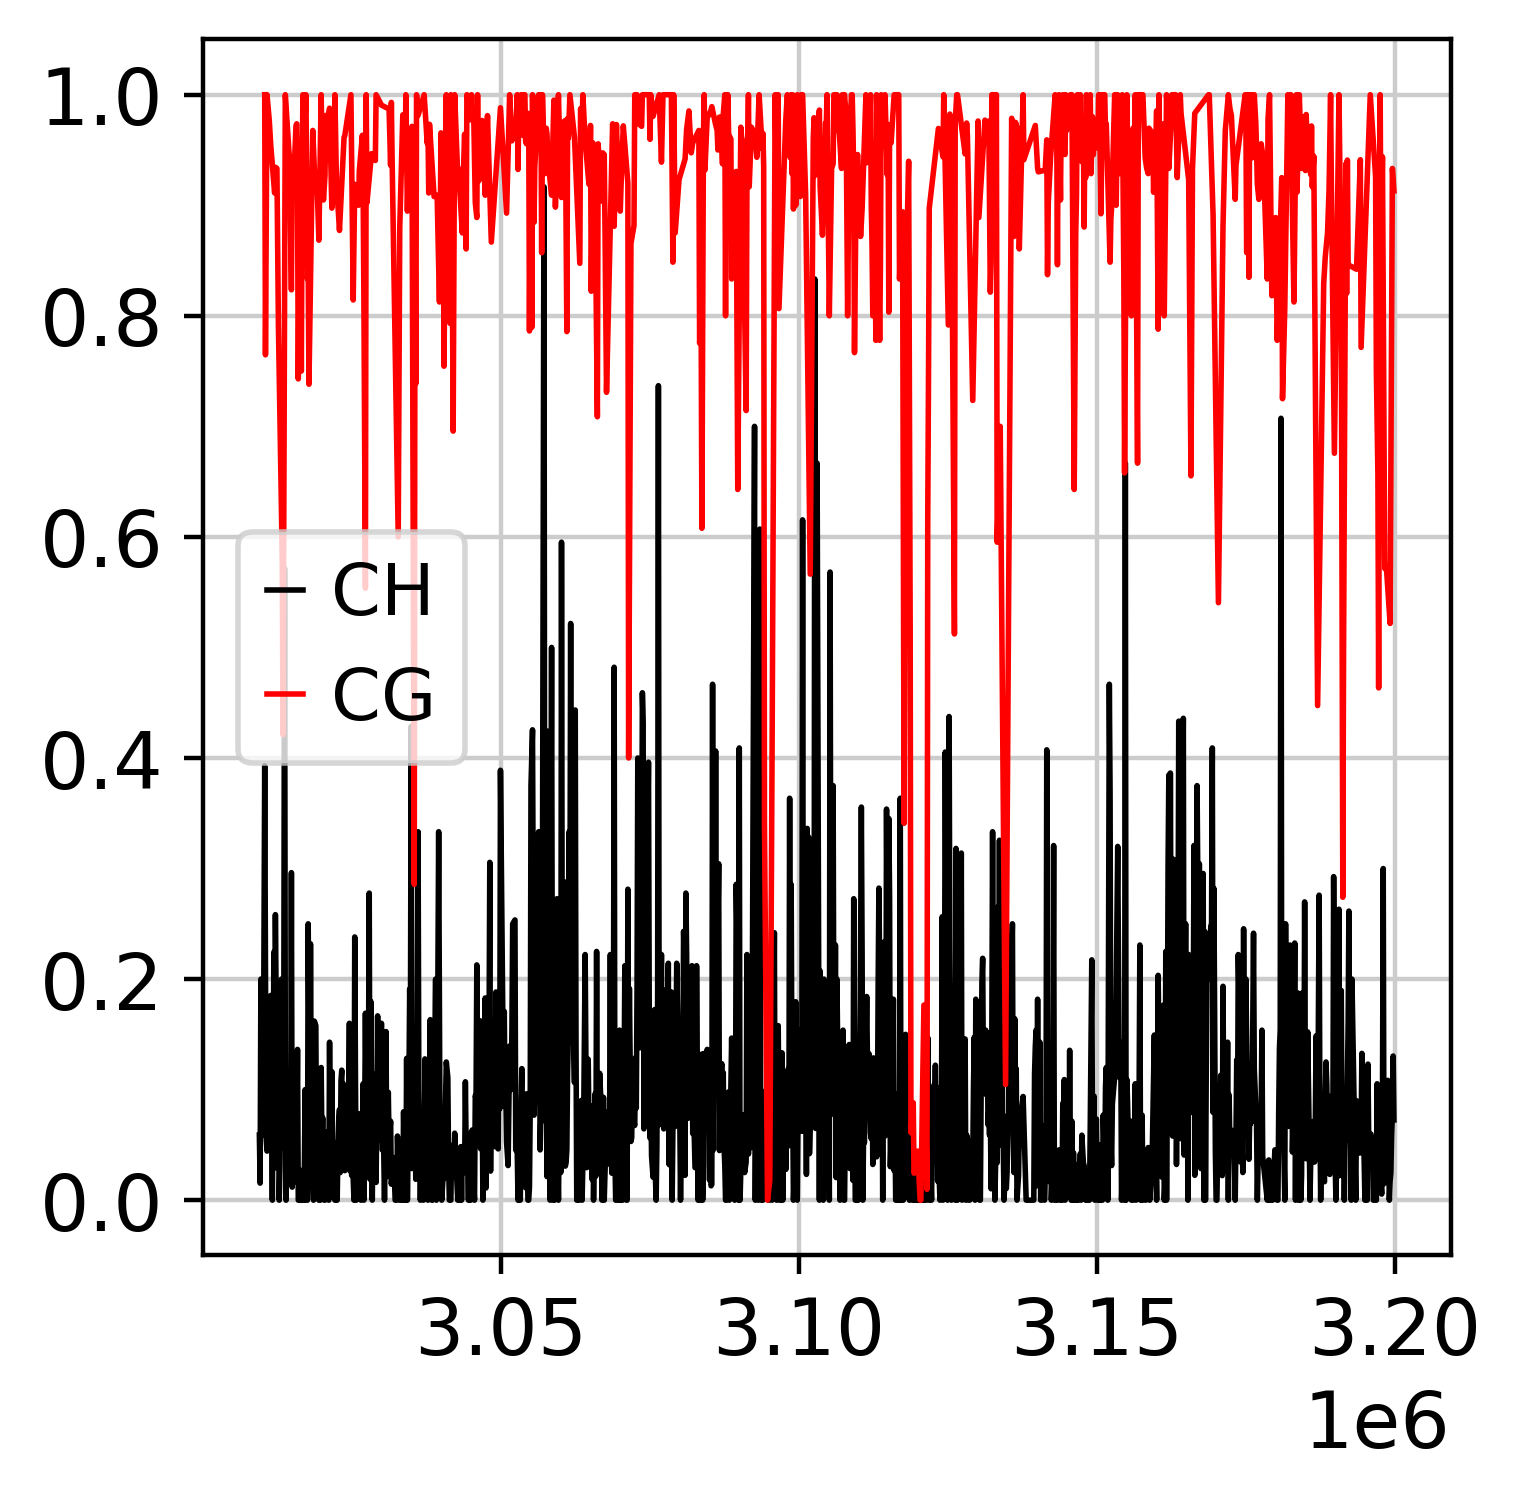

In [500]:
# Plot CH and CG methylation
cg = bw.open(cg_l[0])
ch = bw.open(ch_l[0])
prac_cg = np.asarray(cg.intervals('1', 3009600, 3200000))
prac_ch = np.asarray(ch.intervals('1', 3009600, 3200000))

plt.plot(prac_ch[:,0], prac_ch[:,2], linewidth=1, c='k', label='CH')
plt.plot(prac_cg[:,0], prac_cg[:,2], linewidth=1, c='red', label='CG')
plt.legend()
plt.show()

In [466]:
# confirm mean methylation across celltypes -> check values
#Visualise mc tracks -> load bigwig files 
cg_r, ch_r = [],[]
import pyBigWig as bw
path = '/cndd/emukamel/enformer/CEMBA_MOp_mc_bigwigs/bigwig'
cg_l = glob.glob(f'{path}/*CG.bw')
ch_l = glob.glob(f'{path}/*CAC.bw')
ch_l = [i for i in ch_l if 'C10_1_Sst' not in i]
for x in range(len(cg_l)):
    _cg = bw.open(cg_l[x])
    if x<len(cg_l)-1:
        _ch = bw.open(ch_l[x])
    
    cg_r.append(_cg.header()['sumData']/_cg.header()['nBasesCovered'])
    ch_r.append(_ch.header()['sumData']/_ch.header()['nBasesCovered'])

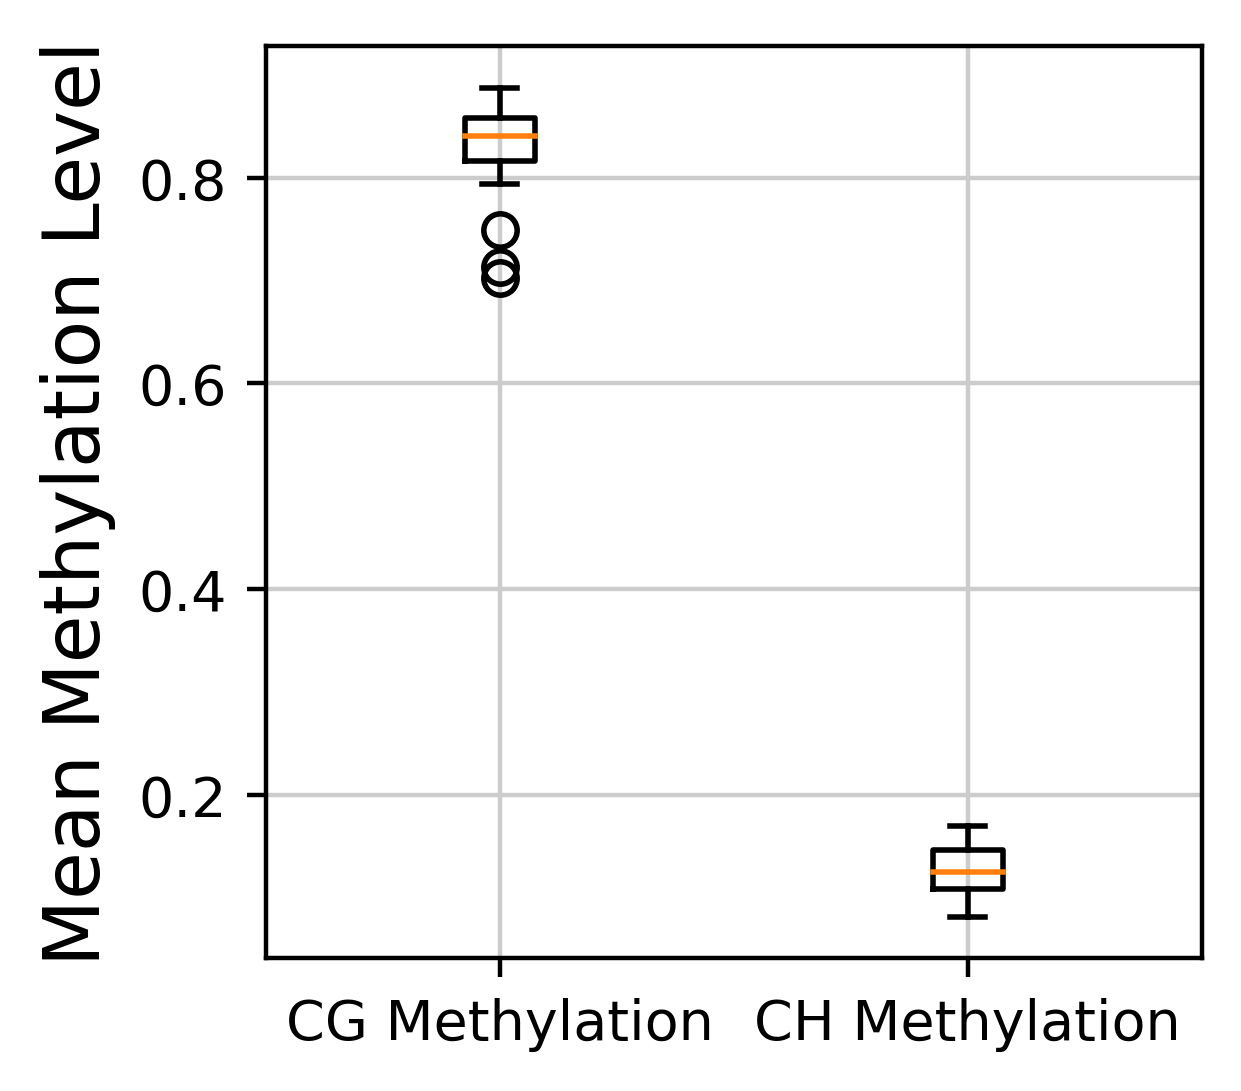

In [483]:
import matplotlib.pyplot as plt
# Assuming cg_r and ch_r are populated with the mean methylation levels as per your code
# cg_r, ch_r = [],[] # Example lists; replace with your actual data

# Data preparation for box plot
data = [cg_r, ch_r]
labels = ['CG Methylation', 'CH Methylation']

# Create a box plot
plt.figure(figsize=(3, 3))  # Set the figure size
plt.boxplot(data, labels=labels)

# Adding labels and title
plt.ylabel('Mean Methylation Level')
plt.tick_params(axis='x', labelsize=10) # Show the plot
plt.tick_params(axis='y', labelsize=10) 
plt.show()


In [531]:
#confirm methylation bin coverage decreases with chromosome
#Visualise mc tracks -> load bigwig files 
chr_list = list(_cg.chroms().keys())
donor_l, chr_l, bin_n = [],[],[]
import pyBigWig as bw
path = '/cndd/emukamel/enformer/CEMBA_MOp_mc_bigwigs/bigwig'
cg_l = glob.glob(f'{path}/*CG.bw')
ch_l = glob.glob(f'{path}/*CAC.bw')
ch_l = [i for i in ch_l if 'C10_1_Sst' not in i]
for x in range(len(cg_l)):
    _cg = bw.open(cg_l[x])
    if x<len(cg_l)-1:
        _ch = bw.open(ch_l[x])
    for ch in chr_list:
        donor_l.append(os.path.basename(cg_l[x]))
        chr_l.append(ch)
        bin_n.append(len(_cg.intervals(ch)))
        if x<len(cg_l)-1:
            donor_l.append(os.path.basename(ch_l[x]))
            chr_l.append(ch)
            bin_n.append(len(_ch.intervals(ch)))

df = {'Donor':donor_l, 'Chr': chr_l, 'Nbins': bin_n} 
df = pd.DataFrame(df)

#split into cg and ch
meth_l=[]
for d in range(len(df)):
    if 'CG' in df['Donor'][d]: meth_l.append('CG')
    if 'CAC' in df['Donor'][d]: meth_l.append('CAC')
df['meth']= meth_l

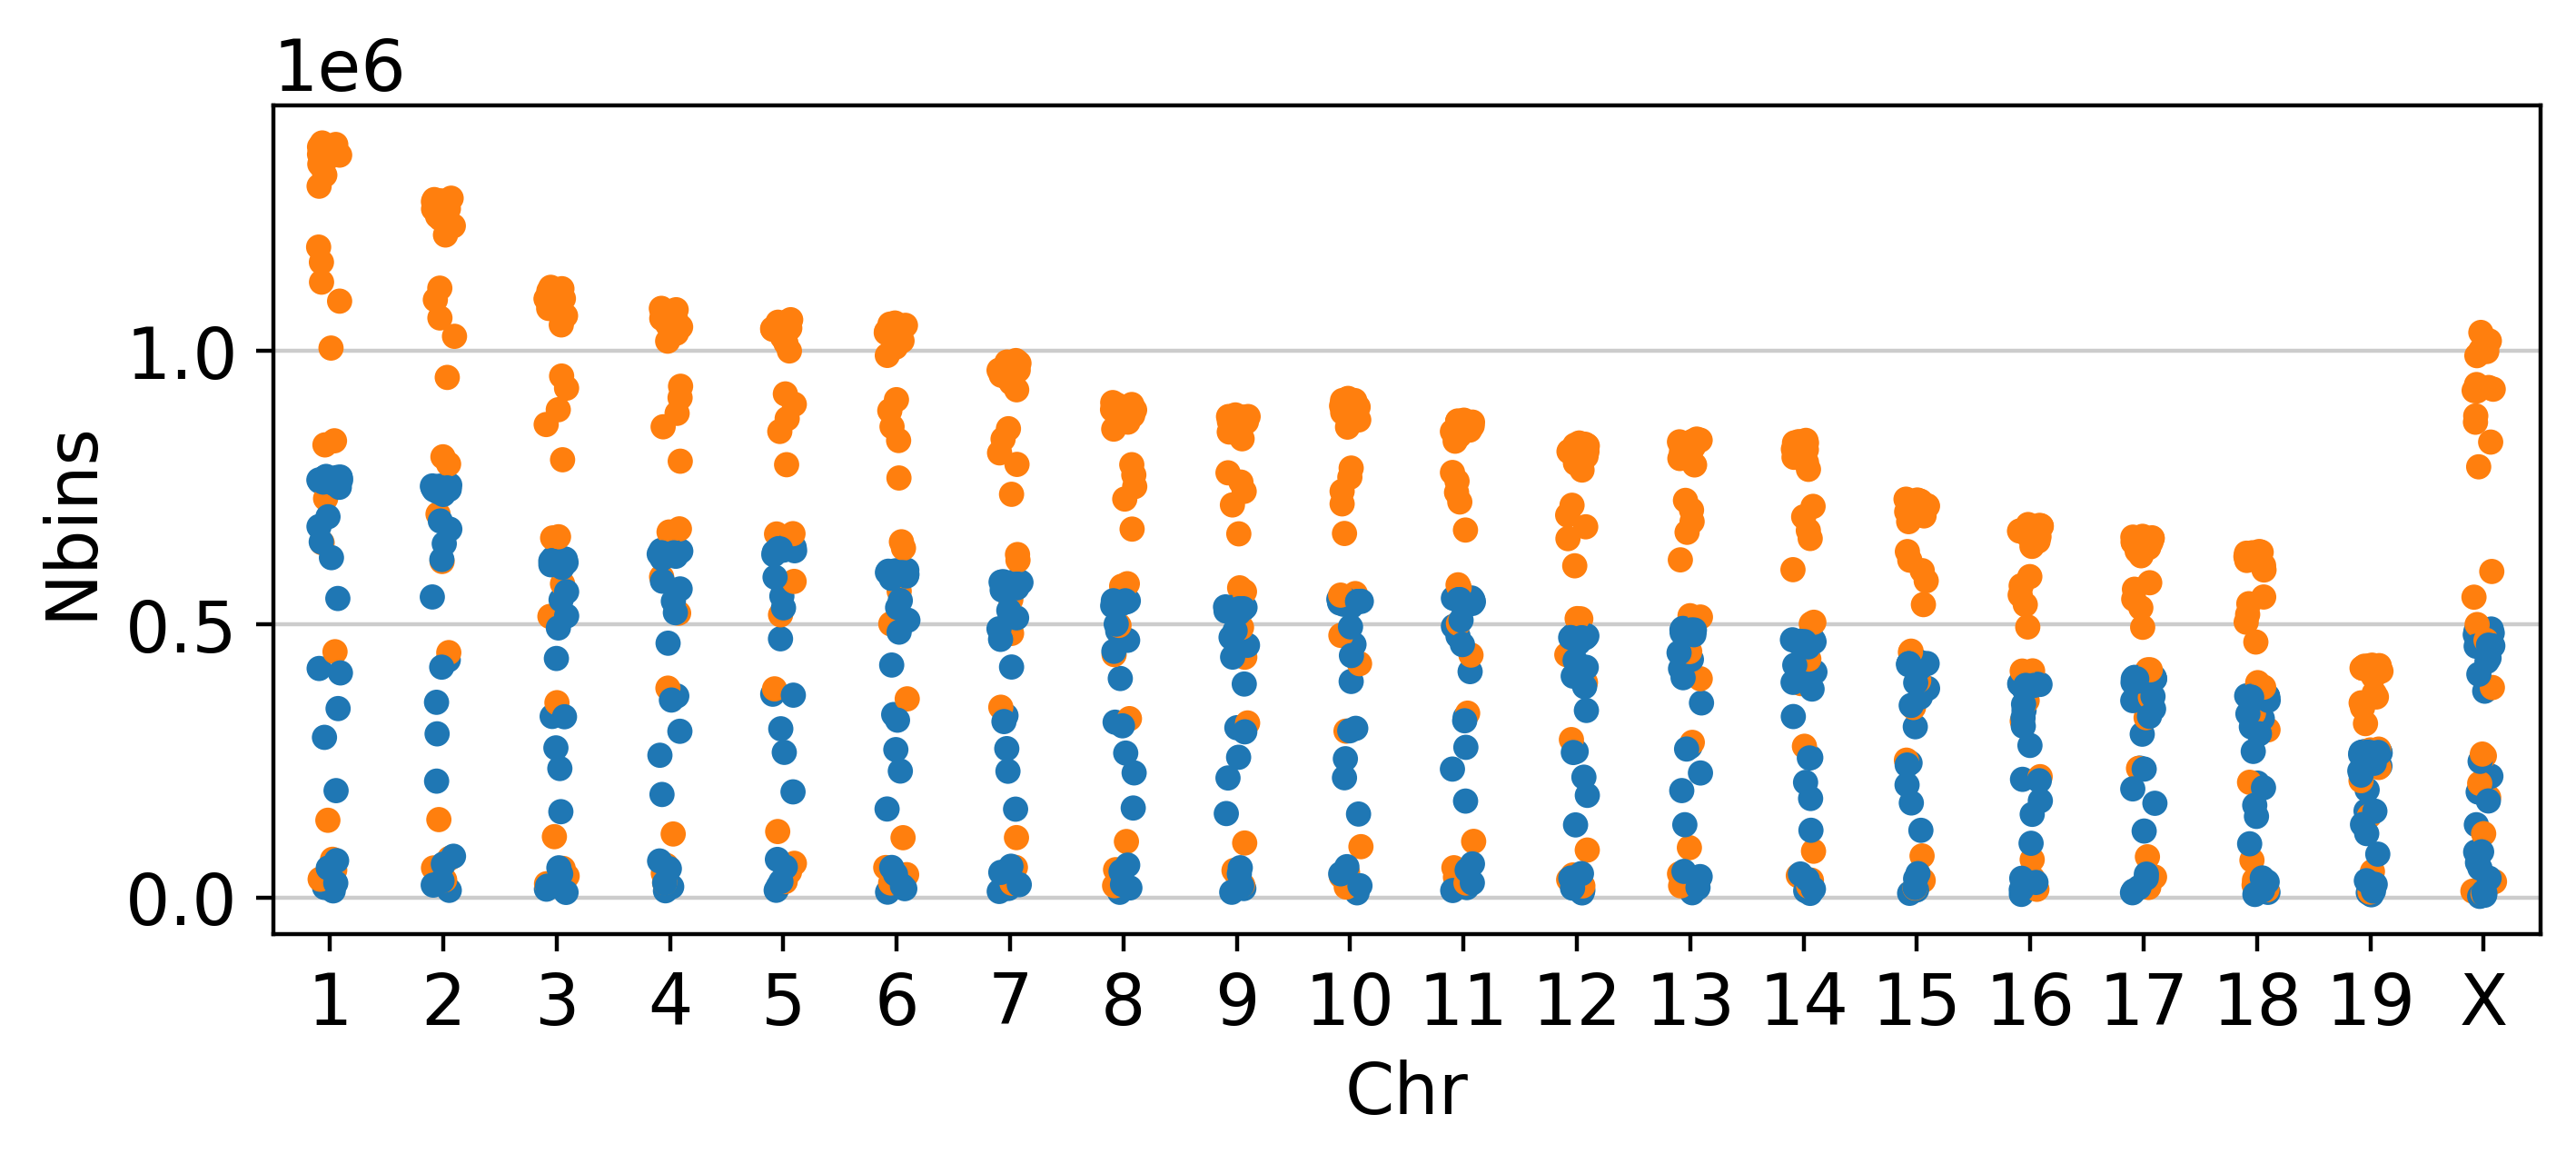

In [540]:
import seaborn as sns
fig,ax = plt.subplots(figsize=(8,3))
g = sns.stripplot(data=df, x='Chr', y='Nbins', hue='meth')
g.legend().remove()
plt.show()

In [603]:
#confirm upper bound of bins correlates with max chromosome length, but never exceeds it
ref = pd.read_csv('/cndd3/dburrows/DATA/annotations/genome/grcm38.p3/modified_mm10.chrom.sizes', sep='\t', index_col=0, header=None)
chr_list = list(_cg.chroms().keys())
donor_l, upper_l, true_l, chr_l = [],[],[],[]
import pyBigWig as bw
path = '/cndd/emukamel/enformer/CEMBA_MOp_mc_bigwigs/bigwig'
cg_l = glob.glob(f'{path}/*CG.bw')
ch_l = glob.glob(f'{path}/*CAC.bw')
ch_l = [i for i in ch_l if 'C10_1_Sst' not in i]
for x in range(len(cg_l)):
    _cg = bw.open(cg_l[x])
    if x<len(cg_l)-1:
        _ch = bw.open(ch_l[x])
    for ch in chr_list:
        donor_l.append(os.path.basename(cg_l[x]))
        true_l.append(ref.loc[ch].values[0])
        chr_l.append(ch)
        upper_l.append(_cg.intervals(ch)[-1][1])
        if x<len(cg_l)-1:
            donor_l.append(os.path.basename(ch_l[x]))
            true_l.append(ref.loc[ch].values[0])
            chr_l.append(ch)
            upper_l.append(_ch.intervals(ch)[-1][1])

df = {'Donor':donor_l, 'Chr': chr_l, 'True': true_l, 'Est': upper_l} 
df = pd.DataFrame(df)

#split into cg and ch
meth_l=[]
for d in range(len(df)):
    if 'CG' in df['Donor'][d]: meth_l.append('CG')
    if 'CAC' in df['Donor'][d]: meth_l.append('CAC')
df['meth']= meth_l

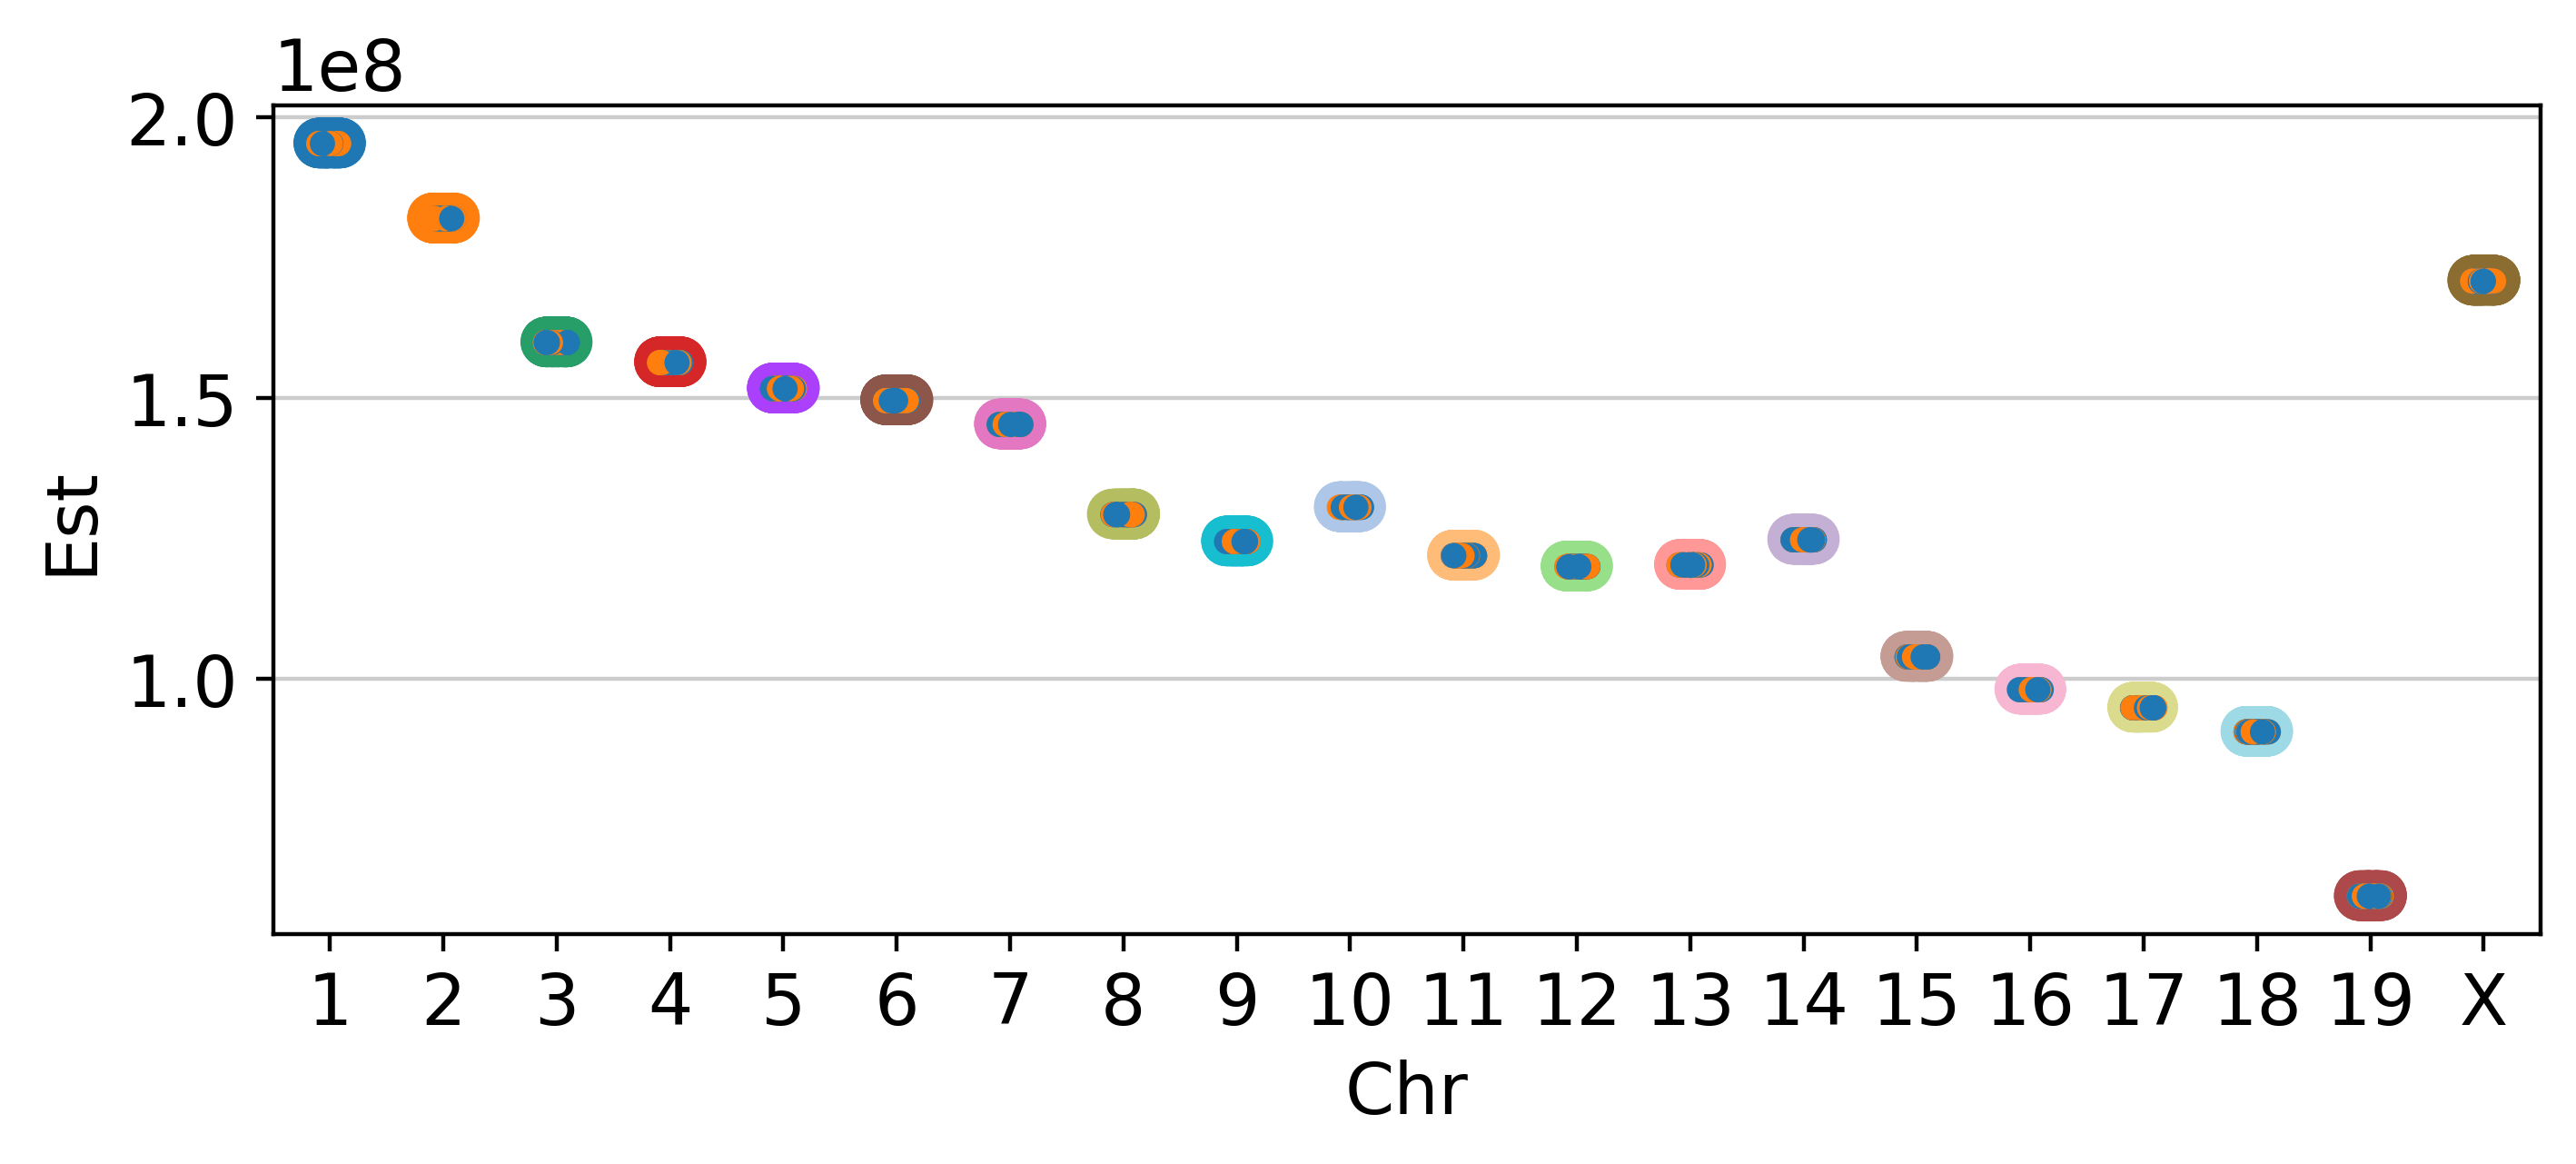

In [604]:
import seaborn as sns
fig,ax = plt.subplots(figsize=(8,3))
sns.stripplot(data=df, x='Chr', y='True', c='k', s=10)
g = sns.stripplot(data=df, x='Chr', y='Est', hue='meth')
g.legend().remove()
plt.show()

In [161]:
%%bash
#### Merge bw files with deeptools ####
path=/cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/
data_l=("CG" "CAC")
cell_l=($(ls $path))

for c in ${cell_l[@]}
do
    echo Running $c
    
    for d in ${data_l[@]}
    do
    echo Running $d
        bw_l=($(ls $path$c/*$d*bw))
        echo ${bw_l[@]}
        
        # Running multiBigwigSummary
        multiBigwigSummary bins \
            --bwfiles ${bw_l[@]} \
            --binSize 128 \
            --numberOfProcessors 12 \
            --outFileName $path$c/$c'_'$d'.merge.bingraph.npz' \
            --outRawCounts $path$c/$c'_'$d'.merge.bingraph.raw'
            echo "multiBigwigSummary analysis is complete."
    done
done
echo 'All Done'


L2-3_IT
CG
/cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/L2-3_IT/C4_1_L2-3_IT_CG.bw /cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/L2-3_IT/C4_2_L2-3_IT_CG.bw
CAC
/cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/L2-3_IT/C4_1_L2-3_IT_CAC.bw /cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/L2-3_IT/C4_2_L2-3_IT_CAC.bw
L5_IT
CG
/cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/L5_IT/C1_1_L5_IT_Rspo1_1_CG.bw /cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/L5_IT/C1_2_L5_IT_Rspo2_1_CG.bw /cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/L5_IT/C3_2_L5_IT_S100b_CG.bw
CAC
/cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/L5_IT/C1_1_L5_IT_Rspo1_1_CAC.bw /cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/L5_IT/C1_2_L5_IT_Rspo2_1_CAC.bw /cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/L5_IT/C3_2_L5_IT_S100b_CAC.bw
L6b
CG
/cndd2/dbu

# Pseudobulk atac

In [14]:
#atac
#==============
atac_df = pd.read_csv('/cndd/Public_Datasets/BICCN/BICCN_minibrain_data/data_freeze/snmc_and_snatac/study/atac/ATAC.cell_tidy_data.csv.gz', sep=',', index_col=0) 
len(atac_df)

81196

In [16]:
np.asarray(np.unique(atac_df['MajorCluster'], return_counts=True)).T

array([['ASC', 7215],
       ['CGE', 3230],
       ['Endo', 1245],
       ['L23.a', 6085],
       ['L23.b', 5758],
       ['L23.c', 3590],
       ['L4', 7307],
       ['L5.IT.a', 3668],
       ['L5.IT.b', 4214],
       ['L5.PT', 1755],
       ['L6.CT', 8008],
       ['L6.IT', 4233],
       ['MGC', 3899],
       ['NP', 1291],
       ['OGC', 8557],
       ['OPC', 3279],
       ['Other', 1571],
       ['Pv', 3275],
       ['Smc', 586],
       ['Sst', 2430]], dtype=object)

In [4]:
atac_df['barcode'].unique()

array(['CEMBA171206_3C', 'CEMBA171207_3C', 'CEMBA171212_4B',
       'CEMBA171213_4B', 'CEMBA180104_4B', 'CEMBA180409_2C',
       'CEMBA180410_2C', 'CEMBA180612_5D', 'CEMBA180618_5D'], dtype=object)

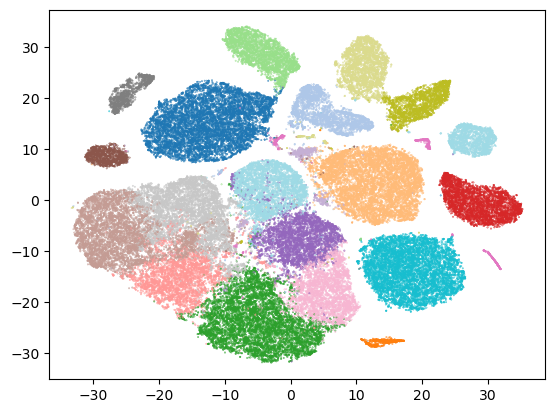

In [81]:
#atac
#==============
atac_df = pd.read_csv('/cndd/Public_Datasets/BICCN/BICCN_minibrain_data/data_freeze/snmc_and_snatac/study/atac/ATAC.cell_tidy_data.csv.gz', sep=',', index_col=0) 
len(atac_df)
prac = atac_df
plt.scatter(prac['tsne_0'], prac['tsne_1'], s=0.1, cmap='tab20', c=prac['cluster'])
plt.show()


In [23]:
atac_df

,barcode,sample,TN,UM,PP,UQ,CM,tsne_0,tsne_1,cluster,region,MajorCluster
0,CEMBA171206_3C,AGCGATAGAACCAGGTAAGAGATGTATAGCCT,138330,128263,128039,64868,0,7.605117,0.697672,4,3C,L6.CT
1,CEMBA171206_3C,AGCGATAGAACCAGGTAATGACGTCAGGACGT,159133,146663,146348,69167,0,-9.492925,-6.200938,16,3C,L23.b
2,CEMBA171206_3C,AGCGATAGAACCAGGTAGGATAACATAGAGGC,19152,17586,17545,8348,0,14.227358,-11.023748,19,3C,ASC
3,CEMBA171206_3C,AGCGATAGAACCAGGTATAGCCTTAGGCGAAG,14876,13837,13801,6583,0,5.144768,4.790674,4,3C,L6.CT
4,CEMBA171206_3C,AGCGATAGAACCAGGTATAGCCTTATAGAGGC,28532,26303,26202,12437,0,5.218895,-8.674734,9,3C,L5.IT.b
...,...,...,...,...,...,...,...,...,...,...,...,...
81191,CEMBA180618_5D,TCCGGAGATTCCATCCGTACTGACTAAGATCC,11554,10475,10431,8413,0,-31.803957,-2.506705,12,5D,L23.a
81192,CEMBA180618_5D,TCCGGAGATTCCATCCGTACTGACTTCATCCA,2044,1854,1851,1437,0,-6.867229,28.553077,6,5D,OPC
81193,CEMBA180618_5D,TCCGGAGATTCCATCCTATAGCCTCGAATTCC,9567,8636,8604,6709,0,5.533320,6.234067,4,5D,L6.CT
81194,CEMBA180618_5D,TCCGGAGATTCCATCCTATAGCCTTAAGATCC,1810,1591,1582,1262,0,-17.128061,13.283708,1,5D,OGC


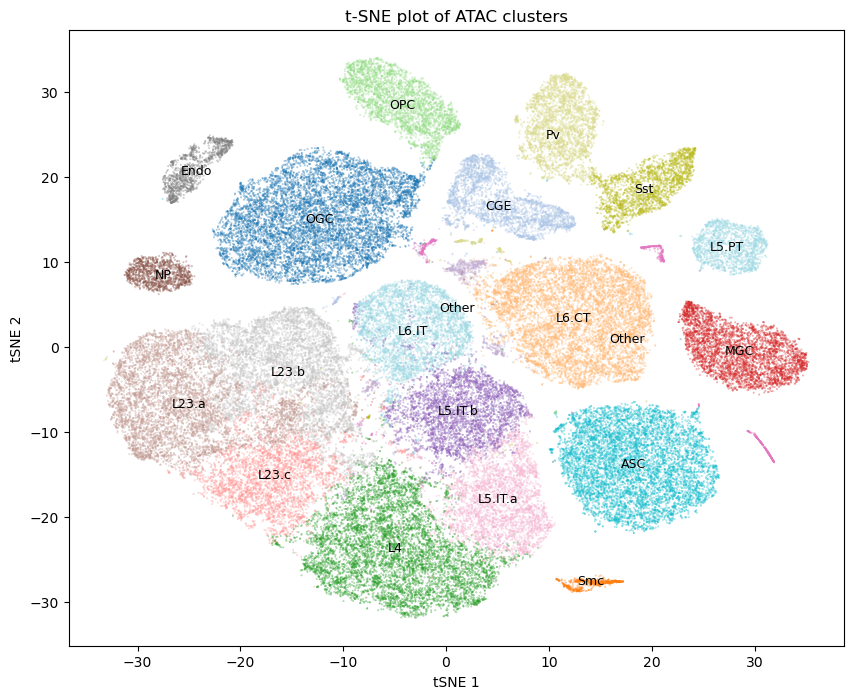

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming atac_df is already loaded as shown in your snippet
prac = atac_df

# Plot the scatter plot
plt.figure(figsize=(10, 8))  # Optional: Adjust figure size as needed
scatter = plt.scatter(prac['tsne_0'], prac['tsne_1'], s=0.1, cmap='tab20', c=prac['cluster'], alpha=0.6)

# Calculate centroids and label each cluster
for cluster in prac['cluster'].unique():
    cluster_data = prac[prac['cluster'] == cluster]
    centroid = [cluster_data['tsne_0'].mean(), cluster_data['tsne_1'].mean()]
    # Retrieve the first MajorCluster name associated with this cluster for labeling
    cluster_label = cluster_data['MajorCluster'].iloc[0]
    plt.text(centroid[0], centroid[1], cluster_label, fontsize=9, ha='center', va='center')

plt.xlabel('tSNE 1')  # Adjust label as necessary
plt.ylabel('tSNE 2')  # Adjust label as necessary
plt.title('t-SNE plot of ATAC clusters')  # Optional: Adjust title as necessary
plt.show()


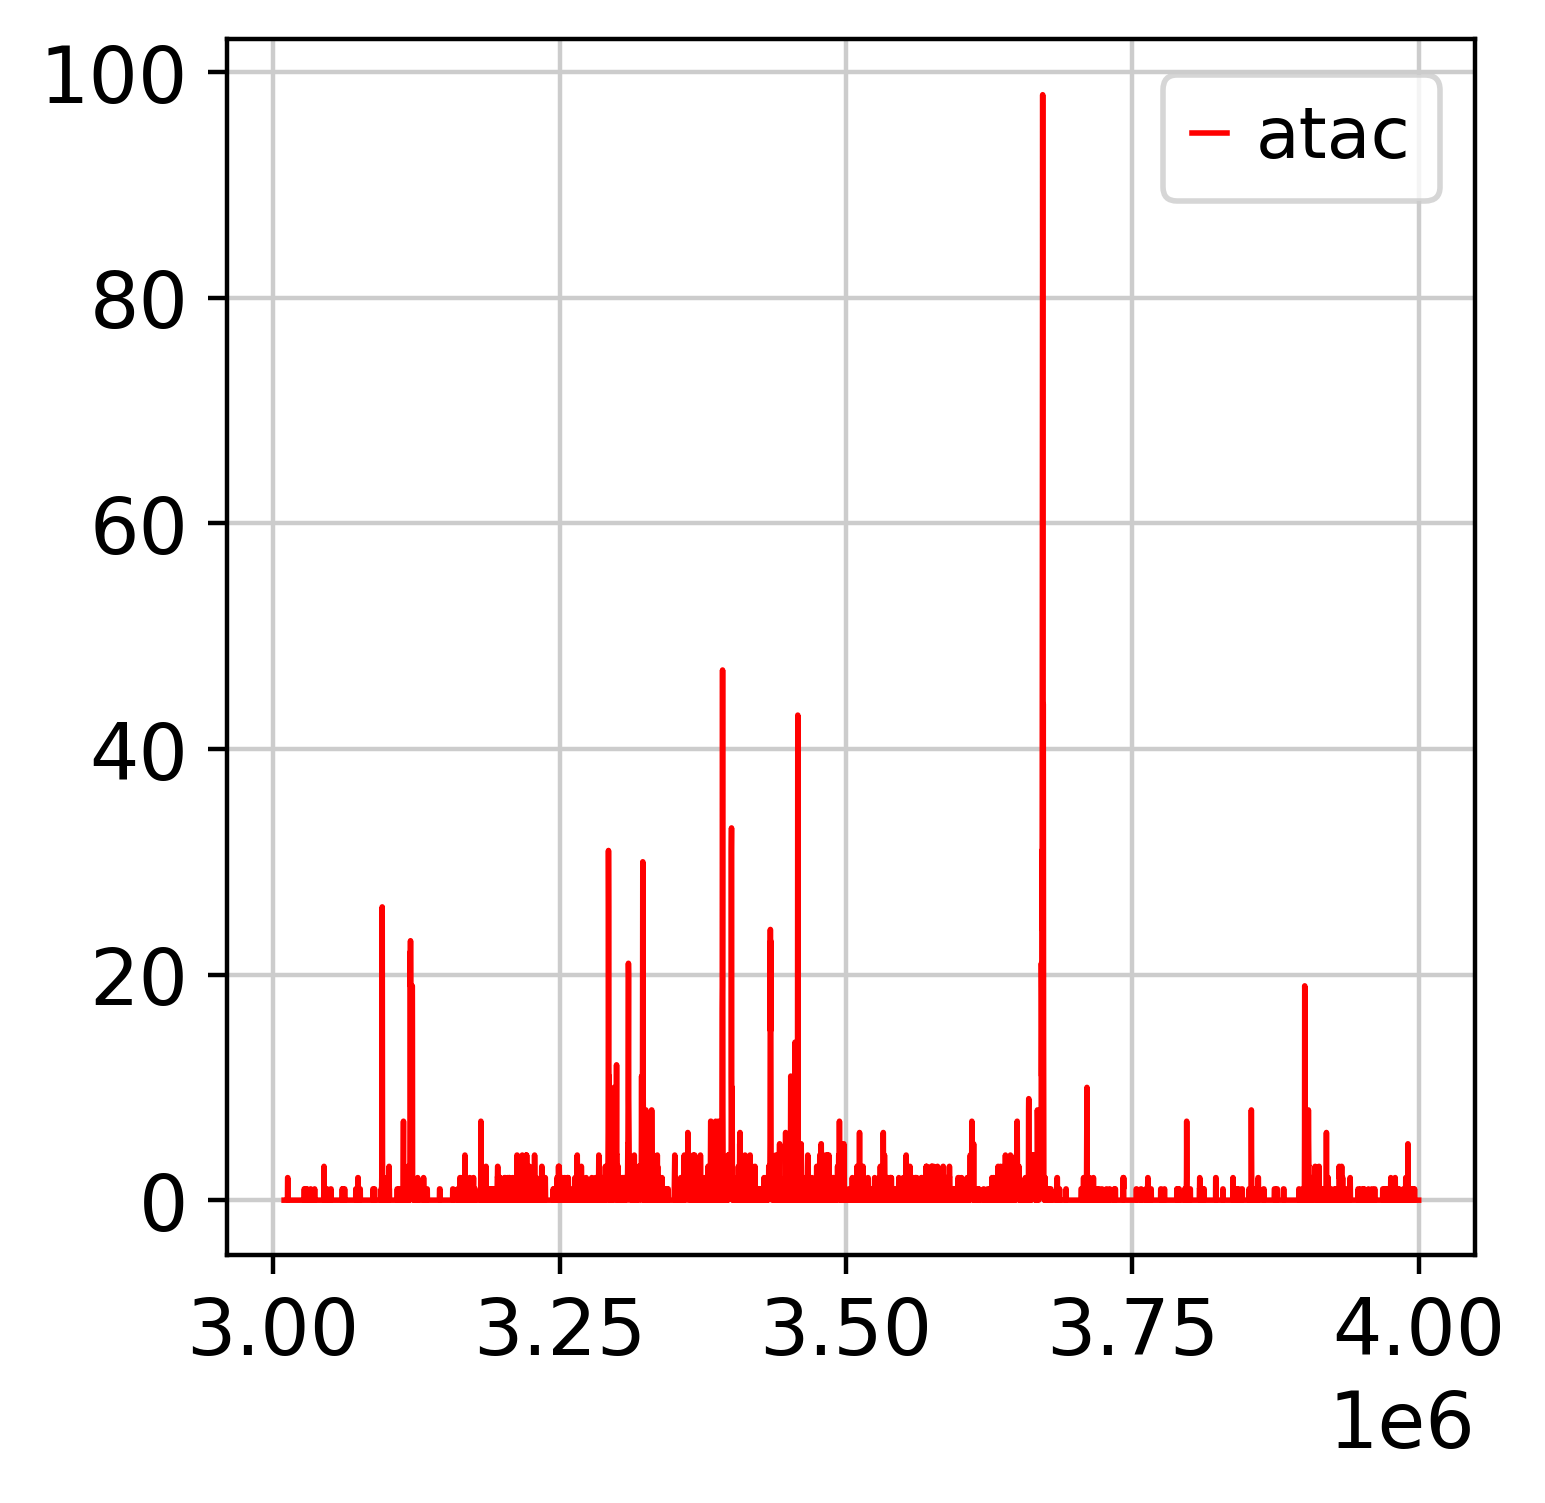

In [572]:
#Visualise mc tracks -> load bigwig files -> check smoothing
import pyBigWig as bw
path = '/cndd/emukamel/enformer/CEMBA_MOp_mc_bigwigs/bigwig'
atac_l = glob.glob(f'{path}/*ATAC.bw')
# Plot CH and CG methylation
atac = bw.open(atac_l[1])
prac_atac = np.asarray(atac.intervals('1', 3009600, 4000000))
plt.plot(prac_atac[:,0], prac_atac[:,2], linewidth=1, c='red', label='atac')
plt.legend()
plt.show()

In [599]:
#confirm atac bin coverage decreases with chromosome
#Visualise mc tracks -> load bigwig files 
chr_list = list(_cg.chroms().keys())
ref = pd.read_csv('/cndd3/dburrows/DATA/annotations/genome/grcm38.p3/modified_mm10.chrom.sizes', sep='\t', index_col=0, header=None)

donor_l, chr_l, bin_n, true_l = [],[],[],[]
import pyBigWig as bw
path = '/cndd/emukamel/enformer/CEMBA_MOp_mc_bigwigs/bigwig'
cg_l = glob.glob(f'{path}/*ATAC.bw')
for x in range(len(cg_l)):
    _cg = bw.open(cg_l[x])
    for ch in chr_list:
        donor_l.append(os.path.basename(cg_l[x]))
        chr_l.append(ch)
        bin_n.append(len(_cg.intervals(ch)))
        true_l.append(ref.loc[ch].values[0])

df = {'Donor':donor_l, 'Chr': chr_l, 'Nbins': bin_n, 'True': true_l} 
df = pd.DataFrame(df)


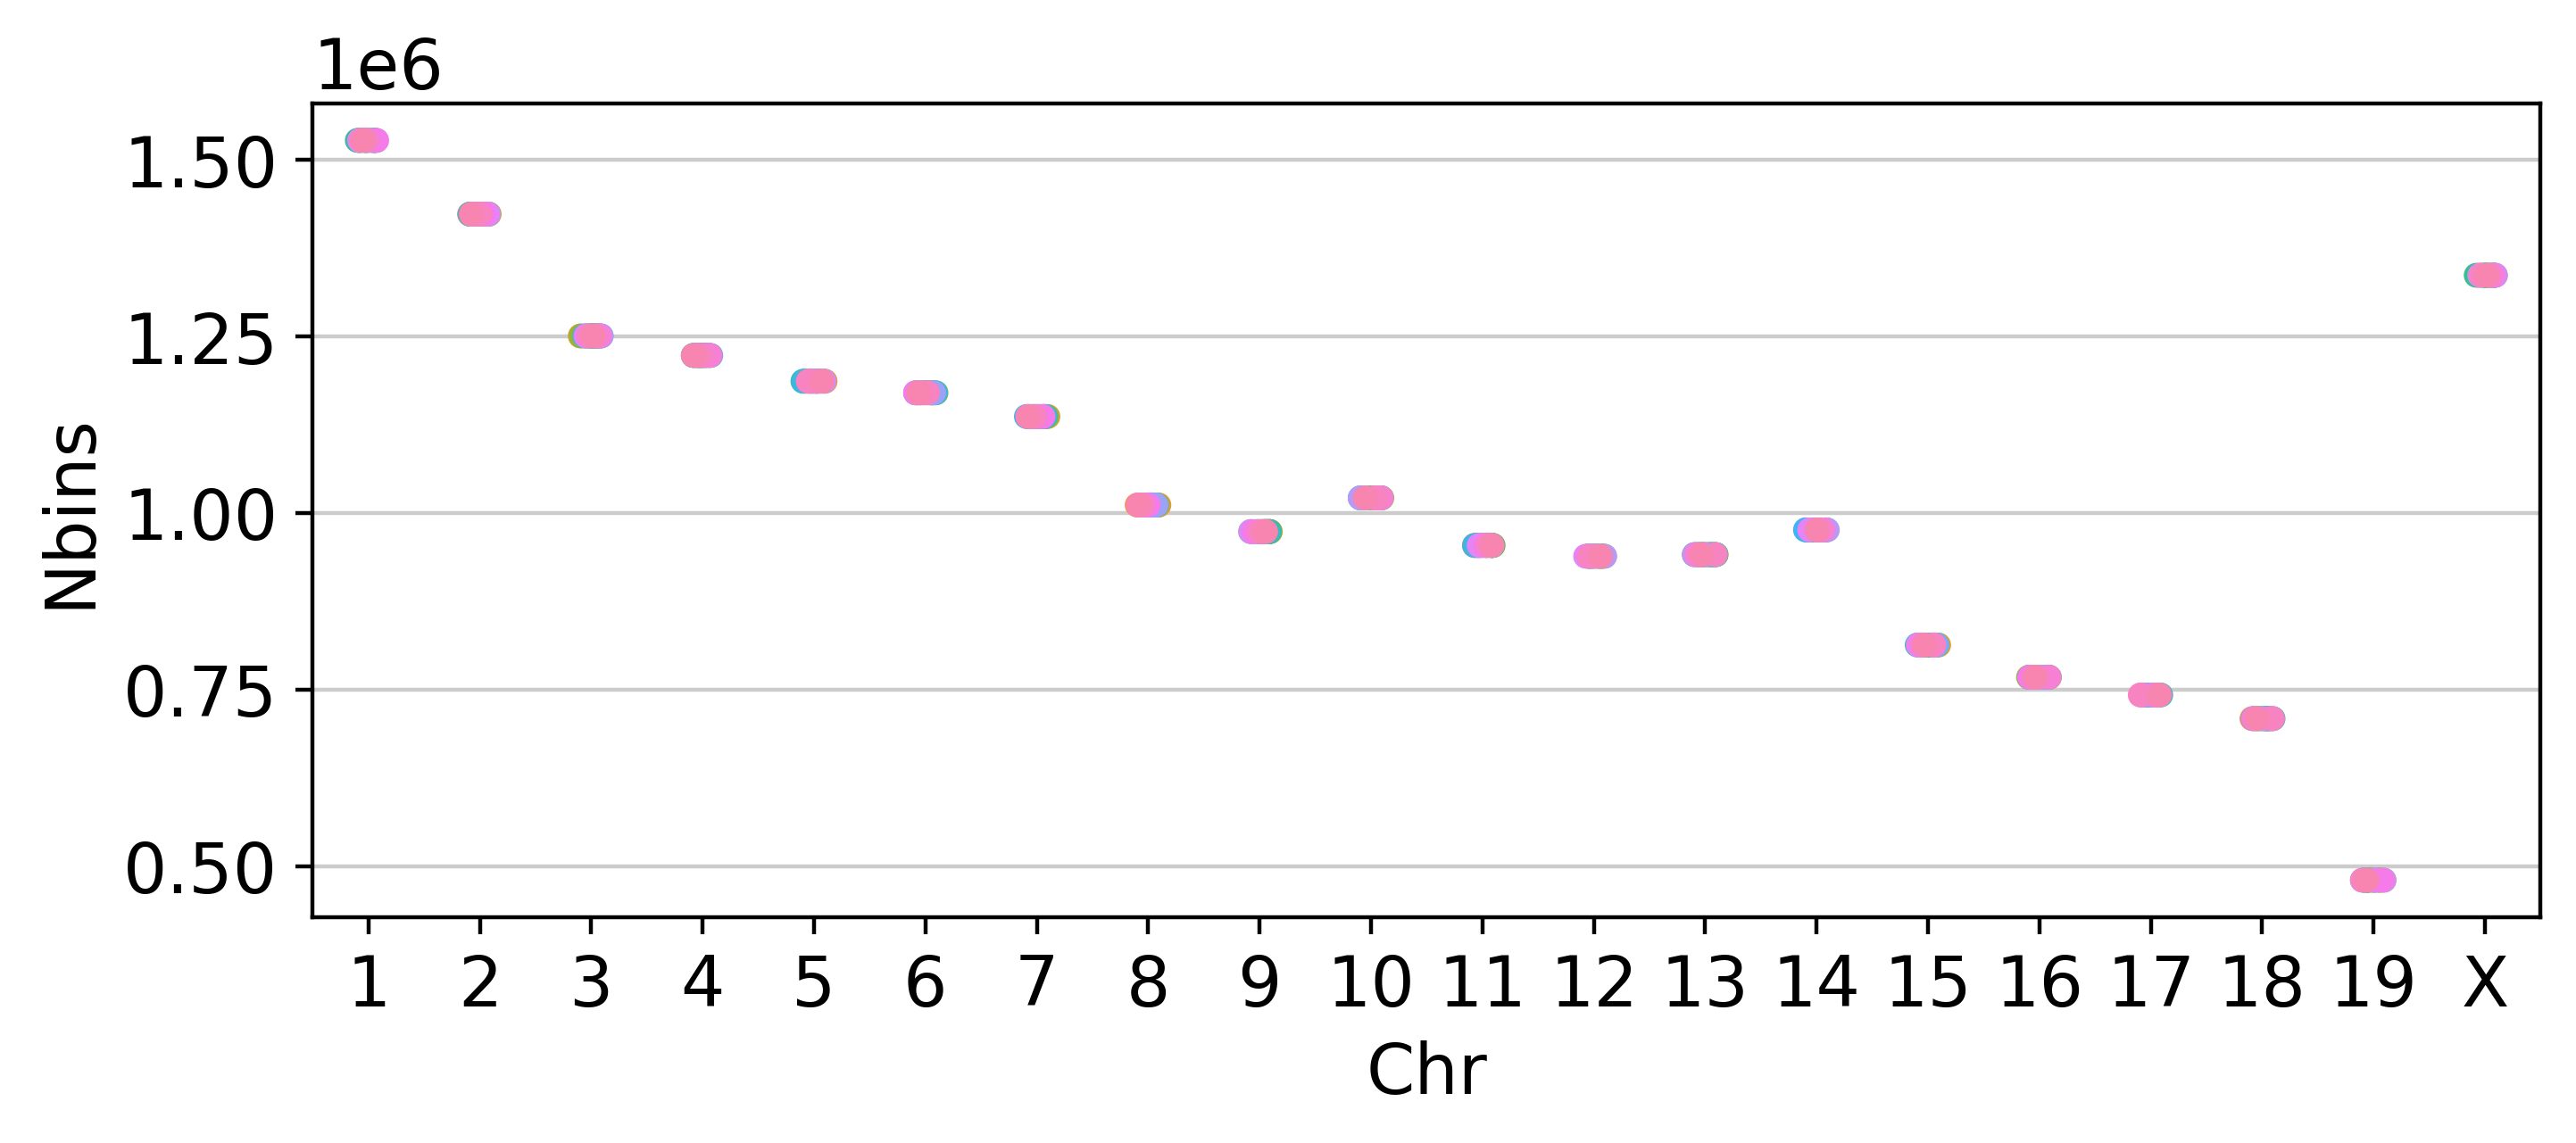

In [600]:
import seaborn as sns
fig,ax = plt.subplots(figsize=(8,3))
#sns.stripplot(data=df, x='Chr', y='True', c='k', s=10)
g = sns.stripplot(data=df, x='Chr', y='Nbins', hue='Donor')
g.legend().remove()
plt.show()

In [601]:
df

,Donor,Chr,Nbins,True
0,C7_1_L6_NP_Trh_1_ATAC.bw,1,1527125,195471971
1,C7_1_L6_NP_Trh_1_ATAC.bw,2,1422760,182113224
2,C7_1_L6_NP_Trh_1_ATAC.bw,3,1250310,160039680
3,C7_1_L6_NP_Trh_1_ATAC.bw,4,1222720,156508116
4,C7_1_L6_NP_Trh_1_ATAC.bw,5,1186209,151834684
...,...,...,...,...
575,C1_2_L5_IT_Rspo2_1_ATAC.bw,16,767249,98207768
576,C1_2_L5_IT_Rspo2_1_ATAC.bw,17,742089,94987271
577,C1_2_L5_IT_Rspo2_1_ATAC.bw,18,708615,90702639
578,C1_2_L5_IT_Rspo2_1_ATAC.bw,19,479935,61431566


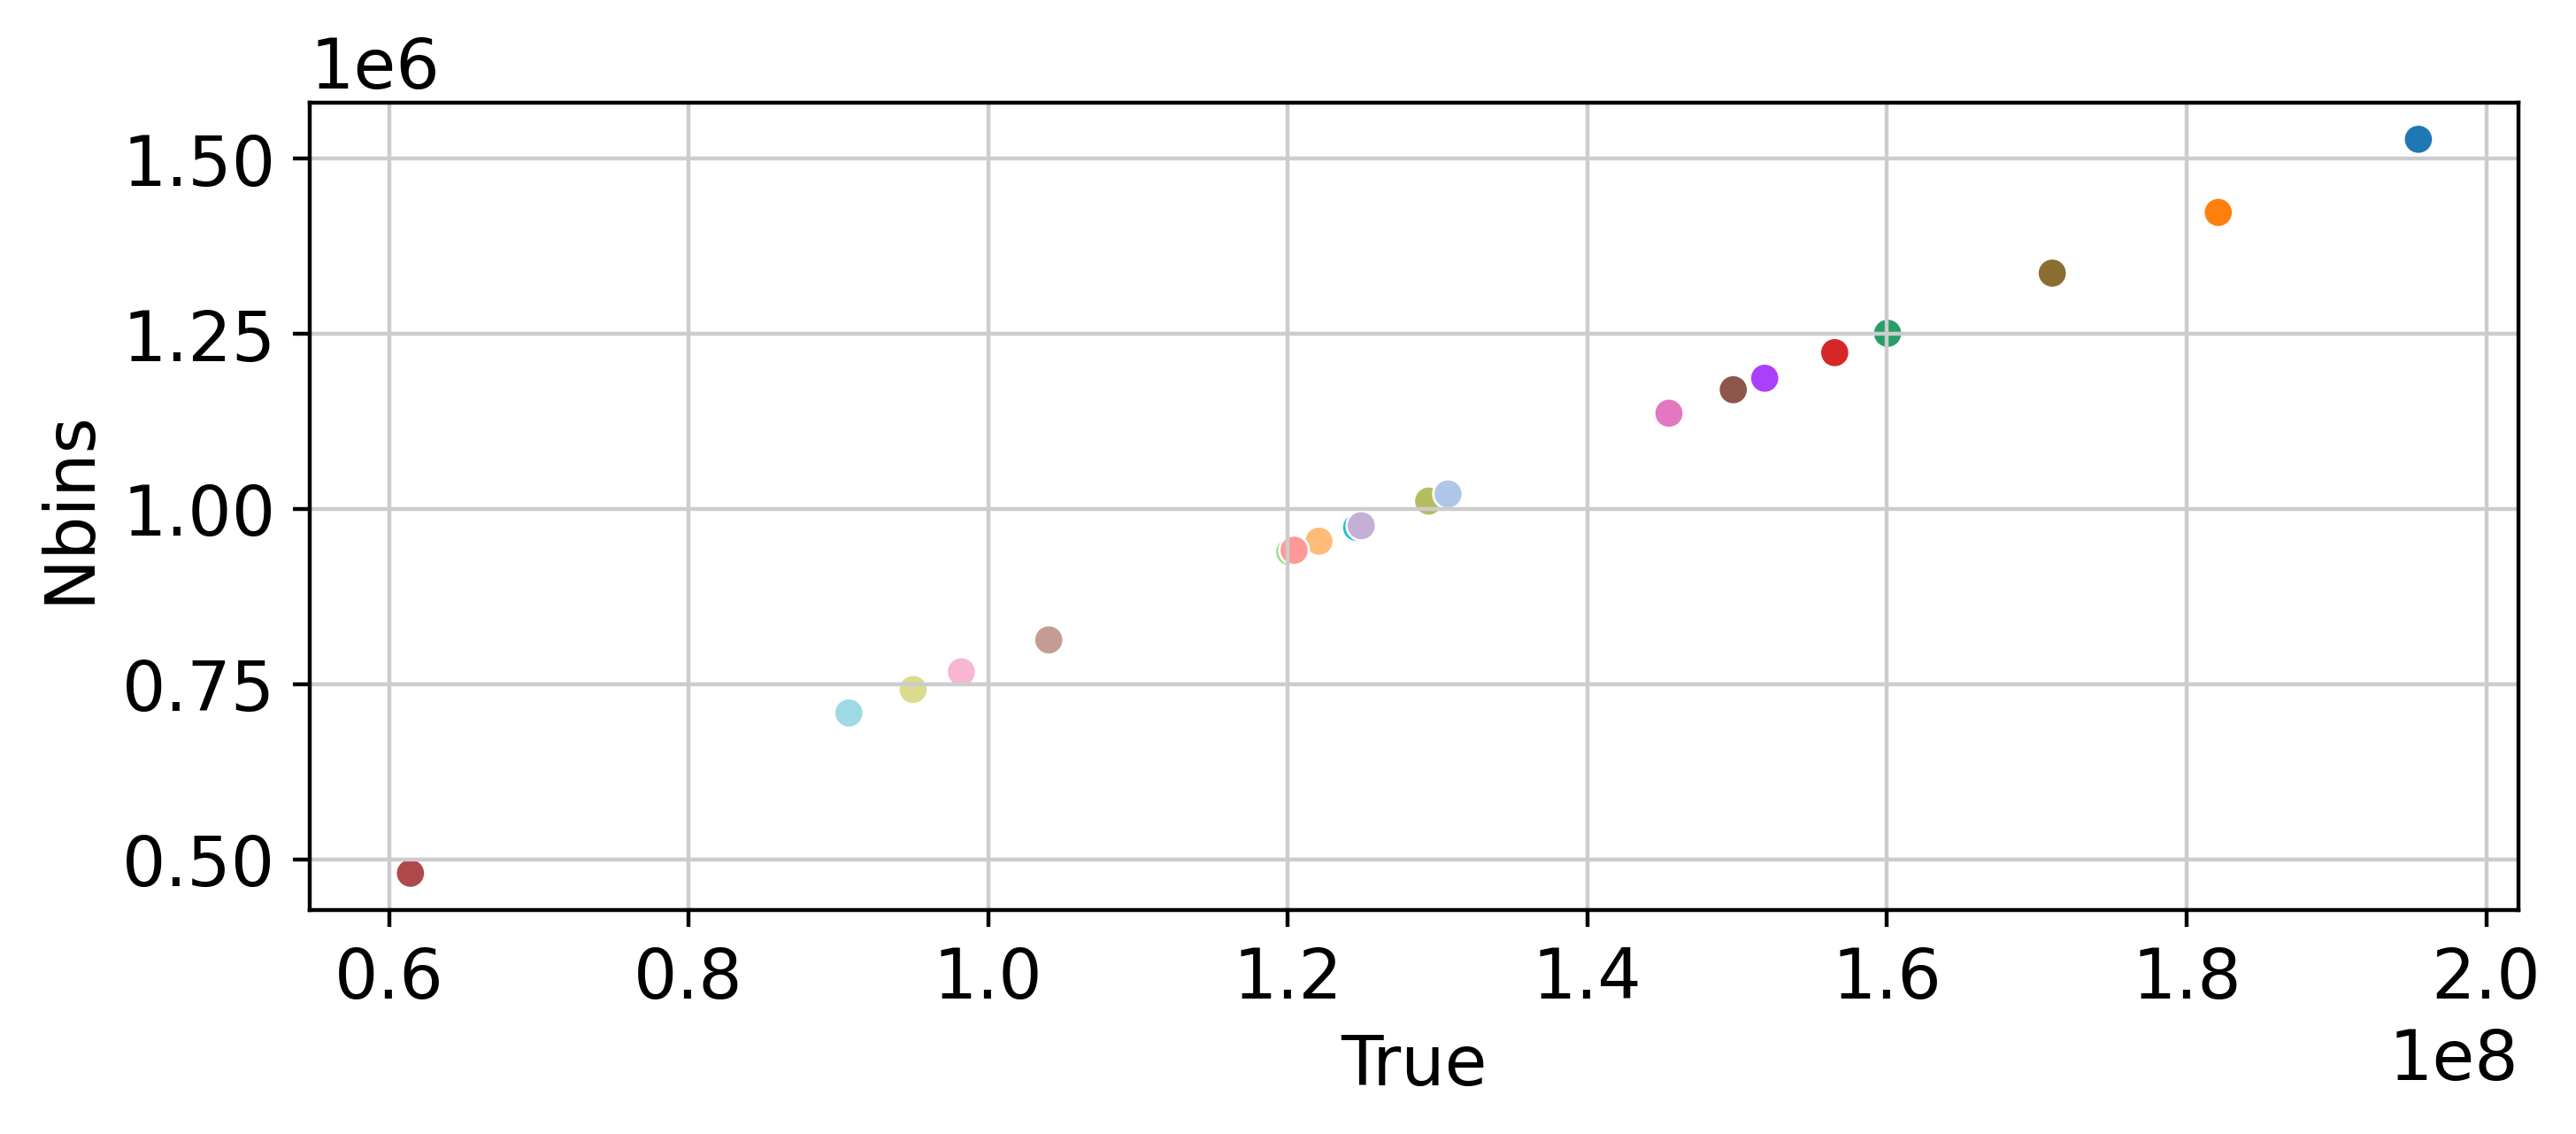

In [602]:
import seaborn as sns
fig,ax = plt.subplots(figsize=(8,3))
#sns.stripplot(data=df, x='Chr', y='True', c='k', s=10)
g = sns.scatterplot(data=df, x='True', y='Nbins', hue='Chr')
g.legend().remove()
plt.show()

In [74]:
#### Merge bw files with deeptools ####

#!/bin/bash

path=/cndd2/dburrows/DATA/splice/snatacseq-atac_MOp_biccn/pseudobulk/gran1/

data_l=("ATAC")
cell_l=($(ls $path))

for c in ${cell_l[@]}
do
    echo Running $c
    
    for d in ${data_l[@]}
    do
    echo Running $d
        bw_l=($(ls $path$c/*$d*bw))
        echo ${bw_l[@]}
        
        # Running multiBigwigSummary
        multiBigwigSummary bins \
            --bwfiles ${bw_l[@]} \
            --binSize 128 \
            --numberOfProcessors 12 \
            --outFileName $path$c/$c'_'$d'.merge.bingraph.npz' \
            --outRawCounts $path$c/$c'_'$d'.merge.bingraph.raw'
            echo "multiBigwigSummary analysis is complete."
    done
done
echo 'All Done'

{'Data': 'ATAC',
 'L2-3_IT': array(['C4_2_L2-3_IT_ATAC.bw', 'C4_1_L2-3_IT_ATAC.bw'], dtype='<U20'),
 'L5_IT': array(['C1_1_L5_IT_Rspo1_1_ATAC.bw', 'C3_2_L5_IT_S100b_ATAC.bw',
        'C1_2_L5_IT_Rspo2_1_ATAC.bw'], dtype='<U26'),
 'L6_IT': array(['C3_3_L6_IT_Car3_ATAC.bw', 'C3_1_L6_IT_2_ATAC.bw'], dtype='<U23'),
 'L6_CT': array(['C2_3_L6_CT_Nxph2_Pou3f2_ATAC.bw', 'C2_1_L6_CT_Cpa6_ATAC.bw',
        'C2_2_L6_CT_Cpa6_ATAC.bw'], dtype='<U31'),
 'L6b': array(['C8_2_L6b_Ror1_ATAC.bw', 'C8_1_L6b_Shisa6_1_ATAC.bw',
        'C8_3_L6b_Kcnip1_2_ATAC.bw'], dtype='<U25'),
 'Vip': array(['C6_1_Vip_Chat_ATAC.bw', 'C6_3_Vip_Gpc3_ATAC.bw'], dtype='<U21'),
 'Pvalb': array(['C5_1_Pvalb_Reln_ATAC.bw', 'C5_4_Pvalb_Gabrg1_ATAC.bw',
        'C5_5_Pvalb_Vipr2_ATAC.bw'], dtype='<U25'),
 'Sst': array(['C10_1_Sst_Chodl_ATAC.bw', 'C5_3_Sst_Calb2_ATAC.bw',
        'C5_2_Sst_Myh8_2_ATAC.bw'], dtype='<U23'),
 'Lamp5': array(['C6_2_Lamp5_Slc35d3_ATAC.bw', 'C6_4_Lamp5_Pdlim5_ATAC.bw',
        'C6_6_Lamp5_Lhx6_ATAC.bw']

In [201]:
#Edit chr headers of corrupted bw file
path='/cndd2/dburrows/DATA/splice/snatacseq-atac_MOp_biccn/pseudobulk/gran1/L2-3_IT/'
l = glob.glob(path+'/C*')
bw1 = bw.open(l[0])
bw2 = bw.open(l[1])
new_ = bw1.chroms()
new_chrs = [(chr_name, length) for chr_name, length in new_.items()]
new_chrs

[('1', 195472099),
 ('2', 182113352),
 ('3', 160039808),
 ('4', 156508244),
 ('5', 151834812),
 ('6', 149736674),
 ('7', 145441587),
 ('8', 129401341),
 ('9', 124595238),
 ('10', 130695121),
 ('11', 122082671),
 ('12', 120129150),
 ('13', 120421767),
 ('14', 124902372),
 ('15', 104043813),
 ('16', 98207896),
 ('17', 94987399),
 ('18', 90702767),
 ('19', 61431694),
 ('X', 171031427)]

In [211]:
bw_new = bw.open(path + 'prac.bw', 'w')
bw_new.addHeader(new_chrs)

# Now copy all intervals from the original BigWig file to the new one
for chr_name in bw2.chroms().keys():
    # Get intervals for this chromosome in the original BigWig file
    intervals = bw2.intervals(chr_name)
    if intervals:
        # Add each interval to the new BigWig file
        for start, end, value in intervals:
            # Ensure the interval is within the new chromosome length
            bw_new.addEntries([chr_name], [start], ends=[end], values=[value])
    print(f'Done {chr_name}')

# Close both BigWig files
bw_new.close()


Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 10
Done 11
Done 12
Done 13
Done 14
Done 15
Done 16
Done 17
Done 18
Done 19
Done X


# Pseudobulk + Align SMARTseq scRNA

In [2]:
#Load metadata from pachter paper
#load in metadata 
meta = sc.read_h5ad('/cndd3/dburrows/DATA/public_datasets/splice//smartseq_mouse_p53-59_MOp_pachter21/metadata/isoform.h5ad')
meta

/home/dburrows/mambaforge/envs/base_conda/lib/python3.9/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/dburrows/mambaforge/envs/base_conda/lib/python3.9/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 6160 × 69172
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p', 'norm'
    obsp: 'distances', 'connectivities'

In [28]:
#UMAP embedding
sc.tl.umap(meta)

In [44]:
np.asarray(meta.obs['subclass_label'].unique())

array(['Vip', 'L5 IT', 'Lamp5', 'Sst', 'L5/6 NP', 'Pvalb', 'L2/3 IT',
       'L6 IT', 'Astro', 'L6 CT', 'L6b', 'L5 PT', 'Sncg', 'Low Quality',
       'L6 IT Car3', 'SMC', 'VLMC', 'Endo'], dtype=object)

In [46]:
np.unique(np.asarray(meta.obs['subclass_label']), return_counts=True)

(array(['Astro', 'Endo', 'L2/3 IT', 'L5 IT', 'L5 PT', 'L5/6 NP', 'L6 CT',
        'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Low Quality', 'Pvalb',
        'SMC', 'Sncg', 'Sst', 'VLMC', 'Vip'], dtype=object),
 array([   9,    7,  482, 1561,   12,  207,  904,  395,    5,  570,  360,
          12,  521,   19,   77,  406,    6,  607]))

In [45]:
np.asarray(meta.obs['cluster_label'].unique())

array(['Vip Chat_1', 'L5 IT S100b_2', 'Lamp5 Slc35d3', 'Sst Myh8_2',
       'L5 NP Slc17a8', 'Sst Etv1', 'L5 IT Rspo1', 'L5 IT Rspo2',
       'L5 IT S100b_1', 'Vip Htr1f', 'Pvalb Reln', 'L5 IT Tcap_1',
       'Vip Chat_2', 'Vip Igfbp6', 'Lamp5 Egln3_1', 'L2/3 IT Macc1',
       'L2/3 IT S100a6', 'Vip Crispld2', 'Vip C1ql1', 'L2/3 IT Cdh13 Sla',
       'L6 IT Sulf_1', 'Lamp5 Pdlim5', 'Vip Chat_3', 'Sst Myh8_1',
       'L6 IT Sulf_3', 'L5 IT Tcap_2', 'Astro Aqp4', 'L6 CT Grp_1',
       'L6 NP Trh', 'L6 CT Nxph2_1', 'L6b Shisa6', 'L6b Ror1_1', 'L5 PT',
       'Sst Crhr2_1', 'Pvalb Vipr2', 'Sst C1ql3', 'Sncg', 'Sst Crhr2_2',
       'Vip Gpc3', 'Vip Serpinf1', 'Lamp5 Lhx6', 'Vip Lmo1', 'Pvalb Th',
       'L5 IT Tcap_low', 'L6 CT Gpr139', 'L6b Rprm', 'L6 IT Sulf_2',
       'L5 IT Pld5', 'L6 CT Grp_2', 'Lamp5 Egln3_2', 'Sst Chodl',
       'L6 CT Nxph2_2', 'Sncg Slc17a8', 'L6 IT Car3', 'Pvalb Calb1',
       'L6b Ror1_2', 'Pvalb Gpr149', 'SMC Aoc3', 'L6b Kcnip1_1',
       'L6b Kcnip1_2', 'VLMC',

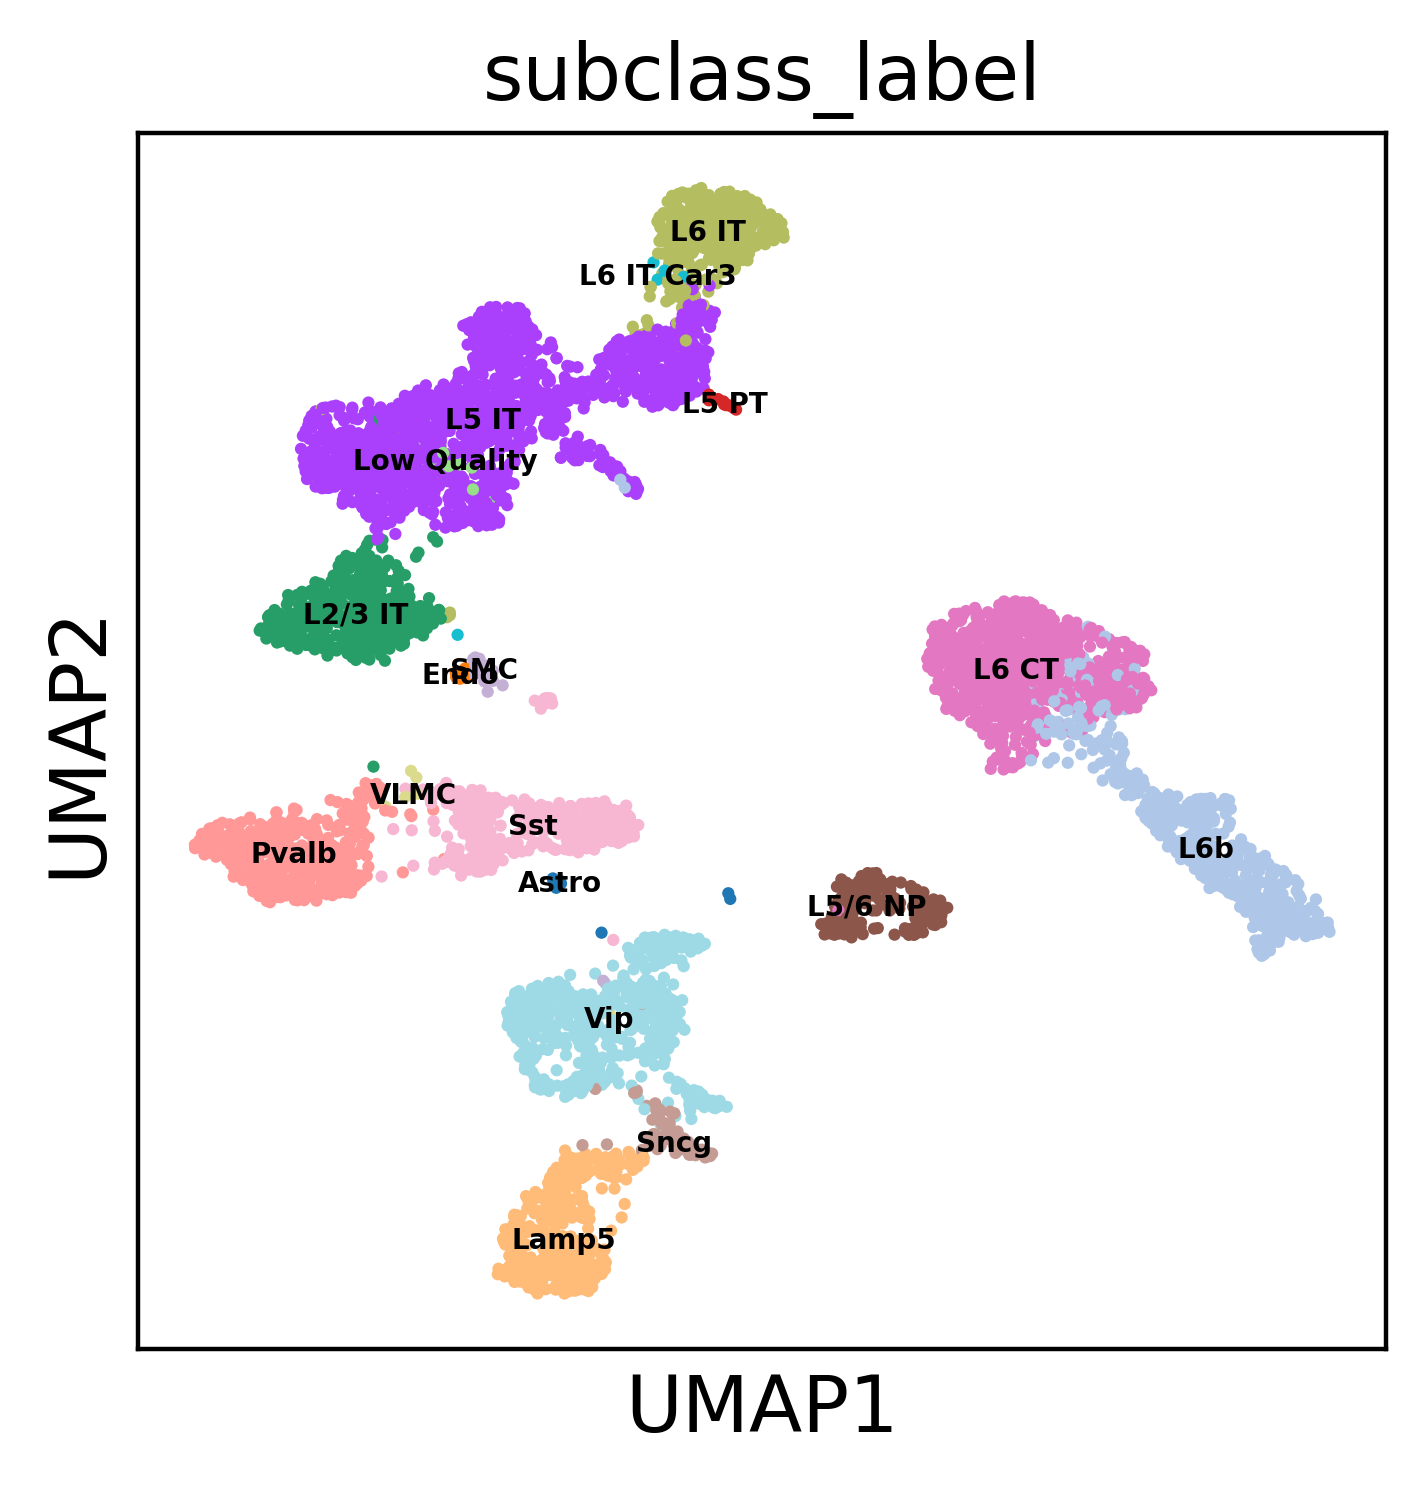

In [43]:
# Set figure parameters
sc.set_figure_params(figsize=(5, 5))
sc.set_figure_params(dpi=200)

# Plot UMAP with smaller legend label size
sc.pl.umap(meta, color=['subclass_label'], legend_loc='on data', legend_fontsize='5')


In [51]:
#check that you have all cells
prac = [os.path.basename(i).split('.')[0] for i in glob.glob('/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/fastq/**')]
assert sum(np.in1d(prac, meta.obs['cell_id'].values)) == len(prac), 'some cells in your dir are not in metadata'

In [114]:
#Grab data from nemo
from bs4 import BeautifulSoup

# Specify the path to your HTML file
file_path = '/cndd3/dburrows/DATA/public_datasets/splice/smartseq_mouse_p53-59_MOp_pachter21/nemo.html'

# Open the file and read its contents
with open(file_path, 'r', encoding='utf-8') as file:
    html_content = file.read()

# Parse the HTML content with BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')
fastq_links = [a['href'] for a in soup.find_all('a', href=True) if 'fastq' in a['href']]

filt_id = meta.obs['cell_id'].values
raw_id = np.asarray([i.split('.')[0] for i in fastq_links])
if sum(np.in1d(filt_id,raw_id)) == len(filt_id): print('all labelled cells are in nemo archive')

all labelled cells are in nemo archive


In [140]:
#Use filt_id to batch wget files from nemo

#generate txt file with paths
sub_str = 'https://data.nemoarchive.org/biccn/lab/zeng/transcriptome/scell/SSv4/mouse/raw/MOp/'
path_l = [sub_str + i for i in np.asarray(fastq_links)[np.in1d(raw_id, filt_id)]]

file_path = '/cndd3/dburrows/DATA/public_datasets/splice/smartseq_mouse_p53-59_MOp_pachter21/metadata/download_list.txt'

# Writing the URLs to the file
with open(file_path, 'w') as file:
    for url in path_l:
        file.write(url + '\n')
  
# batch download
#! xargs -n 1 -P 10 wget < /cndd3/dburrows/DATA/public_datasets/splice/smartseq_mouse_p53-59_MOp_pachter21/metadata/download_list.txt

In [11]:
np.asarray(np.unique(meta.obs['subclass_label'], return_counts=True)).T

array([['Astro', 9],
       ['Endo', 7],
       ['L2/3 IT', 482],
       ['L5 IT', 1561],
       ['L5 PT', 12],
       ['L5/6 NP', 207],
       ['L6 CT', 904],
       ['L6 IT', 395],
       ['L6 IT Car3', 5],
       ['L6b', 570],
       ['Lamp5', 360],
       ['Low Quality', 12],
       ['Pvalb', 521],
       ['SMC', 19],
       ['Sncg', 77],
       ['Sst', 406],
       ['VLMC', 6],
       ['Vip', 607]], dtype=object)

In [7]:
np.unique(meta.obs['subclass_label'], return_counts=True)[1]

array([   9,    7,  482, 1561,   12,  207,  904,  395,    5,  570,  360,
         12,  521,   19,   77,  406,    6,  607])

In [53]:
np.unique(meta.obs['class_label'], return_counts=True)

(array(['GABAergic', 'Glutamatergic', 'Low Quality', 'Non-Neuronal'],
       dtype=object),
 array([1971, 4136,   12,   41]))

In [58]:
#check that you have all cells
f_l = [os.path.basename(i) for i in glob.glob('/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/fastq/*fastq*')]
meta.obs['cell_id'].values

array(['LS-15395_S47_E1-50', 'LS-15395_S48_E1-50', 'LS-15395_S49_E1-50',
       ..., 'SM-GE935_S382_E1-50', 'SM-GE935_S383_E1-50',
       'SM-GE935_S384_E1-50'], dtype=object)

In [83]:
glu_cell = meta.obs['cell_id'][meta.obs['class_label'] == 'Glutamatergic'].values
gaba_cell = meta.obs['cell_id'][meta.obs['class_label'] == 'GABAergic'].values
cell_l = glu_cell, gaba_cell
name_l = ['GLU', 'GABA']

In [ ]:
# access each file, untar -> append contents of r1 to file and r2 to file
in_path = '/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/fastq/'
out_path = '/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/coarse/'
for y,cell in enumerate(cell_l):
    for x,g in enumerate(cell):
        run = f""" 
        tar -xf {in_path}{g}.fastq.tar --to-stdout {g}_R1.fastq.gz | zcat >> {out_path}{name_l[y]}/{name_l[y]}_R1.fastq
        tar -xf {in_path}{g}.fastq.tar --to-stdout {g}_R2.fastq.gz | zcat >> {out_path}{name_l[y]}/{name_l[y]}_R2.fastq
        """
        
        subprocess.run(run, shell=True)
        if int(x%(len(cell)/10)) == 0: print(f'Done {int(x/len(cell)*100)} ')

In [152]:
# filter reads quality? // trim_galore
%%bash
path=/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/coarse/
#id_arr=($(find $inpath/ -maxdepth 1 -name "*Sample*$str*"))
cell_arr=("GLU" "GABA")
for c in ${cell_arr[@]}
do
    curr=($(ls $path$c))
    echo ${curr[0]}
    echo ${curr[1]}
    trim_galore --cores 10 --paired -q 20 -e 0.1 --fastqc_args "-noextract" $path$c/${curr[0]} $path$c/${curr[1]} -o $path$c
    
done

/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/coarse/GLU_R1.fastq.gz
/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/coarse/GLU_R2.fastq.gz
/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/coarse/GABA_R1.fastq
/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/coarse/GABA_R2.fastq


In [4]:
%%bash
# STAR align// 

path=/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/coarse/
code_path=/cndd3/dburrows/CODE/deepNN_splice/STAR_align.sh
chmod u+x $code_path
scp $code_path $path/log.workspace

cell_arr=("GLU" "GABA")
for c in ${cell_arr[@]}
do
    curr=($(ls $path$c/*val*fq.gz))
    echo ${curr[0]}
    echo ${curr[1]}
    ./$code_path ${curr[0]} ${curr[1]} $path$c/
    samtools index $path$c/Aligned.sortedByCoord.out.bam
    
done
echo Done

/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/coarse/GLU/GLU_R1_val_1.fq.gz
/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/coarse/GLU/GLU_R2_val_2.fq.gz
/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/coarse/GABA/GABA_R1_val_1.fq.gz
/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/coarse/GABA/GABA_R2_val_2.fq.gz
Done


In [9]:
meta

AnnData object with n_obs × n_vars = 6160 × 69172
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p', 'norm'
    obsp: 'distances', 'connectivities'

In [11]:
np.unique(meta.obs['subclass_label'], return_counts=True) 

(array(['Astro', 'Endo', 'L2/3 IT', 'L5 IT', 'L5 PT', 'L5/6 NP', 'L6 CT',
        'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Low Quality', 'Pvalb',
        'SMC', 'Sncg', 'Sst', 'VLMC', 'Vip'], dtype=object),
 array([   9,    7,  482, 1561,   12,  207,  904,  395,    5,  570,  360,
          12,  521,   19,   77,  406,    6,  607]))

In [12]:
np.unique(meta.obs['cluster_label'], return_counts=True) 

(array(['Astro Aqp4', 'Endo Slc38a5', 'L2/3 IT Cdh13 Sla', 'L2/3 IT Macc1',
        'L2/3 IT S100a6', 'L5 IT Pld5', 'L5 IT Rspo1', 'L5 IT Rspo2',
        'L5 IT S100b_1', 'L5 IT S100b_2', 'L5 IT Tcap_1', 'L5 IT Tcap_2',
        'L5 IT Tcap_low', 'L5 NP Slc17a8', 'L5 PT', 'L6 CT Gpr139',
        'L6 CT Grp_1', 'L6 CT Grp_2', 'L6 CT Nxph2_1', 'L6 CT Nxph2_2',
        'L6 IT Car3', 'L6 IT Sulf_1', 'L6 IT Sulf_2', 'L6 IT Sulf_3',
        'L6 NP Trh', 'L6b Kcnip1_1', 'L6b Kcnip1_2', 'L6b Ror1_1',
        'L6b Ror1_2', 'L6b Rprm', 'L6b Shisa6', 'Lamp5 Egln3_1',
        'Lamp5 Egln3_2', 'Lamp5 Lhx6', 'Lamp5 Pdlim5', 'Lamp5 Slc35d3',
        'Pvalb Calb1', 'Pvalb Gpr149', 'Pvalb Reln', 'Pvalb Th',
        'Pvalb Vipr2', 'SMC Aoc3', 'Sncg', 'Sncg Slc17a8', 'Sst C1ql3',
        'Sst Chodl', 'Sst Crhr2_1', 'Sst Crhr2_2', 'Sst Etv1',
        'Sst Myh8_1', 'Sst Myh8_2', 'VLMC', 'Vip C1ql1', 'Vip Chat_1',
        'Vip Chat_2', 'Vip Chat_3', 'Vip Crispld2', 'Vip Gpc3',
        'Vip Htr1f', 'Vip Igfbp

In [107]:
####### GRANULAR #########
#Grab cell types from bigwig names 
path = '/cndd/emukamel/enformer/CEMBA_MOp_mc_bigwigs/bigwig'
check_l = [os.path.basename(i) for i in glob.glob(path+'/*ATAC*')]
check_l = [i.split('_') for i in name_l]

In [ ]:
#======================================
#pseudobulk granular celltypes
#NB only run once! or remove out fastqs
#======================================
def merge(y, cell):
    # access each file, untar -> append contents of r1 to file and r2 to file
    for x,g in enumerate(cell):
        run = f""" 
        tar -xf {in_path}{g}.fastq.tar --to-stdout {g}_R1.fastq.gz | zcat >> {out_path}{name_l[y]}/{name_l[y]}_R1.fastq
        tar -xf {in_path}{g}.fastq.tar --to-stdout {g}_R2.fastq.gz | zcat >> {out_path}{name_l[y]}/{name_l[y]}_R2.fastq
        """

        subprocess.run(run, shell=True)
        if int(x%(len(cell)/10)) == 0: print(f'Done {int(x/len(cell)*100)} of {cell}')
    gzip= f"""
    gzip {out_path}{name_l[y]}/{name_l[y]}_R1.fastq
    gzip {out_path}{name_l[y]}/{name_l[y]}_R2.fastq
    """
    subprocess.run(gzip, shell=True)
    print(f'Done {cell}')    
        
#this section shows what default arguments will be run if just executing the script
if __name__ == "__main__":
    in_path = '/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/fastq/'
    out_path = '/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/'    
    #Load metadata from pachter paper
    #load in metadata 
    meta = sc.read_h5ad('/cndd3/dburrows/DATA/public_datasets/splice//smartseq_mouse_p53-59_MOp_pachter21/metadata/isoform.h5ad')

    gaba_l = [ 'Vip', 'Pvalb', 'Sst', 'Lamp5']
    glu_l = ['L2-3_IT', 'L5_IT', 'L6_IT', 'L6_CT', 'L6b']
    name_l = glu_l + gaba_l
    cell_l = []
    #change names to match 
    new_names = []
    for i in meta.obs['subclass_label'].values:
        if '/' in i or ' ' in i: 
            new = i.replace('/','-')
            new = new.replace(' ', '_')
            new_names.append(new)
        else: new_names.append(i)
    meta.obs['new_names'] = new_names

    for n in name_l:
        d = meta[meta.obs['new_names'] == n].obs['cell_id'].values
        cell_l.append(d)

    args_list = list(enumerate(cell_l))  # Create a list of tuples (index, cell_list)

    with multiprocessing.Pool(10) as pool:
        pool.starmap(merge, args_list)

    print("All tasks completed.")

    

# Estimate splice junctions from RNAseq

In [22]:
#Filter SJ files + convert to bed
#===================================
min_unq = 5
min_overhang = 10
min_sjdist = 30
cell = 'L2-3_IT'
path = '/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/'+ cell 
sj = pd.read_csv(path + '/SJ.out.tab', 
                 sep='\t', header=None, names=['chromosome', 'SJ_start', 'SJ_end', 'strand', 'intron_motif', 'annotated',
                                                 'n_unq', 'n_mult', 'overhang'])

sj_bed = pf.STARSJ_to_bed(sj, cell, min_unq, min_overhang, min_sjdist)
sj_bed.to_csv(path + '/SJ.bed', sep='\t', index=False)

In [23]:
#Filter SJ files + convert to bed
#===================================

# Process all cells
#===================================
gaba_l = [ 'Vip', 'Pvalb', 'Sst', 'Lamp5']
glu_l = ['L2-3_IT', 'L5_IT', 'L6_IT', 'L6_CT', 'L6b']
name_l = glu_l + gaba_l

#PARS
min_unq = 5
min_overhang = 10
min_sjdist = 30
path = '/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/'

for cell in name_l:
    sj = pd.read_csv(path + cell + '/SJ.out.tab', 
                     sep='\t', header=None, names=['chromosome', 'SJ_start', 'SJ_end', 'strand', 'intron_motif', 'annotated',
                                                     'n_unq', 'n_mult', 'overhang'])

    sj_bed = pf.STARSJ_to_bed(sj, cell, min_unq, min_overhang, min_sjdist)
    sj_bed.to_csv(path + cell + '/SJ.bed', sep='\t', index=False)

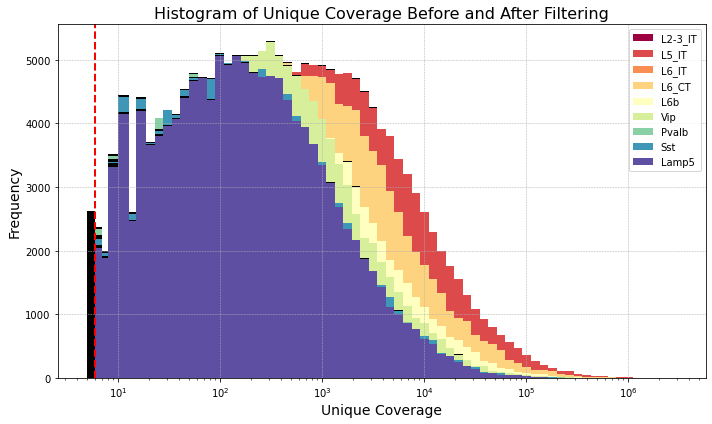

In [24]:
#Visualise filtering ->
#Plot unique coverage
#===================================
gaba_l = [ 'Vip', 'Pvalb', 'Sst', 'Lamp5']
glu_l = ['L2-3_IT', 'L5_IT', 'L6_IT', 'L6_CT', 'L6b']
name_l = glu_l + gaba_l

fig, ax = plt.subplots(figsize=(10, 6))
b = np.geomspace(5, max(sj['n_unq']), 70).astype(int)
colormap = plt.cm.get_cmap('Spectral', len(name_l))  

#PARS
min_unq = 5
min_overhang = 10
min_sjdist = 30
path = '/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/'
for x,cell in enumerate(name_l):
    sj = pd.read_csv(path + cell + '/SJ.out.tab', 
                     sep='\t', header=None, names=['chromosome', 'SJ_start', 'SJ_end', 'strand', 'intron_motif', 'annotated',
                                                     'n_unq', 'n_mult', 'overhang'])

    sj_bed = pf.STARSJ_to_bed(sj, cell, min_unq, min_overhang, min_sjdist)

    plt.hist(sj['n_unq'],bins=b, color = 'k')
    plt.hist(sj_bed.loc[::2]['n_unq'],bins=b, color=colormap(x), alpha=1, label = cell)

ax.set_xscale('log')

# Enhance plot legibility with more descriptive axis labels and a title.
ax.set_xlabel('Unique Coverage', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Histogram of Unique Coverage Before and After Filtering', fontsize=16)

# Adding a grid for easier interpretation of the plot. The 'which="both"' option includes major and minor ticks.
ax.grid(True, which="major", ls="--", linewidth=0.5)

# Adding a legend to distinguish between the original and filtered data visually.
ax.legend()
plt.axvline(min_unq+1,0,1, c = 'red', linewidth=2, linestyle='--')
# This command adjusts the subplot params so that the subplot(s) fits in the figure area.
plt.tight_layout()

# Display the plot
plt.show()

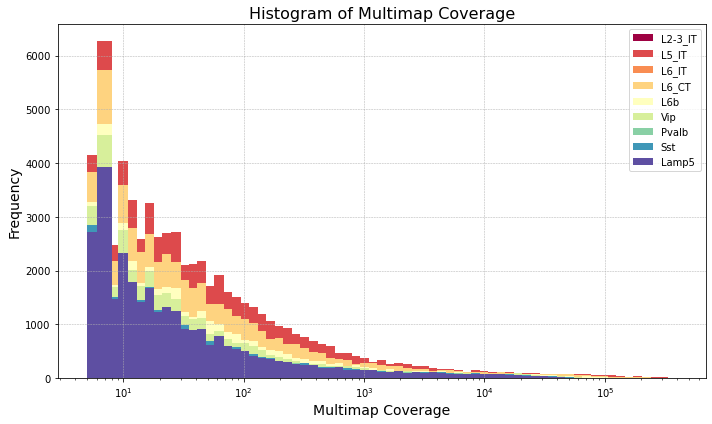

In [25]:
#Visualise 
#Plot multi coverage
#===================================
gaba_l = [ 'Vip', 'Pvalb', 'Sst', 'Lamp5']
glu_l = ['L2-3_IT', 'L5_IT', 'L6_IT', 'L6_CT', 'L6b']
name_l = glu_l + gaba_l

fig, ax = plt.subplots(figsize=(10, 6))
b = np.geomspace(5, max(sj['n_mult']), 70).astype(int)
colormap = plt.cm.get_cmap('Spectral', len(name_l))  

#PARS
min_unq = 5
min_overhang = 10
min_sjdist = 30
path = '/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/'
for x,cell in enumerate(name_l):
    sj = pd.read_csv(path + cell + '/SJ.out.tab', 
                     sep='\t', header=None, names=['chromosome', 'SJ_start', 'SJ_end', 'strand', 'intron_motif', 'annotated',
                                                     'n_unq', 'n_mult', 'overhang'])

    sj_bed = pf.STARSJ_to_bed(sj, cell, min_unq, min_overhang, min_sjdist)

    plt.hist(sj_bed.loc[::2]['n_mult'],bins=b, color=colormap(x), alpha=1, label = cell)

ax.set_xscale('log')

# Enhance plot legibility with more descriptive axis labels and a title.
ax.set_xlabel('Multimap Coverage', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Histogram of Multimap Coverage', fontsize=16)
ax.grid(True, which="major", ls="--", linewidth=0.5)

# Adding a legend to distinguish between the original and filtered data visually.
ax.legend()
# This command adjusts the subplot params so that the subplot(s) fits in the figure area.
plt.tight_layout()

# Display the plot
plt.show()

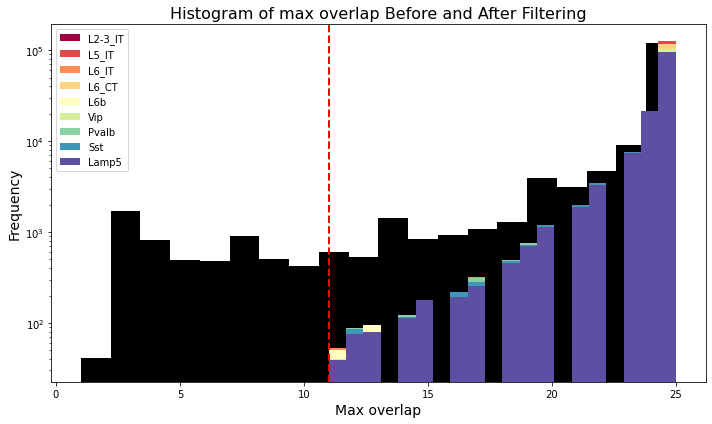

In [26]:
#Visualise filtering ->
#Plot overhang
#===================================
gaba_l = [ 'Vip', 'Pvalb', 'Sst', 'Lamp5']
glu_l = ['L2-3_IT', 'L5_IT', 'L6_IT', 'L6_CT', 'L6b']
name_l = glu_l + gaba_l

fig, ax = plt.subplots(figsize=(10, 6))
b=20
colormap = plt.cm.get_cmap('Spectral', len(name_l))  
plt.hist(sj['overhang'],bins=b, color = 'k')

#PARS
min_unq = 5
min_overhang = 10
min_sjdist = 30
path = '/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/'
for x,cell in enumerate(name_l):
    sj = pd.read_csv(path + cell + '/SJ.out.tab', 
                     sep='\t', header=None, names=['chromosome', 'SJ_start', 'SJ_end', 'strand', 'intron_motif', 'annotated',
                                                     'n_unq', 'n_mult', 'overhang'])

    sj_bed = pf.STARSJ_to_bed(sj, cell, min_unq, min_overhang, min_sjdist)
    plt.hist(sj_bed.loc[::2]['overhang'],bins=b, color=colormap(x), alpha=1, label = cell)

ax.set_yscale('log')

# Enhance plot legibility with more descriptive axis labels and a title.
ax.set_xlabel('Max overlap', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Histogram of max overlap Before and After Filtering', fontsize=16)

# Adding a grid for easier interpretation of the plot. The 'which="both"' option includes major and minor ticks.

# Adding a legend to distinguish between the original and filtered data visually.
ax.legend()
#plt.axvline(min_overhang+1,0,1, c = 'red', linewidth=2, linestyle='--')
# This command adjusts the subplot params so that the subplot(s) fits in the figure area.
plt.tight_layout()
plt.axvline(min_overhang+1,0,1, c = 'red', linewidth=2, linestyle='--')

# Display the plot
plt.show()

In [ ]:
# intersect with bed annotation to get gene names for each SJ
#==================================================

import sys
import os
import glob
import pandas as pd
import numpy as np

#use pool multiprocessing
import multiprocessing
import glob


def process_directory(c):
    run = f"""    
    tail -n +2 {out_path}/{c}/SJ.bed >  {out_path}/{c}/temp.bed
    bedtools intersect -s -wo -a {out_path}/{c}/temp.bed -b /cndd3/dburrows/DATA/annotations/genome/grcm38.p3/splice/genes.chr_1-19-X.bed > {out_path}/{c}/SJ.annotated.bed
    rm  {out_path}/{c}/temp.bed
    """
    get_ipython().run_cell_magic('bash', '', run)


#this section shows what default arguments will be run if just executing the script
if __name__ == "__main__":
    gaba_l = [ 'Vip', 'Pvalb', 'Sst', 'Lamp5']
    glu_l = ['L2-3_IT', 'L5_IT', 'L6_IT', 'L6_CT', 'L6b']
    name_l = glu_l + gaba_l

    out_path='/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/'
    
    # Create a pool of 10 worker processes
    with multiprocessing.Pool(10) as pool:
        # Map the process_directory function to each item in dir_list
        pool.map(process_directory, name_l)

    print("All tasks completed.")
    

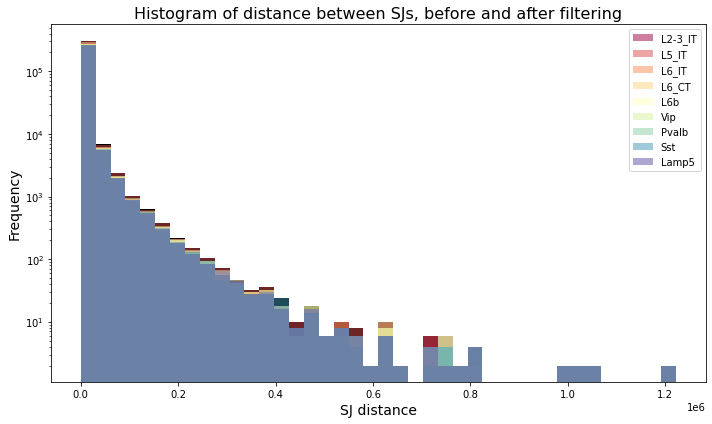

In [31]:
#Visualise filtering -> SJs further apart than their genes
#Plot overhang
#===================================
# filter SJs longer than their genes
glu_l = ['L2-3_IT', 'L5_IT', 'L6_IT', 'L6_CT', 'L6b']
gaba_l = [ 'Vip', 'Pvalb', 'Sst', 'Lamp5']
name_l = glu_l + gaba_l
smart_l = [ 'L2/3 IT','L5 IT', 'L6 IT', 'L6 CT',  'L6b', 'Vip', 'Pvalb', 'Sst', 'Lamp5']

path = '/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/'


fig, ax = plt.subplots(figsize=(10, 6))
b=40
colormap = plt.cm.get_cmap('Spectral', len(name_l))  

path = '/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/'
for i,cell in enumerate(name_l):
    curr = pd.read_csv(path+name_l[i] + '/SJ.annotated.bed',sep='\t', header=None, index_col=False,
                     names =['chromosome', 'SJ-point_start', 'SJ-point_end', 'id-SJ', 'id-unique', 'strand', 'cell',
                 'SJ_start', 'SJ_end','intron_motif', 'annotated', 'overhang', 'SJ_distance', 
                 'n_unq', 'n_mult', 'chr-anot', 'start-anot', 'end-anot', 'name-anot', 'geneid-anot', 'strand-anot', 'NA'])

    #remove any SJs that are further apart than their genes
    plt.hist(curr['SJ_distance'],bins=b, color = 'k')

for i,cell in enumerate(name_l):
    curr = pd.read_csv(path+name_l[i] + '/SJ.annotated.bed',sep='\t', header=None, index_col=False,
                     names =['chromosome', 'SJ-point_start', 'SJ-point_end', 'id-SJ', 'id-unique', 'strand', 'cell',
                 'SJ_start', 'SJ_end','intron_motif', 'annotated', 'overhang', 'SJ_distance', 
                 'n_unq', 'n_mult', 'chr-anot', 'start-anot', 'end-anot', 'name-anot', 'geneid-anot', 'strand-anot', 'NA'])

    #remove any SJs that are further apart than their genes
    new = curr.loc[(curr['end-anot']-curr['start-anot']) - curr['SJ_distance'] > 0].copy()
    plt.hist(new['SJ_distance'],bins=b, color=colormap(i), alpha=0.5, label = cell)

ax.set_yscale('log')

# Enhance plot legibility with more descriptive axis labels and a title.
ax.set_xlabel('SJ distance', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Histogram of distance between SJs, before and after filtering', fontsize=16)

# Adding a grid for easier interpretation of the plot. The 'which="both"' option includes major and minor ticks.

# Adding a legend to distinguish between the original and filtered data visually.
ax.legend()
#plt.axvline(min_overhang+1,0,1, c = 'red', linewidth=2, linestyle='--')
# This command adjusts the subplot params so that the subplot(s) fits in the figure area.
plt.tight_layout()

# Display the plot
plt.show()

In [607]:
# filter SJs longer than their genes, and normalise, and average over overlapping gene loci
#========================================================================================
glu_l = ['L2-3_IT','L5_IT', 'L6_IT', 'L6_CT', 'L6b']
gaba_l = [ 'Vip', 'Pvalb', 'Sst', 'Lamp5']
name_l = glu_l + gaba_l

path = '/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/'
for i in range(len(name_l)):
    print(name_l[i])
    curr = pd.read_csv(path+name_l[i] + '/SJ.annotated.bed',sep='\t', header=None, index_col=False,low_memory=False,
                     names =['chromosome', 'SJ-point_start', 'SJ-point_end', 'id-SJ', 'id-unique', 'strand', 'cell',
                 'SJ_start', 'SJ_end','intron_motif', 'annotated', 'overhang', 'SJ_distance', 
                 'n_unq', 'n_mult', 'chr-anot', 'start-anot', 'end-anot', 'name-anot', 'geneid-anot', 'strand-anot', 'NA'])

    #remove any SJs that are further apart than their genes
    new = curr.loc[(curr['end-anot']-curr['start-anot']) - curr['SJ_distance'] > 0].copy()

    # Read in library size + gene annotation
    gene_mat = pd.read_csv(path+name_l[i]+'/ReadsPerGene.out.tab', sep='\t', header=None, index_col=0,
                          names = ['counts', 'read1', 'read2'])
    wc = pd.read_csv(path+name_l[i]+'/library_size.txt', header=None).loc[0].values[0]

    #Confirm all genes present 
    assert len(gene_mat.loc[new['geneid-anot'].unique()]) == len(new['geneid-anot'].unique()), 'Some genes found in SJ.bed not in RNA data'

    # Normalise -> 
    # Normalised SJ usage (NSJU) = (unique SJ reads) / RPKM of gene -> SJ usage relative to gene expression + library size
    # RPKM = (gene mapped reads x 10**9) / (gene length in bp * library size)
    ge =  (gene_mat.loc[new['geneid-anot']]['counts'].values) #raw gene expression
    le = (new['end-anot']-new['start-anot']).values #gene lengths
    rpkm =  (ge * 10**9) / (le  * wc)    
    new['NSJU_rpkm']=new['n_unq'] / rpkm
    #set all infs to 0
    new.loc[np.isinf(new['NSJU_rpkm']),'NSJU_rpkm'] = 0
    #CPMs
    new['CPM']=((new['n_unq'])/wc)*1e6
    
    new['NSJU'] = (new['n_unq'] / ((ge/(le/1000))*wc))*1e9
    new.loc[np.isinf(new['NSJU']),'NSJU'] = 0
    

    #deal with SJs that overlap multiple genes -> take mean
    #=========================================================
    unq_ = np.unique(new['id-SJ'].values, return_counts=True)
    rep_ind = unq_[0][unq_[1] > 1] #repeated indeces
    unq_ind =  unq_[0][unq_[1] == 1] 
    new.index = new['id-SJ']
    new_unq = new.loc[unq_ind].copy()

    new_rep = new.loc[rep_ind].copy()
    assert len(new_rep) > len(rep_ind), 'repeated indeces are not repeated'

    #loop and merge
    newnew_rep = pd.DataFrame()
    for t,ind in enumerate(rep_ind):
        curr_ = new_rep.loc[ind]

        nsju = np.mean(curr_['NSJU'].values)
        rpkm = np.mean(curr_['NSJU_rpkm'].values)
        cpm = np.mean(curr_['CPM'].values)
        geneid_anot = "_".join(curr_['geneid-anot'].values)
        start_anot = "_".join(curr_['start-anot'].astype(str).values)
        end_anot = "_".join(curr_['end-anot'].astype(str).values)
        name_anot = "_".join(curr_['name-anot'].astype(str).values)

        hed = curr_.head(1).copy()
        hed['NSJU'] = nsju
        hed['CPM'] = cpm
        hed['NSJU_rpkm'] = rpkm
        hed['geneid-anot'] = geneid_anot
        hed['start-anot'] = end_anot
        hed['end-anot'] = end_anot
        hed['name-anot'] = name_anot
        newnew_rep = pd.concat([newnew_rep, hed])    


    #check that all rep_inds accounted for
    assert len(newnew_rep) == len(rep_ind), 'some repeat indeces not accounted for'

    comb = pd.concat([new_unq,newnew_rep])

    #check that there are no repeats
    assert len(np.unique(comb.index)) == len(comb), 'some repeat indeces remain'
    comb.reset_index(drop=True, inplace=True)

    # output bed file with raw + norm coverage
    comb.to_csv(path + name_l[i] + '/SJ.norm.bed', sep='\t', index=False)

L2-3_IT
L5_IT
L6_IT
L6_CT
L6b
Vip
Pvalb
Sst
Lamp5


L2-3_IT
L5_IT
L6_IT
L6_CT
L6b
Vip
Pvalb
Sst
Lamp5


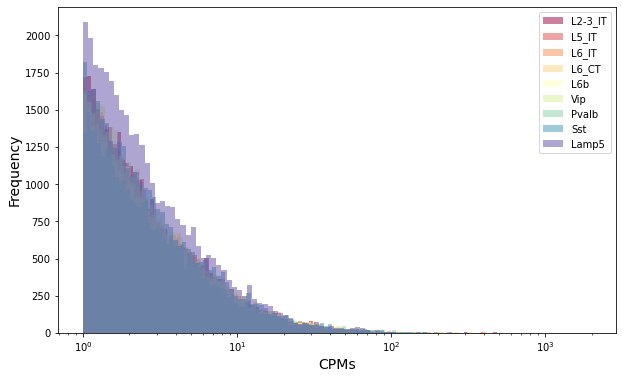

In [608]:
#Visualise stats -> CPMs of SJs across celltypes
#========================================================================================
glu_l = ['L2-3_IT','L5_IT', 'L6_IT', 'L6_CT', 'L6b']
gaba_l = [ 'Vip', 'Pvalb', 'Sst', 'Lamp5']
name_l = glu_l + gaba_l

fig, ax = plt.subplots(figsize=(10, 6))
b=40
colormap = plt.cm.get_cmap('Spectral', len(name_l))  

path = '/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/'
for i in range(len(name_l)):
    print(name_l[i])
    curr = pd.read_csv(path+name_l[i] + '/SJ.annotated.bed',sep='\t', header=None, index_col=False,low_memory=False,
                     names =['chromosome', 'SJ-point_start', 'SJ-point_end', 'id-SJ', 'id-unique', 'strand', 'cell',
                 'SJ_start', 'SJ_end','intron_motif', 'annotated', 'overhang', 'SJ_distance', 
                 'n_unq', 'n_mult', 'chr-anot', 'start-anot', 'end-anot', 'name-anot', 'geneid-anot', 'strand-anot', 'NA'])

    #remove any SJs that are further apart than their genes
    new = curr.loc[(curr['end-anot']-curr['start-anot']) - curr['SJ_distance'] > 0].copy()

    # Read in library size + gene annotation
    gene_mat = pd.read_csv(path+name_l[i]+'/ReadsPerGene.out.tab', sep='\t', header=None, index_col=0,
                          names = ['counts', 'read1', 'read2'])
    wc = pd.read_csv(path+name_l[i]+'/library_size.txt', header=None).loc[0].values[0]

    #Confirm all genes present 
    assert len(gene_mat.loc[new['geneid-anot'].unique()]) == len(new['geneid-anot'].unique()), 'Some genes found in SJ.bed not in RNA data'

    # Normalise -> 
    # Normalised SJ usage (NSJU) = (unique SJ reads) / RPKM of gene -> SJ usage relative to gene expression + library size
    # RPKM = (gene mapped reads x 10**9) / (gene length in bp * library size)
    ge =  (gene_mat.loc[new['geneid-anot']]['counts'].values) #raw gene expression
    le = (new['end-anot']-new['start-anot']).values #gene lengths
    rpkm =  (ge * 10**9) / (le  * wc)    
    new['NSJU_rpkm']=new['n_unq'] / rpkm
    #set all infs to 0
    new.loc[np.isinf(new['NSJU_rpkm']),'NSJU_rpkm'] = 0
    #CPMs
    new['CPM']=((new['n_unq'])/wc)*1e6
    
    new['NSJU'] = (new['n_unq'] / ((ge/(le/1000))*wc))*1e9
    new.loc[np.isinf(new['NSJU']),'NSJU'] = 0
    
    
        
    b=np.geomspace(1,np.max(new['CPM']),100)
    plt.hist(new['CPM'],bins=b,color=colormap(i), alpha=0.5, label = name_l[i])

ax.set_xscale('log')

# Enhance plot legibility with more descriptive axis labels and a title.
ax.set_xlabel('CPMs', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

# Adding a grid for easier interpretation of the plot. The 'which="both"' option includes major and minor ticks.

# Adding a legend to distinguish between the original and filtered data visually.
ax.legend()
# Display the plot
plt.show()


L2-3_IT
L5_IT
L6_IT
L6_CT
L6b
Vip
Pvalb
Sst
Lamp5


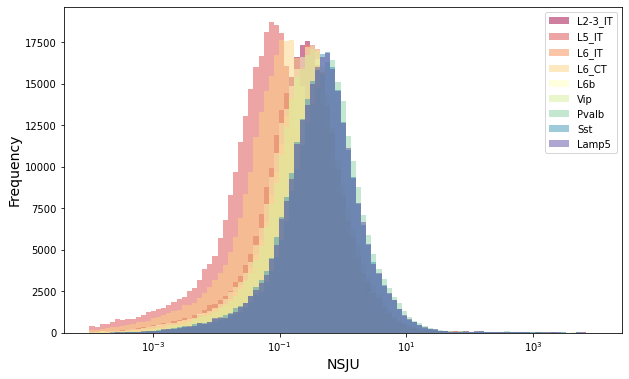

In [611]:
#Visualise stats -> NSJUs of SJs across celltypes
#========================================================================================
glu_l = ['L2-3_IT','L5_IT', 'L6_IT', 'L6_CT', 'L6b']
gaba_l = [ 'Vip', 'Pvalb', 'Sst', 'Lamp5']
name_l = glu_l + gaba_l

fig, ax = plt.subplots(figsize=(10, 6))
b=40
colormap = plt.cm.get_cmap('Spectral', len(name_l))  

path = '/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/'
for i in range(len(name_l)):
    print(name_l[i])
    curr = pd.read_csv(path+name_l[i] + '/SJ.annotated.bed',sep='\t', header=None, index_col=False,low_memory=False,
                     names =['chromosome', 'SJ-point_start', 'SJ-point_end', 'id-SJ', 'id-unique', 'strand', 'cell',
                 'SJ_start', 'SJ_end','intron_motif', 'annotated', 'overhang', 'SJ_distance', 
                 'n_unq', 'n_mult', 'chr-anot', 'start-anot', 'end-anot', 'name-anot', 'geneid-anot', 'strand-anot', 'NA'])

    #remove any SJs that are further apart than their genes
    new = curr.loc[(curr['end-anot']-curr['start-anot']) - curr['SJ_distance'] > 0].copy()

    # Read in library size + gene annotation
    gene_mat = pd.read_csv(path+name_l[i]+'/ReadsPerGene.out.tab', sep='\t', header=None, index_col=0,
                          names = ['counts', 'read1', 'read2'])
    wc = pd.read_csv(path+name_l[i]+'/library_size.txt', header=None).loc[0].values[0]

    #Confirm all genes present 
    assert len(gene_mat.loc[new['geneid-anot'].unique()]) == len(new['geneid-anot'].unique()), 'Some genes found in SJ.bed not in RNA data'

    # Normalise -> 
    # Normalised SJ usage (NSJU) = (unique SJ reads) / RPKM of gene -> SJ usage relative to gene expression + library size
    # RPKM = (gene mapped reads x 10**9) / (gene length in bp * library size)
    ge =  (gene_mat.loc[new['geneid-anot']]['counts'].values) #raw gene expression
    le = (new['end-anot']-new['start-anot']).values #gene lengths
    rpkm =  (ge * 10**9) / (le  * wc)    
    new['NSJU_rpkm']=new['n_unq'] / rpkm
    #set all infs to 0
    new.loc[np.isinf(new['NSJU_rpkm']),'NSJU_rpkm'] = 0
    #CPMs
    new['CPM']=((new['n_unq'])/wc)*1e6
    
    new['NSJU'] = (new['n_unq'] / ((ge/(le/1000))*wc))*1e9
    new.loc[np.isinf(new['NSJU']),'NSJU'] = 0
    
    
    b=np.geomspace(0.0001,1e4,100)
    plt.hist(new['NSJU'],bins=b,color=colormap(i), alpha=0.5, label = name_l[i])

ax.set_xscale('log')

# Enhance plot legibility with more descriptive axis labels and a title.
ax.set_xlabel('NSJU', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

# Adding a grid for easier interpretation of the plot. The 'which="both"' option includes major and minor ticks.

# Adding a legend to distinguish between the original and filtered data visually.
ax.legend()
# Display the plot
plt.show()


L2-3_IT
L5_IT
L6_IT
L6_CT
L6b
Vip
Pvalb
Sst
Lamp5


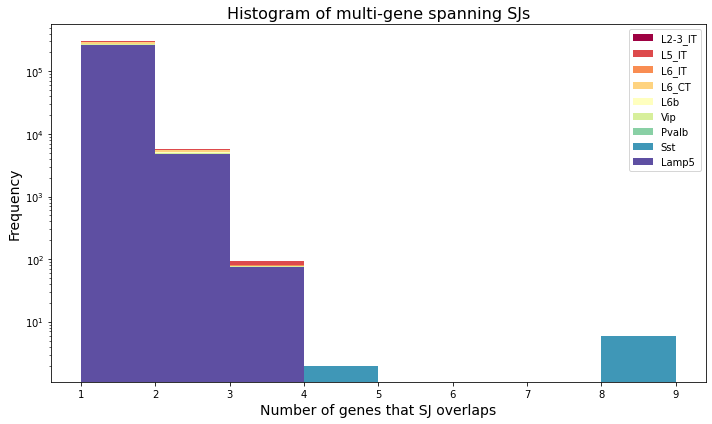

In [570]:
# Plot statistics of non-unique
# for each cell type, what how many SJs map to more than one gene
#========================================================================================
glu_l = ['L2-3_IT','L5_IT', 'L6_IT', 'L6_CT', 'L6b']
gaba_l = [ 'Vip', 'Pvalb', 'Sst', 'Lamp5']
name_l = glu_l + gaba_l

fig, ax = plt.subplots(figsize=(10, 6))
b=np.arange(1,10,1)
colormap = plt.cm.get_cmap('Spectral', len(name_l))  

path = '/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/'
for i in range(len(name_l)):
    print(name_l[i])
    curr = pd.read_csv(path+name_l[i] + '/SJ.annotated.bed',sep='\t', header=None, index_col=False,low_memory=False,
                     names =['chromosome', 'SJ-point_start', 'SJ-point_end', 'id-SJ', 'id-unique', 'strand', 'cell',
                 'SJ_start', 'SJ_end','intron_motif', 'annotated', 'overhang', 'SJ_distance', 
                 'n_unq', 'n_mult', 'chr-anot', 'start-anot', 'end-anot', 'name-anot', 'geneid-anot', 'strand-anot', 'NA'])

    #remove any SJs that are further apart than their genes
    new = curr.loc[(curr['end-anot']-curr['start-anot']) - curr['SJ_distance'] > 0].copy()

    # Read in library size + gene annotation
    gene_mat = pd.read_csv(path+name_l[i]+'/ReadsPerGene.out.tab', sep='\t', header=None, index_col=0,
                          names = ['counts', 'read1', 'read2'])
    wc = pd.read_csv(path+name_l[i]+'/library_size.txt', header=None).loc[0].values[0]

    #Confirm all genes present 
    assert len(gene_mat.loc[new['geneid-anot'].unique()]) == len(new['geneid-anot'].unique()), 'Some genes found in SJ.bed not in RNA data'

    # Normalise -> 
    # Normalised SJ usage (NSJU) = (unique SJ reads) / RPKM of gene -> SJ usage relative to gene expression + library size
    # RPKM = (gene mapped reads x 10**9) / (gene length in bp * library size)
    ge =  (gene_mat.loc[new['geneid-anot']]['counts'].values) #raw gene expression
    le = (new['end-anot']-new['start-anot']).values #gene lengths
    rpkm =  (ge * 10**9) / (le  * wc)    
    new['NSJU_rpkm']=new['n_unq'] / rpkm
    #set all infs to 0
    new.loc[np.isinf(new['NSJU_rpkm']),'NSJU_rpkm'] = 0
    #CPMs
    new['CPM']=((new['n_unq'])/wc)*1e6
    
    new['NSJU'] = (new['n_unq'] / ((ge/(le/1000))*wc))*1e6
    new.loc[np.isinf(new['NSJU']),'NSJU'] = 0
    
    #deal with SJs that overlap multiple genes -> take mean
    #=========================================================
    unq_ = np.unique(new['id-SJ'].values, return_counts=True)
    rep_ind = unq_[0][unq_[1] > 1] #repeated indeces
    unq_ind =  unq_[0][unq_[1] == 1] 
    
    plt.hist(unq_[1],bins=b, color=colormap(i), alpha=1, label = name_l[i])

ax.set_yscale('log')

# Enhance plot legibility with more descriptive axis labels and a title.
ax.set_xlabel('Number of genes that SJ overlaps', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Histogram of multi-gene spanning SJs', fontsize=16)

# Adding a grid for easier interpretation of the plot. The 'which="both"' option includes major and minor ticks.

# Adding a legend to distinguish between the original and filtered data visually.
ax.legend()
#plt.axvline(min_overhang+1,0,1, c = 'red', linewidth=2, linestyle='--')
# This command adjusts the subplot params so that the subplot(s) fits in the figure area.
plt.tight_layout()

# Display the plot
plt.show()


In [737]:
# Group filter -> mean SS usage + SD + ncell coverage
#======================================

#Filter out low variable genes, low mean count, low cell coverage????
# normalise
#======================================


glu_l = ['L2-3_IT', 'L5_IT', 'L6_IT', 'L6_CT', 'L6b']
gaba_l = [ 'Vip', 'Pvalb', 'Sst', 'Lamp5']
name_l = glu_l + gaba_l


path = '/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/'
tot=pd.DataFrame()
for i in range(len(name_l)):
    print(name_l[i])
    curr = pd.read_csv(path+name_l[i] + '/SJ.norm.bed',sep='\t', index_col=False,low_memory=False)
    tot = pd.concat([tot, curr])
tot = tot.reset_index(drop=True)

#Scale??
normal = np.log(tot['NSJU']+1)
z_nsju = (normal - np.mean(normal))/np.std(normal)
tot['z_NSJU_log'] = z_nsju
tot['z_NSJU'] = (tot['NSJU'] - np.mean(tot['NSJU']))/np.std(tot['NSJU'])


L2-3_IT
L5_IT
L6_IT
L6_CT
L6b
Vip
Pvalb
Sst
Lamp5


In [572]:
#how many cells cover each SJ
counts_ = tot.groupby('id-SJ').count()['NA']
counts_

id-SJ
chr10100016036100051845+acceptor    8
chr10100016036100051845+donor       8
chr10100016156100051845+acceptor    6
chr10100016156100051845+donor       6
chr10100051960100064083+acceptor    9
                                   ..
chrX99886879992888+donor            3
chrX99930989994400+acceptor         3
chrX99930989994400+donor            3
chrX99976177100309993+acceptor      2
chrX99976177100309993+donor         2
Name: NA, Length: 346824, dtype: int64

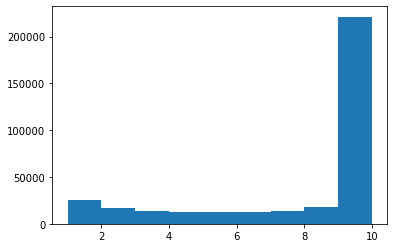

In [573]:
#Compute unique statistics -> distribution of celltypes covering each SJ site
#MAKE PLOT
plt.hist(counts_,bins=np.arange(1,11,1))
plt.show()

In [574]:
#what is the mean unq reads
mean_reads = tot.groupby('id-SJ').mean()['n_unq']
mean_reads

id-SJ
chr10100016036100051845+acceptor    316.125000
chr10100016036100051845+donor       316.125000
chr10100016156100051845+acceptor     39.333333
chr10100016156100051845+donor        39.333333
chr10100051960100064083+acceptor    513.888889
                                       ...    
chrX99886879992888+donor             20.000000
chrX99930989994400+acceptor          25.666667
chrX99930989994400+donor             25.666667
chrX99976177100309993+acceptor       18.000000
chrX99976177100309993+donor          18.000000
Name: n_unq, Length: 346824, dtype: float64

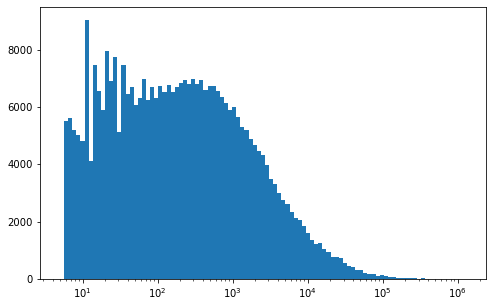

In [575]:
#MAKE PLOT
fig,ax = plt.subplots(figsize=(8,5))
plt.hist(mean_reads.values.astype(int), bins=np.geomspace(5,np.max(mean_reads.values.astype(int)),100))
plt.xscale('log')
plt.show()

In [615]:
#what is the mean CPM per SJ
mean_reads = tot.groupby('id-SJ').mean()['CPM']
mean_reads

id-SJ
chr10100016036100051845+acceptor    0.089978
chr10100016036100051845+donor       0.089978
chr10100016156100051845+acceptor    0.013127
chr10100016156100051845+donor       0.013127
chr10100051960100064083+acceptor    0.153381
                                      ...   
chrX99886879992888+donor            0.010994
chrX99930989994400+acceptor         0.013503
chrX99930989994400+donor            0.013503
chrX99976177100309993+acceptor      0.006375
chrX99976177100309993+donor         0.006375
Name: CPM, Length: 346824, dtype: float64

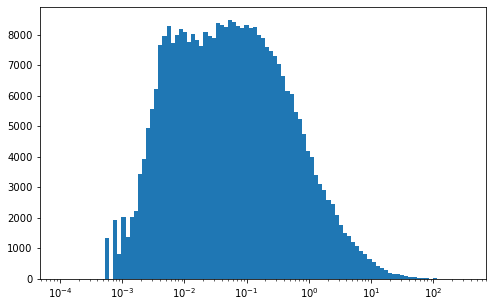

In [616]:
#MAKE PLOT
fig,ax = plt.subplots(figsize=(8,5))
plt.hist(mean_reads.values, bins=np.geomspace(0.0001,np.max(mean_reads.values.astype(int)),100))
plt.xscale('log')
plt.show()

In [762]:
#what is the mean unq reads
mean_reads = tot.groupby('id-SJ').mean()['NSJU']
mean_reads

id-SJ
chr10100016036100051845+acceptor    0.444782
chr10100016036100051845+donor       0.444782
chr10100016156100051845+acceptor    0.099238
chr10100016156100051845+donor       0.099238
chr10100051960100064083+acceptor    1.014061
                                      ...   
chrX99886879992888+donor            0.754127
chrX99930989994400+acceptor         0.633937
chrX99930989994400+donor            0.633937
chrX99976177100309993+acceptor      1.998787
chrX99976177100309993+donor         1.998787
Name: NSJU, Length: 346824, dtype: float64

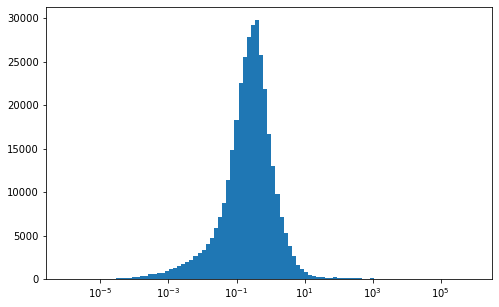

In [763]:
#MAKE PLOT
fig,ax = plt.subplots(figsize=(8,5))
plt.hist(mean_reads.values, bins=np.geomspace(0.000001,np.max(mean_reads.values.astype(int)),100))
plt.xscale('log')
plt.show()

In [767]:
np.mean(tot['NSJU']),np.median(tot['NSJU'])

(138.34353820506897, 0.2350961297336643)

In [775]:
#what is the mean unq reads
mean_reads = tot.groupby('id-SJ').mean()['z_NSJU_log']
mean_reads

id-SJ
chr10100016036100051845+acceptor   -0.068265
chr10100016036100051845+donor      -0.068265
chr10100016156100051845+acceptor   -0.496759
chr10100016156100051845+donor      -0.496759
chr10100051960100064083+acceptor    0.413003
                                      ...   
chrX99886879992888+donor            0.166809
chrX99930989994400+acceptor         0.122255
chrX99930989994400+donor            0.122255
chrX99976177100309993+acceptor      0.841183
chrX99976177100309993+donor         0.841183
Name: z_NSJU_log, Length: 346824, dtype: float64

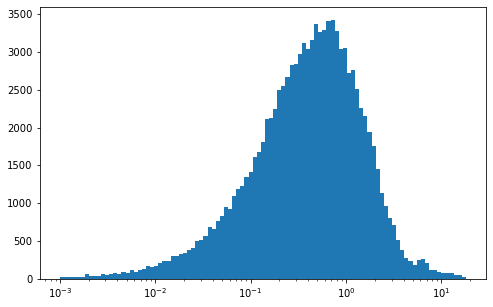

In [779]:
#MAKE PLOT
fig,ax = plt.subplots(figsize=(8,5))
plt.hist(mean_reads.values, np.geomspace(0.001,np.max(mean_reads.values.astype(int)),100))
plt.xscale('log')
plt.show()

In [781]:
np.mean(tot['z_NSJU_log']),np.median(tot['z_NSJU_log'])

(8.915018233161569e-15, -0.2916646104450309)

In [636]:
#what is the NSJU std
std_nsju = tot.groupby('id-SJ').std()['z_NSJU']
std_nsju

id-SJ
chr10100016036100051845+acceptor    0.377249
chr10100016036100051845+donor       0.377249
chr10100016156100051845+acceptor    0.197284
chr10100016156100051845+donor       0.197284
chr10100051960100064083+acceptor    0.630240
                                      ...   
chrX99886879992888+donor            0.778713
chrX99930989994400+acceptor         0.510676
chrX99930989994400+donor            0.510676
chrX99976177100309993+acceptor      1.586723
chrX99976177100309993+donor         1.586723
Name: z_NSJU, Length: 346824, dtype: float64

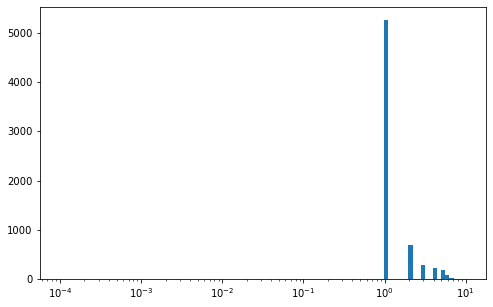

In [638]:
#MAKE PLOT
fig,ax = plt.subplots(figsize=(8,5))
plt.hist(std_nsju.values.astype(int), bins=np.geomspace(0.0001,np.max(std_nsju.values.astype(int)),100))
plt.xscale('log')
#plt.xlim(5,500)
plt.show()

In [782]:
#Create vector representation of each SJ
#======================================
pivoted_df = tot.pivot_table(index='cell', columns='id-SJ', values='NSJU', fill_value=0)
pivoted_df = pivoted_df.iloc[:,::2] #remove repeated values


#do statistics
#==================================
#DECOMP -> NSJU

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(pivoted_df)
pca = PCA(n_components=3)
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)

loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=pivoted_df.columns)


# Convert the PCA components to a DataFrame (for easier handling)
df_pca = pd.DataFrame(data = df_pca, columns = ['PC1', 'PC2', 'PC3'],
                     index = [pivoted_df.index])



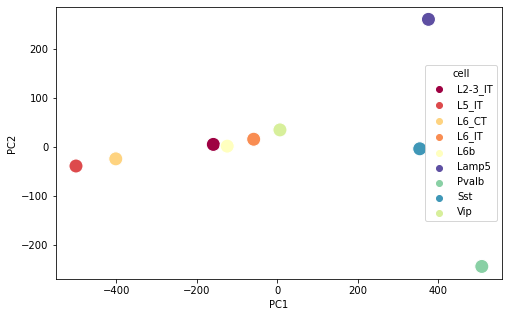

In [783]:
#DECOMP -> NSJU
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_pca is your DataFrame and name_l is a list of unique values from the 'cell' column
unique_cells = name_l  # or df_pca['cell'].unique() if name_l is not defined
colormap = plt.cm.get_cmap('Spectral', len(unique_cells))

# Generate colors from the colormap
colors = [colormap(i) for i in range(colormap.N)]

# Create a dictionary mapping each cell type to a color
palette = dict(zip(unique_cells, colors))

# Create the scatter plot
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="cell", s=200, palette=palette)

# Show the plot
plt.show()

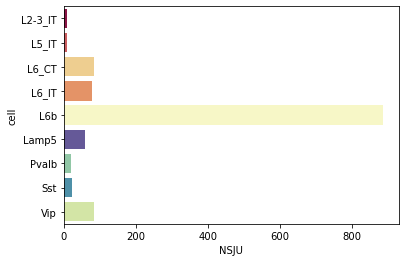

In [784]:
import seaborn as sns
ok = tot.groupby('cell').mean()
sns.barplot(data = ok, x='NSJU', y=ok.index, palette=palette)
plt.show()

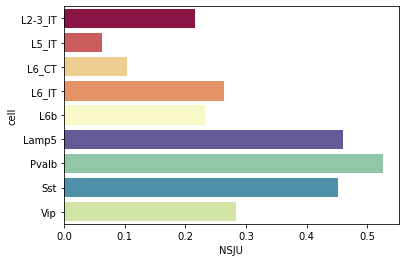

In [1034]:
import seaborn as sns
ok = tot.groupby('cell').median()
sns.barplot(data = ok, x='NSJU', y=ok.index, palette=palette)
plt.show()

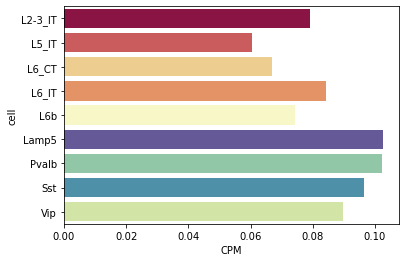

In [1040]:
import seaborn as sns
ok = tot.groupby('cell').median()
sns.barplot(data = ok, x='CPM', y=ok.index, palette=palette)
plt.show()

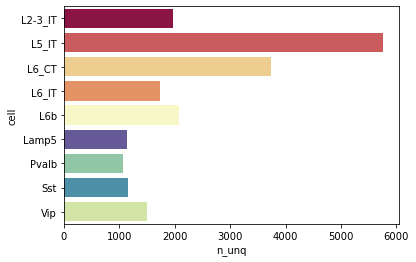

In [786]:
import seaborn as sns
ok = tot.groupby('cell').mean()
sns.barplot(data = ok, x='n_unq', y=ok.index, palette=palette)
plt.show()

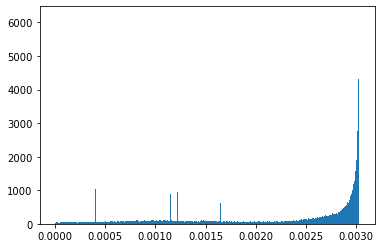

In [787]:
#PC1 loadings
plt.hist(np.abs(loadings['PC1']), bins=1000)
plt.show()

In [899]:
sub_ind = loadings.index[np.abs(loadings['PC1']) > np.percentile(np.abs(loadings['PC1']), 98) ]
nec = tot.copy()
nec.index = nec['id-SJ']
gene_unq = nec.loc[sub_ind]['name-anot'].unique()

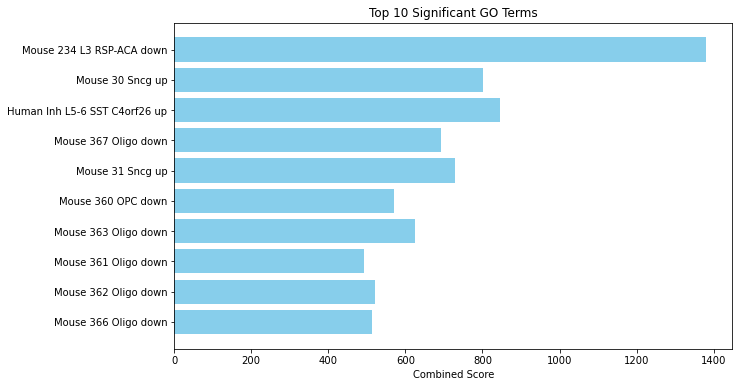

In [900]:
import gseapy as gp

# Your list of genes of interest
gene_list = list(gene_unq)# Add your genes here

# Run Enrichr
# Choose the gene set libraries you are interested in.
# For GO analysis, you can use 'GO_Biological_Process_2021', 'GO_Molecular_Function_2021', and 'GO_Cellular_Component_2021' among others.
enrichr_results = gp.enrichr(gene_list=gene_list,
                             gene_sets=['Allen_Brain_Atlas_10x_scRNA_2021'],
                             outdir='enrichr_GO_results')

# To see the top results from the enrichment analysis
# Assuming 'enrichr_results' contains your results
# Extracting the first result as an example, adjust as necessary
df = enrichr_results.results

# Filter for significant terms if needed, e.g., by adjusted p-value
df_filtered = df[df['Adjusted P-value'] < 0.05]

# Sort values for better visualization, if you have many terms consider showing top N
df_filtered_sorted = df_filtered.sort_values(by='Adjusted P-value', ascending=True)

# Plotting
import matplotlib.pyplot as plt

# Selecting top N significant terms for visualization
top_n = df_filtered_sorted.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_n['Term'], top_n['Combined Score'], color='skyblue')
plt.xlabel('Combined Score')
plt.title('Top 10 Significant GO Terms')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score on top
plt.show()

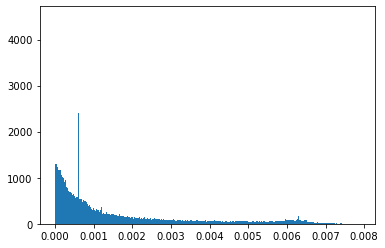

In [892]:
#PC2 loadings
plt.hist(np.abs(loadings['PC2']), bins=1000)
plt.show()

In [897]:
sub_ind = loadings.index[np.abs(loadings['PC2']) > np.percentile(np.abs(loadings['PC2']), 98) ]
nec = tot.copy()
nec.index = nec['id-SJ']
gene_unq = nec.loc[sub_ind]['name-anot'].unique()

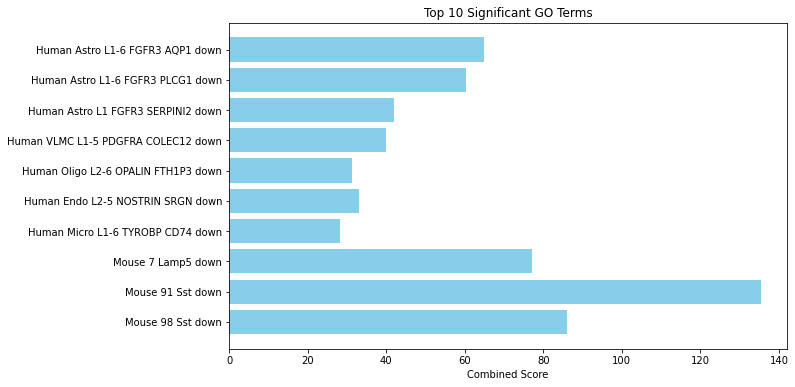

In [898]:
import gseapy as gp

# Your list of genes of interest
gene_list = list(gene_unq)# Add your genes here

# Run Enrichr
# Choose the gene set libraries you are interested in.
# For GO analysis, you can use 'GO_Biological_Process_2021', 'GO_Molecular_Function_2021', and 'GO_Cellular_Component_2021' among others.
enrichr_results = gp.enrichr(gene_list=gene_list,
                             gene_sets=['Allen_Brain_Atlas_10x_scRNA_2021'],
                             outdir='enrichr_GO_results')

# To see the top results from the enrichment analysis
# Assuming 'enrichr_results' contains your results
# Extracting the first result as an example, adjust as necessary
df = enrichr_results.results

# Filter for significant terms if needed, e.g., by adjusted p-value
df_filtered = df[df['Adjusted P-value'] < 0.05]

# Sort values for better visualization, if you have many terms consider showing top N
df_filtered_sorted = df_filtered.sort_values(by='Adjusted P-value', ascending=True)

# Plotting
import matplotlib.pyplot as plt

# Selecting top N significant terms for visualization
top_n = df_filtered_sorted.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_n['Term'], top_n['Combined Score'], color='skyblue')
plt.xlabel('Combined Score')
plt.title('Top 10 Significant GO Terms')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score on top
plt.show()

In [662]:
#Create vector representation of each SJ -> CPM
#======================================
pivoted_df = tot.pivot_table(index='cell', columns='id-SJ', values='NSJU_rpkm', fill_value=0)
pivoted_df = pivoted_df.iloc[:,::2] #remove repeated values


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(pivoted_df)
pca = PCA(n_components=3)
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)

loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=pivoted_df.columns)


# Convert the PCA components to a DataFrame (for easier handling)
df_pca = pd.DataFrame(data = df_pca, columns = ['PC1', 'PC2', 'PC3'],
                     index = [pivoted_df.index])


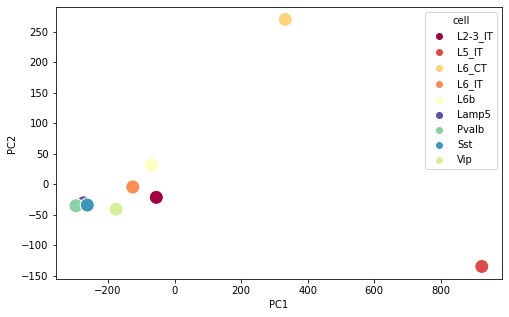

In [663]:
#DECOMP -> CPM
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_pca is your DataFrame and name_l is a list of unique values from the 'cell' column
unique_cells = name_l  # or df_pca['cell'].unique() if name_l is not defined
colormap = plt.cm.get_cmap('Spectral', len(unique_cells))

# Generate colors from the colormap
colors = [colormap(i) for i in range(colormap.N)]

# Create a dictionary mapping each cell type to a color
palette = dict(zip(unique_cells, colors))

# Create the scatter plot
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="cell", s=200, palette=palette)

# Show the plot
plt.show()


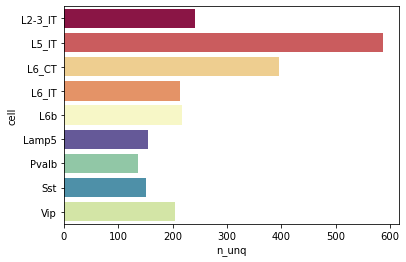

In [1033]:
import seaborn as sns
ok = tot.groupby('cell').median()
sns.barplot(data = ok, x='n_unq', y=ok.index, palette=palette)
plt.show()

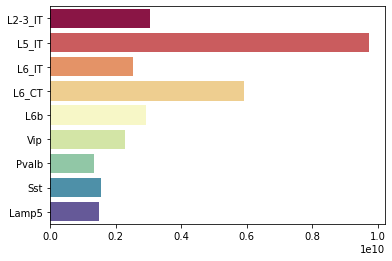

In [560]:
#plot library size
glu_l = ['L2-3_IT', 'L5_IT', 'L6_IT', 'L6_CT', 'L6b']
gaba_l = [ 'Vip', 'Pvalb', 'Sst', 'Lamp5']
name_l = glu_l + gaba_l

_l = []
path = '/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/'
for i in range(len(name_l)):
    curr_ = glob.glob(path+name_l[i]+'/*library*')
    ok = pd.read_csv(curr_[0], header=None).values[0][0]
    _l.append(ok)
    
sns.barplot(y=name_l, x=_l, palette=palette)
plt.show()

In [538]:
#Create vector representation of each SJ -> CPM
#======================================
pivoted_df = tot.pivot_table(index='cell', columns='id-SJ', values='CPM', fill_value=0)
pivoted_df = pivoted_df.iloc[:,::2] #remove repeated values


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(pivoted_df)
pca = PCA(n_components=3)
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)

loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=pivoted_df.columns)


# Convert the PCA components to a DataFrame (for easier handling)
df_pca = pd.DataFrame(data = df_pca, columns = ['PC1', 'PC2', 'PC3'],
                     index = [pivoted_df.index])


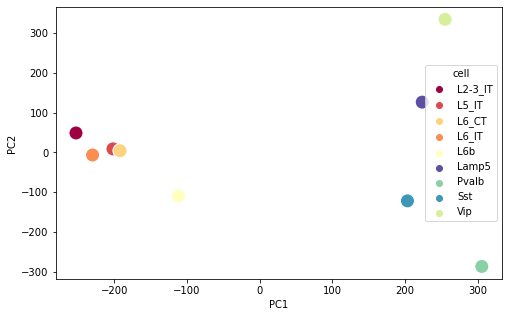

In [539]:
#DECOMP -> CPM
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_pca is your DataFrame and name_l is a list of unique values from the 'cell' column
unique_cells = name_l  # or df_pca['cell'].unique() if name_l is not defined
colormap = plt.cm.get_cmap('Spectral', len(unique_cells))

# Generate colors from the colormap
colors = [colormap(i) for i in range(colormap.N)]

# Create a dictionary mapping each cell type to a color
palette = dict(zip(unique_cells, colors))

# Create the scatter plot
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="cell", s=200, palette=palette)

# Show the plot
plt.show()


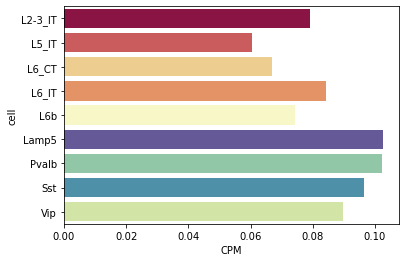

In [1035]:
import seaborn as sns
ok = tot.groupby('cell').median()
sns.barplot(data = ok, x='CPM', y=ok.index, palette=palette)
plt.show()

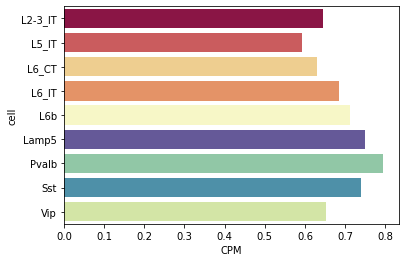

In [1036]:
import seaborn as sns
ok = tot.groupby('cell').mean()
sns.barplot(data = ok, x='CPM', y=ok.index, palette=palette)
plt.show()

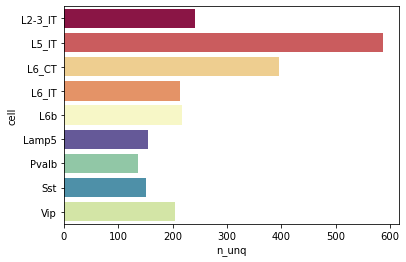

In [1038]:
import seaborn as sns
ok = tot.groupby('cell').median()
sns.barplot(data = ok, x='n_unq', y=ok.index, palette=palette)
plt.show()

In [ ]:
# quantify mean differences with cosine//ED? 
#show how changes with different parameters -> just pick some, get rough idea, split by exc vs inh.
# - Play with parameters to maximise + visualise

In [ ]:
#select gene
gene = 'Oxr1'
if gene not in _df['name-anot'].unique():
    print('Gene not found')
else:
    print(gene)
    
name_l = ['L2-3_IT', 'L5_IT', 'L6_CT', 'L6_IT', 'L6b', 'Lamp5', 'Pvalb', 'Sst', 'Vip']
#get gene expression
ge_l = []
for i in range(len(name_l)):
    print(name_l[i])
    curr = pd.read_csv(path+name_l[i] + '/SJ.annotated.bed',sep='\t', header=None, index_col=False,low_memory=False,
                     names =['chromosome', 'SJ-point_start', 'SJ-point_end', 'id-SJ', 'id-unique', 'strand', 'cell',
                 'SJ_start', 'SJ_end','intron_motif', 'annotated', 'overhang', 'SJ_distance', 
                 'n_unq', 'n_mult', 'chr-anot', 'start-anot', 'end-anot', 'name-anot', 'geneid-anot', 'strand-anot', 'NA'])

    #remove any SJs that are further apart than their genes
    new = curr.loc[(curr['end-anot']-curr['start-anot']) - curr['SJ_distance'] > 0].copy()

    # Read in library size + gene annotation
    gene_mat = pd.read_csv(path+name_l[i]+'/ReadsPerGene.out.tab', sep='\t', header=None, index_col=0,
                          names = ['counts', 'read1', 'read2'])
    ge_l.append(gene_mat.loc[new[new['name-anot'] == gene]['geneid-anot'].values[0]][0])    

curr_df = pivoted_df[_df[_df['name-anot']==gene].index]
curr_df.columns = ['SJ_' + str(i) for i in np.arange(0,len(curr_df.columns))]
curr_df.replace(0, np.nan, inplace=True)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming ge_l is a list of gene expression levels corresponding to each cell type in curr_df
ge_df = pd.DataFrame(ge_l, index=curr_df.index, columns=['Gene Expression'])

# Set up the matplotlib grid layout
plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 

# First subplot for the splice junction usage heatmap
ax0 = plt.subplot(gs[0])
sns.heatmap(curr_df, cmap="Spectral_r", cbar_kws={'label': 'NSJU'}, ax=ax0)
plt.title('Splice Junction Usage by Cell Type', fontsize=20)
plt.xlabel('Splice Junctions', fontsize=15)
plt.ylabel('Cell Types', fontsize=15)
plt.xticks(fontsize=10, rotation=90, ha="right")
plt.yticks(fontsize=10)

# Second subplot for the gene expression heatmap
ax1 = plt.subplot(gs[1])
sns.heatmap(ge_df, cmap="Spectral_r", cbar_kws={'label': 'Gene Expression'}, ax=ax1)
plt.title('Gene Expression Levels', fontsize=20)
plt.xlabel('Gene Expression', fontsize=15)
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()




In [1015]:
# cell differences at candidate genes -> compare with pachter paper 
# figure out which SJs are found in which celltypes, confirm similar expression as expected
pivoted_df = tot.pivot_table(index='cell', columns='id-SJ', values='NSJU', fill_value=0)
pivoted_df = pivoted_df.iloc[:,::2] #remove repeated values
nec = tot.copy()
nec.index = nec['id-SJ']

_df = nec.loc[pivoted_df.columns]

_df = _df[~_df.index.duplicated(keep='first')]

    

In [1020]:
pivoted_df


id-SJ,chr10100016036100051845+acceptor,chr10100016156100051845+acceptor,chr10100051960100064083+acceptor,chr10100064147100076734+acceptor,chr10100076906100079973+acceptor,chr10100080131100080856+acceptor,chr10100080941100087346+acceptor,chr10100087457100088152+acceptor,chr10100088221100089195+acceptor,chr10100089272100096017+acceptor,...,chrX99572509960013+acceptor,chrX99601939961732+acceptor,chrX99618339963590+acceptor,chrX99637539986795+acceptor,chrX9982192799845388+acceptor,chrX9984556199845959+acceptor,chrX99869059988550+acceptor,chrX99886879992888+acceptor,chrX99930989994400+acceptor,chrX99976177100309993+acceptor
cell,,,,,,,,,,,,,,,,,,,,,
L2-3_IT,0.375202,0.027890,0.660634,0.759991,0.513343,0.500269,0.497655,0.403963,0.400913,0.316372,...,0.000000,0.000000,0.000000,0.000000,0.039394,0.029546,0.000000,0.000000,0.000000,0.000000
L5_IT,0.103348,0.009308,0.170558,0.226955,0.153585,0.152216,0.147972,0.121143,0.119637,0.094313,...,0.000000,0.000000,0.000000,0.000000,0.008223,0.000000,0.000000,0.000000,0.000000,0.243144
L6_CT,0.152499,0.012592,0.307330,0.376818,0.238309,0.240175,0.249036,0.195871,0.174885,0.153432,...,0.596074,0.000000,0.000000,0.000000,0.037931,0.026552,0.000000,0.000000,0.000000,0.000000
L6_IT,0.446642,0.000000,0.721726,0.887368,0.576789,0.538337,0.597495,0.541295,0.496926,0.417063,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
L6b,0.302039,0.042857,0.630607,0.785708,0.522445,0.538771,0.481629,0.430609,0.391834,0.336732,...,0.000000,0.000000,0.000000,0.000000,0.026096,0.034795,0.000000,0.000000,0.000000,0.000000
Lamp5,0.879661,0.136285,1.821269,2.213606,1.519789,1.656075,1.519789,1.296777,1.313296,1.090284,...,2.039616,2.946111,3.172735,1.812992,0.000000,0.098606,0.000000,0.000000,0.000000,0.000000
Pvalb,1.067625,0.366498,2.852312,3.091333,1.848426,1.864361,2.071512,1.529732,1.242907,1.290711,...,3.543009,2.125806,2.834407,2.302956,0.000000,0.145845,2.480107,1.771505,1.240053,0.000000
Sst,0.000000,0.000000,1.301431,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.136134,1.826050,2.170588,1.343697,0.079787,0.150710,0.671849,0.310084,0.396218,0.000000
Vip,0.231237,0.000000,0.660677,1.354387,0.660677,1.882929,1.288320,1.288320,0.759778,0.462474,...,1.519786,1.197750,1.062155,0.971759,0.000000,0.034825,0.525428,0.180792,0.265539,3.754429


In [1021]:
nec.loc[pivoted_df.columns]

,chromosome,SJ-point_start,SJ-point_end,id-SJ,id-unique,strand,cell,SJ_start,SJ_end,intron_motif,...,end-anot,name-anot,geneid-anot,strand-anot,NA,NSJU_rpkm,CPM,NSJU,z_NSJU_log,z_NSJU
id-SJ,,,,,,,,,,,,,,,,,,,,,
chr10100016036100051845+acceptor,chr10,100051844,100051845,chr10100016036100051845+acceptor,L2-3_ITchr10100016036100051845+acceptor,+,L2-3_IT,100016036,100051845,1,...,100100413,Kitl,ENSMUSG00000019966.12,+,1,3471.453677,0.283061,0.375202,-0.111918,-0.007059
chr10100016036100051845+acceptor,chr10,100051844,100051845,chr10100016036100051845+acceptor,L5_ITchr10100016036100051845+acceptor,+,L5_IT,100016036,100051845,1,...,100100413,Kitl,ENSMUSG00000019966.12,+,1,9776.883719,0.077624,0.103348,-0.480357,-0.007073
chr10100016036100051845+acceptor,chr10,100051844,100051845,chr10100016036100051845+acceptor,L6_ITchr10100016036100051845+acceptor,+,L6_IT,100016036,100051845,1,...,100100413,Kitl,ENSMUSG00000019966.12,+,1,2885.592023,0.059407,0.446642,-0.027199,-0.007056
chr10100016036100051845+acceptor,chr10,100051844,100051845,chr10100016036100051845+acceptor,L6_CTchr10100016036100051845+acceptor,+,L6_CT,100016036,100051845,1,...,100100413,Kitl,ENSMUSG00000019966.12,+,1,5356.213946,0.055176,0.152499,-0.407450,-0.007071
chr10100016036100051845+acceptor,chr10,100051844,100051845,chr10100016036100051845+acceptor,L6bchr10100016036100051845+acceptor,+,L6b,100016036,100051845,1,...,100100413,Kitl,ENSMUSG00000019966.12,+,1,2589.317759,0.050548,0.302039,-0.203370,-0.007063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX99930989994400+acceptor,chrX,9994399,9994400,chrX99930989994400+acceptor,VipchrX99930989994400+acceptor,+,Vip,9993098,9994400,1,...,9994543,Sytl5,ENSMUSG00000054453.6,+,1,1384.539246,0.020583,0.265539,-0.250933,-0.007065
chrX99930989994400+acceptor,chrX,9994399,9994400,chrX99930989994400+acceptor,PvalbchrX99930989994400+acceptor,+,Pvalb,9993098,9994400,1,...,9994543,Sytl5,ENSMUSG00000054453.6,+,1,2225.161730,0.005226,1.240053,0.704245,-0.007015
chrX99930989994400+acceptor,chrX,9994399,9994400,chrX99930989994400+acceptor,SstchrX99930989994400+acceptor,+,Sst,9993098,9994400,1,...,9994543,Sytl5,ENSMUSG00000054453.6,+,1,970.006167,0.014700,0.396218,-0.086547,-0.007058


In [1022]:
_df


,chromosome,SJ-point_start,SJ-point_end,id-SJ,id-unique,strand,cell,SJ_start,SJ_end,intron_motif,...,end-anot,name-anot,geneid-anot,strand-anot,NA,NSJU_rpkm,CPM,NSJU,z_NSJU_log,z_NSJU
id-SJ,,,,,,,,,,,,,,,,,,,,,
chr10100016036100051845+acceptor,chr10,100051844,100051845,chr10100016036100051845+acceptor,L2-3_ITchr10100016036100051845+acceptor,+,L2-3_IT,100016036,100051845,1,...,100100413,Kitl,ENSMUSG00000019966.12,+,1,3471.453677,0.283061,0.375202,-0.111918,-0.007059
chr10100016156100051845+acceptor,chr10,100051844,100051845,chr10100016156100051845+acceptor,L2-3_ITchr10100016156100051845+acceptor,+,L2-3_IT,100016156,100051845,1,...,100100413,Kitl,ENSMUSG00000019966.12,+,1,258.040691,0.021041,0.027890,-0.598862,-0.007077
chr10100051960100064083+acceptor,chr10,100064082,100064083,chr10100051960100064083+acceptor,L2-3_ITchr10100051960100064083+acceptor,+,L2-3_IT,100051960,100064083,1,...,100100413,Kitl,ENSMUSG00000019966.12,+,1,6112.338878,0.498398,0.660634,0.203573,-0.007045
chr10100064147100076734+acceptor,chr10,100076733,100076734,chr10100064147100076734+acceptor,L2-3_ITchr10100064147100076734+acceptor,+,L2-3_IT,100064147,100076734,1,...,100100413,Kitl,ENSMUSG00000019966.12,+,1,7031.608841,0.573355,0.759991,0.300778,-0.007040
chr10100076906100079973+acceptor,chr10,100079972,100079973,chr10100076906100079973+acceptor,L2-3_ITchr10100076906100079973+acceptor,+,L2-3_IT,100076906,100079973,1,...,100100413,Kitl,ENSMUSG00000019966.12,+,1,4749.561476,0.387277,0.513343,0.048204,-0.007052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX9984556199845959+acceptor,chrX,99845958,99845959,chrX9984556199845959+acceptor,L2-3_ITchrX9984556199845959+acceptor,+,L2-3_IT,99845561,99845959,1,...,99848790,Tmem28,ENSMUSG00000071719.2,+,1,273.363512,0.001973,0.029546,-0.596169,-0.007077
chrX99869059988550+acceptor,chrX,9988549,9988550,chrX99869059988550+acceptor,VipchrX99869059988550+acceptor,+,Vip,9986905,9988550,1,...,9994543,Sytl5,ENSMUSG00000054453.6,+,1,2739.620209,0.040728,0.525428,0.061510,-0.007052
chrX99886879992888+acceptor,chrX,9992887,9992888,chrX99886879992888+acceptor,VipchrX99886879992888+acceptor,+,Vip,9988687,9992888,1,...,9994543,Sytl5,ENSMUSG00000054453.6,+,1,942.665018,0.014014,0.180792,-0.366879,-0.007069


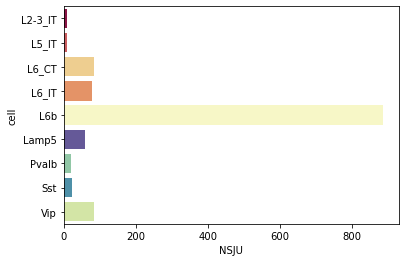

In [1013]:
import seaborn as sns
ok = tot.groupby('cell').mean()
sns.barplot(data = ok, x='NSJU', y=ok.index, palette=palette)
plt.show()

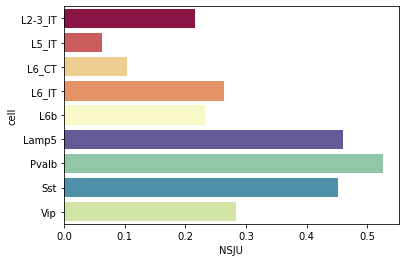

In [1032]:
import seaborn as sns
ok = tot.groupby('cell').median()
sns.barplot(data = ok, x='NSJU', y=ok.index, palette=palette)
plt.show()

In [ ]:
curr

In [ ]:
plt.hist()

Egr1


/tmp/ipykernel_1520412/1953523733.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df.replace(0, np.nan, inplace=True)


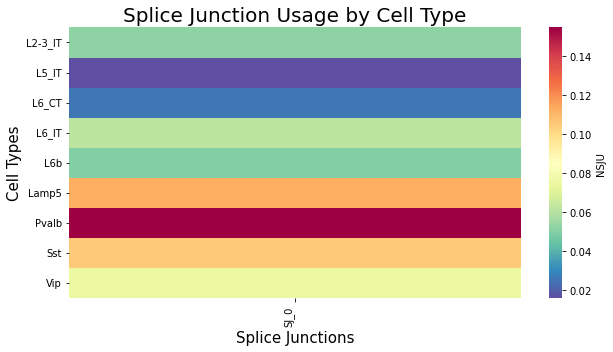

In [1031]:
#select gene
gene = 'Egr1'
if gene not in _df['name-anot'].unique():
    print('Gene not found')
else:
    print(gene)
curr_df = pivoted_df[_df[_df['name-anot']==gene].index]
curr_df.columns = ['SJ_' + str(i) for i in np.arange(0,len(curr_df.columns))]
curr_df.replace(0, np.nan, inplace=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))  # Scale the figure size for better visibility
ax = sns.heatmap(curr_df, cmap="Spectral_r", cbar_kws={'label': 'NSJU'})  # Choose a color map
plt.title('Splice Junction Usage by Cell Type', fontsize=20)  # Add a title
plt.xlabel('Splice Junctions', fontsize=15)  # Label the x-axis
plt.ylabel('Cell Types', fontsize=15)  # Label the y-axis
plt.xticks(fontsize=10, rotation=90, ha="right")  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)  # Adjust y-axis labels size
plt.tight_layout()  # Fit everything nicely into the figure
plt.show()


Stxbp2
L2-3_IT
L5_IT
L6_CT
L6_IT
L6b
Lamp5
Pvalb
Sst
Vip


/tmp/ipykernel_1520412/4143959764.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df.replace(0, np.nan, inplace=True)


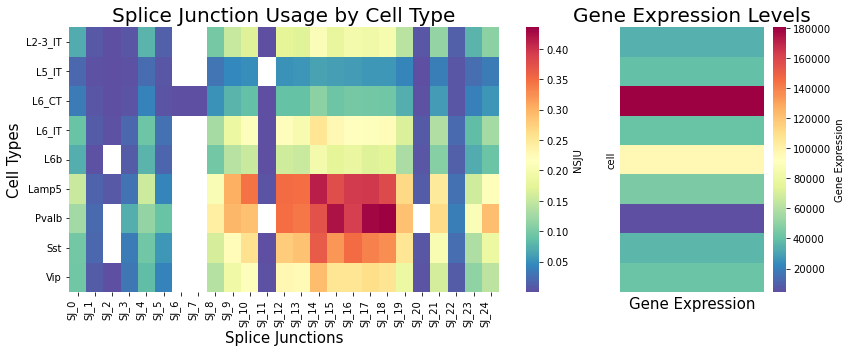

In [1000]:
#select gene
gene = 'Stxbp2'
if gene not in _df['name-anot'].unique():
    print('Gene not found')
else:
    print(gene)
    
name_l = ['L2-3_IT', 'L5_IT', 'L6_CT', 'L6_IT', 'L6b', 'Lamp5', 'Pvalb', 'Sst', 'Vip']
#get gene expression
ge_l = []
for i in range(len(name_l)):
    print(name_l[i])
    curr = pd.read_csv(path+name_l[i] + '/SJ.annotated.bed',sep='\t', header=None, index_col=False,low_memory=False,
                     names =['chromosome', 'SJ-point_start', 'SJ-point_end', 'id-SJ', 'id-unique', 'strand', 'cell',
                 'SJ_start', 'SJ_end','intron_motif', 'annotated', 'overhang', 'SJ_distance', 
                 'n_unq', 'n_mult', 'chr-anot', 'start-anot', 'end-anot', 'name-anot', 'geneid-anot', 'strand-anot', 'NA'])

    #remove any SJs that are further apart than their genes
    new = curr.loc[(curr['end-anot']-curr['start-anot']) - curr['SJ_distance'] > 0].copy()

    # Read in library size + gene annotation
    gene_mat = pd.read_csv(path+name_l[i]+'/ReadsPerGene.out.tab', sep='\t', header=None, index_col=0,
                          names = ['counts', 'read1', 'read2'])
    ge_l.append(gene_mat.loc[new[new['name-anot'] == gene]['geneid-anot'].values[0]][0])    

curr_df = pivoted_df[_df[_df['name-anot']==gene].index]
curr_df.columns = ['SJ_' + str(i) for i in np.arange(0,len(curr_df.columns))]
curr_df.replace(0, np.nan, inplace=True)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming ge_l is a list of gene expression levels corresponding to each cell type in curr_df
ge_df = pd.DataFrame(ge_l, index=curr_df.index, columns=['Gene Expression'])

# Set up the matplotlib grid layout
plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 

# First subplot for the splice junction usage heatmap
ax0 = plt.subplot(gs[0])
sns.heatmap(curr_df, cmap="Spectral_r", cbar_kws={'label': 'NSJU'}, ax=ax0)
plt.title('Splice Junction Usage by Cell Type', fontsize=20)
plt.xlabel('Splice Junctions', fontsize=15)
plt.ylabel('Cell Types', fontsize=15)
plt.xticks(fontsize=10, rotation=90, ha="right")
plt.yticks(fontsize=10)

# Second subplot for the gene expression heatmap
ax1 = plt.subplot(gs[1])
sns.heatmap(ge_df, cmap="Spectral_r", cbar_kws={'label': 'Gene Expression'}, ax=ax1)
plt.title('Gene Expression Levels', fontsize=20)
plt.xlabel('Gene Expression', fontsize=15)
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()




Slc17a7


/tmp/ipykernel_1520412/4294656776.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df.replace(0, np.nan, inplace=True)


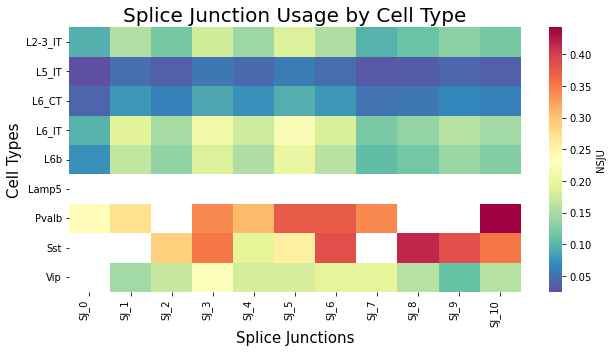

In [1005]:
#select gene
gene = 'Slc17a7'
if gene not in _df['name-anot'].unique():
    print('Gene not found')
else:
    print(gene)
curr_df = pivoted_df[_df[_df['name-anot']==gene].index]
curr_df.columns = ['SJ_' + str(i) for i in np.arange(0,len(curr_df.columns))]
curr_df.replace(0, np.nan, inplace=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))  # Scale the figure size for better visibility
ax = sns.heatmap(curr_df, cmap="Spectral_r", cbar_kws={'label': 'NSJU'})  # Choose a color map
plt.title('Splice Junction Usage by Cell Type', fontsize=20)  # Add a title
plt.xlabel('Splice Junctions', fontsize=15)  # Label the x-axis
plt.ylabel('Cell Types', fontsize=15)  # Label the y-axis
plt.xticks(fontsize=10, rotation=90, ha="right")  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)  # Adjust y-axis labels size
plt.tight_layout()  # Fit everything nicely into the figure
plt.show()


Slc17a6


/tmp/ipykernel_1520412/3387303671.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df.replace(0, np.nan, inplace=True)


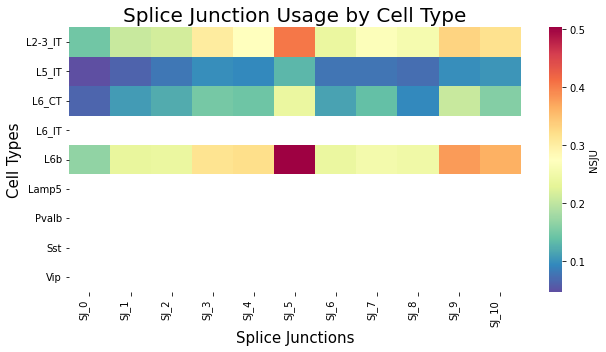

In [1004]:
#select gene
gene = 'Slc17a6'
if gene not in _df['name-anot'].unique():
    print('Gene not found')
else:
    print(gene)
curr_df = pivoted_df[_df[_df['name-anot']==gene].index]
curr_df.columns = ['SJ_' + str(i) for i in np.arange(0,len(curr_df.columns))]
curr_df.replace(0, np.nan, inplace=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))  # Scale the figure size for better visibility
ax = sns.heatmap(curr_df, cmap="Spectral_r", cbar_kws={'label': 'NSJU'})  # Choose a color map
plt.title('Splice Junction Usage by Cell Type', fontsize=20)  # Add a title
plt.xlabel('Splice Junctions', fontsize=15)  # Label the x-axis
plt.ylabel('Cell Types', fontsize=15)  # Label the y-axis
plt.xticks(fontsize=10, rotation=90, ha="right")  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)  # Adjust y-axis labels size
plt.tight_layout()  # Fit everything nicely into the figure
plt.show()


Gad1


/tmp/ipykernel_1520412/2544878918.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df.replace(0, np.nan, inplace=True)


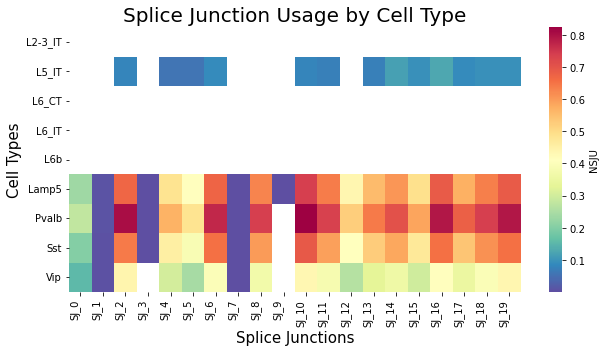

In [960]:
#select gene
gene = 'Gad1'
if gene not in _df['name-anot'].unique():
    print('Gene not found')
else:
    print(gene)
curr_df = pivoted_df[_df[_df['name-anot']==gene].index]
curr_df.columns = ['SJ_' + str(i) for i in np.arange(0,len(curr_df.columns))]
curr_df.replace(0, np.nan, inplace=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))  # Scale the figure size for better visibility
ax = sns.heatmap(curr_df, cmap="Spectral_r", cbar_kws={'label': 'NSJU'})  # Choose a color map
plt.title('Splice Junction Usage by Cell Type', fontsize=20)  # Add a title
plt.xlabel('Splice Junctions', fontsize=15)  # Label the x-axis
plt.ylabel('Cell Types', fontsize=15)  # Label the y-axis
plt.xticks(fontsize=10, rotation=90, ha="right")  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)  # Adjust y-axis labels size
plt.tight_layout()  # Fit everything nicely into the figure
plt.show()

Gad2


/tmp/ipykernel_1520412/564014660.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df.replace(0, np.nan, inplace=True)


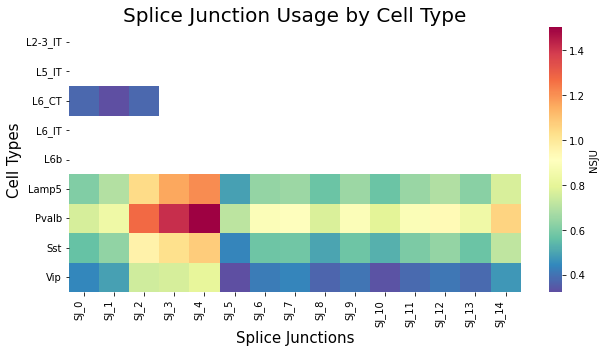

In [961]:
#select gene
gene = 'Gad2'
if gene not in _df['name-anot'].unique():
    print('Gene not found')
else:
    print(gene)
curr_df = pivoted_df[_df[_df['name-anot']==gene].index]
curr_df.columns = ['SJ_' + str(i) for i in np.arange(0,len(curr_df.columns))]
curr_df.replace(0, np.nan, inplace=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))  # Scale the figure size for better visibility
ax = sns.heatmap(curr_df, cmap="Spectral_r", cbar_kws={'label': 'NSJU'})  # Choose a color map
plt.title('Splice Junction Usage by Cell Type', fontsize=20)  # Add a title
plt.xlabel('Splice Junctions', fontsize=15)  # Label the x-axis
plt.ylabel('Cell Types', fontsize=15)  # Label the y-axis
plt.xticks(fontsize=10, rotation=90, ha="right")  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)  # Adjust y-axis labels size
plt.tight_layout()  # Fit everything nicely into the figure
plt.show()

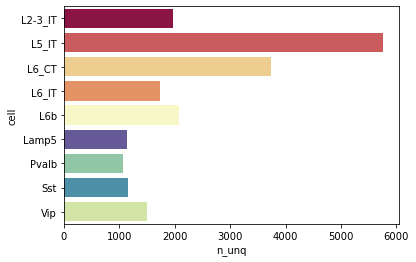

In [958]:
import seaborn as sns
ok = tot.groupby('cell').mean()
sns.barplot(data = ok, x='n_unq', y=ok.index, palette=palette)
plt.show()

In [963]:
# cell differences at candidate genes -> compare with pachter paper 
# figure out which SJs are found in which celltypes, confirm similar expression as expected
pivoted_df = tot.pivot_table(index='cell', columns='id-SJ', values='CPM', fill_value=0)
pivoted_df = pivoted_df.iloc[:,::2] #remove repeated values
nec = tot.copy()
nec.index = nec['id-SJ']

_df = nec.loc[pivoted_df.columns]

_df = _df[~_df.index.duplicated(keep='first')]


Oxr1


/tmp/ipykernel_1520412/2399085452.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df.replace(0, np.nan, inplace=True)


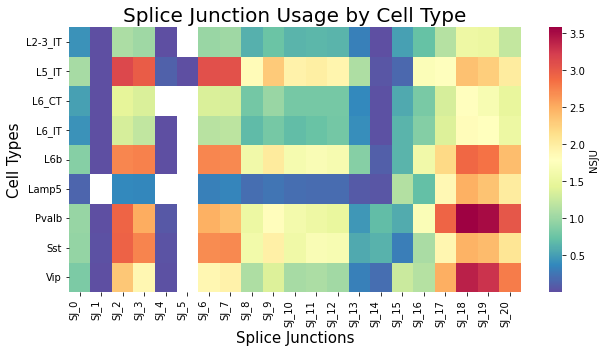

In [968]:
#select gene
gene = 'Oxr1'
if gene not in _df['name-anot'].unique():
    print('Gene not found')
else:
    print(gene)
curr_df = pivoted_df[_df[_df['name-anot']==gene].index]
curr_df.columns = ['SJ_' + str(i) for i in np.arange(0,len(curr_df.columns))]
curr_df.replace(0, np.nan, inplace=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))  # Scale the figure size for better visibility
ax = sns.heatmap(curr_df, cmap="Spectral_r", cbar_kws={'label': 'NSJU'})  # Choose a color map
plt.title('Splice Junction Usage by Cell Type', fontsize=20)  # Add a title
plt.xlabel('Splice Junctions', fontsize=15)  # Label the x-axis
plt.ylabel('Cell Types', fontsize=15)  # Label the y-axis
plt.xticks(fontsize=10, rotation=90, ha="right")  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)  # Adjust y-axis labels size
plt.tight_layout()  # Fit everything nicely into the figure
plt.show()


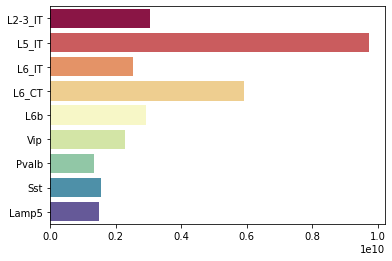

In [1010]:
#plot library size
glu_l = ['L2-3_IT', 'L5_IT', 'L6_IT', 'L6_CT', 'L6b']
gaba_l = [ 'Vip', 'Pvalb', 'Sst', 'Lamp5']
name_l = glu_l + gaba_l

_l = []
path = '/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/'
for i in range(len(name_l)):
    curr_ = glob.glob(path+name_l[i]+'/*library*')
    ok = pd.read_csv(curr_[0], header=None).values[0][0]
    _l.append(ok)
    
sns.barplot(y=name_l, x=_l, palette=palette)
plt.show()

Stxbp2


/tmp/ipykernel_1520412/4103491961.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df.replace(0, np.nan, inplace=True)


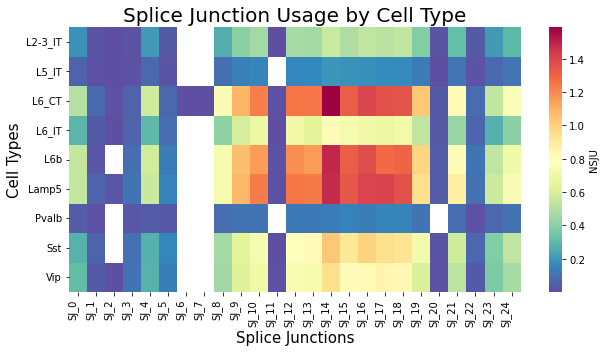

In [967]:
#select gene
gene = 'Stxbp2'
if gene not in _df['name-anot'].unique():
    print('Gene not found')
else:
    print(gene)
curr_df = pivoted_df[_df[_df['name-anot']==gene].index]
curr_df.columns = ['SJ_' + str(i) for i in np.arange(0,len(curr_df.columns))]
curr_df.replace(0, np.nan, inplace=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))  # Scale the figure size for better visibility
ax = sns.heatmap(curr_df, cmap="Spectral_r", cbar_kws={'label': 'NSJU'})  # Choose a color map
plt.title('Splice Junction Usage by Cell Type', fontsize=20)  # Add a title
plt.xlabel('Splice Junctions', fontsize=15)  # Label the x-axis
plt.ylabel('Cell Types', fontsize=15)  # Label the y-axis
plt.xticks(fontsize=10, rotation=90, ha="right")  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)  # Adjust y-axis labels size
plt.tight_layout()  # Fit everything nicely into the figure
plt.show()


Snap25


/tmp/ipykernel_1520412/1700703035.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df.replace(0, np.nan, inplace=True)


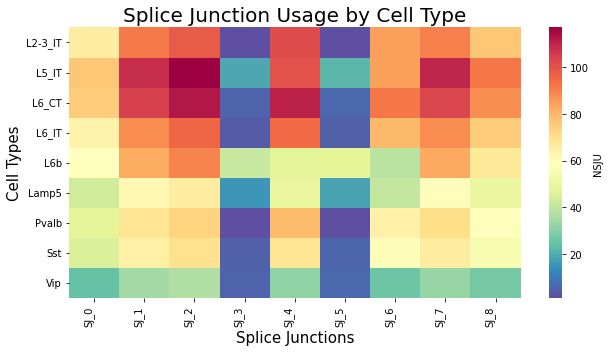

In [970]:
#select gene
gene = 'Snap25'
if gene not in _df['name-anot'].unique():
    print('Gene not found')
else:
    print(gene)
curr_df = pivoted_df[_df[_df['name-anot']==gene].index]
curr_df.columns = ['SJ_' + str(i) for i in np.arange(0,len(curr_df.columns))]
curr_df.replace(0, np.nan, inplace=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))  # Scale the figure size for better visibility
ax = sns.heatmap(curr_df, cmap="Spectral_r", cbar_kws={'label': 'NSJU'})  # Choose a color map
plt.title('Splice Junction Usage by Cell Type', fontsize=20)  # Add a title
plt.xlabel('Splice Junctions', fontsize=15)  # Label the x-axis
plt.ylabel('Cell Types', fontsize=15)  # Label the y-axis
plt.xticks(fontsize=10, rotation=90, ha="right")  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)  # Adjust y-axis labels size
plt.tight_layout()  # Fit everything nicely into the figure
plt.show()


Slc17a7


/tmp/ipykernel_1520412/4294656776.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df.replace(0, np.nan, inplace=True)


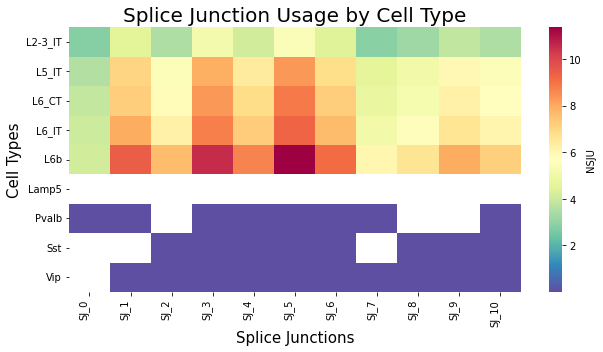

In [964]:
#select gene
gene = 'Slc17a7'
if gene not in _df['name-anot'].unique():
    print('Gene not found')
else:
    print(gene)
curr_df = pivoted_df[_df[_df['name-anot']==gene].index]
curr_df.columns = ['SJ_' + str(i) for i in np.arange(0,len(curr_df.columns))]
curr_df.replace(0, np.nan, inplace=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))  # Scale the figure size for better visibility
ax = sns.heatmap(curr_df, cmap="Spectral_r", cbar_kws={'label': 'NSJU'})  # Choose a color map
plt.title('Splice Junction Usage by Cell Type', fontsize=20)  # Add a title
plt.xlabel('Splice Junctions', fontsize=15)  # Label the x-axis
plt.ylabel('Cell Types', fontsize=15)  # Label the y-axis
plt.xticks(fontsize=10, rotation=90, ha="right")  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)  # Adjust y-axis labels size
plt.tight_layout()  # Fit everything nicely into the figure
plt.show()


Gad1


/tmp/ipykernel_1520412/2544878918.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df.replace(0, np.nan, inplace=True)


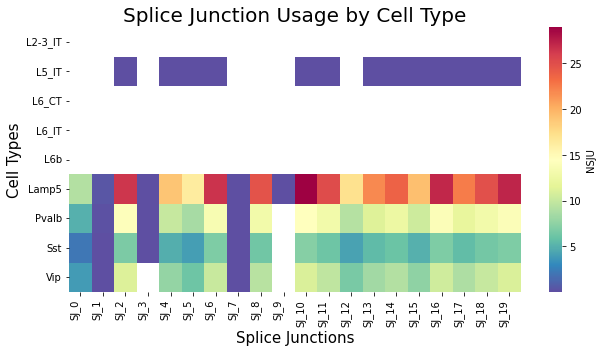

In [965]:
#select gene
gene = 'Gad1'
if gene not in _df['name-anot'].unique():
    print('Gene not found')
else:
    print(gene)
curr_df = pivoted_df[_df[_df['name-anot']==gene].index]
curr_df.columns = ['SJ_' + str(i) for i in np.arange(0,len(curr_df.columns))]
curr_df.replace(0, np.nan, inplace=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))  # Scale the figure size for better visibility
ax = sns.heatmap(curr_df, cmap="Spectral_r", cbar_kws={'label': 'NSJU'})  # Choose a color map
plt.title('Splice Junction Usage by Cell Type', fontsize=20)  # Add a title
plt.xlabel('Splice Junctions', fontsize=15)  # Label the x-axis
plt.ylabel('Cell Types', fontsize=15)  # Label the y-axis
plt.xticks(fontsize=10, rotation=90, ha="right")  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)  # Adjust y-axis labels size
plt.tight_layout()  # Fit everything nicely into the figure
plt.show()


Gad2


/tmp/ipykernel_1520412/564014660.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df.replace(0, np.nan, inplace=True)


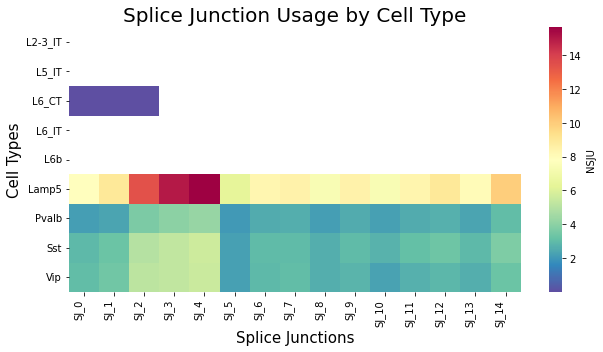

In [966]:
#select gene
gene = 'Gad2'
if gene not in _df['name-anot'].unique():
    print('Gene not found')
else:
    print(gene)
curr_df = pivoted_df[_df[_df['name-anot']==gene].index]
curr_df.columns = ['SJ_' + str(i) for i in np.arange(0,len(curr_df.columns))]
curr_df.replace(0, np.nan, inplace=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))  # Scale the figure size for better visibility
ax = sns.heatmap(curr_df, cmap="Spectral_r", cbar_kws={'label': 'NSJU'})  # Choose a color map
plt.title('Splice Junction Usage by Cell Type', fontsize=20)  # Add a title
plt.xlabel('Splice Junctions', fontsize=15)  # Label the x-axis
plt.ylabel('Cell Types', fontsize=15)  # Label the y-axis
plt.xticks(fontsize=10, rotation=90, ha="right")  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)  # Adjust y-axis labels size
plt.tight_layout()  # Fit everything nicely into the figure
plt.show()


In [ ]:
# how do i normalise -> i want splice junction use to be labelled taking into account the amount of RNA 
# and the expression for a gene

#Filter? 

In [1044]:
#save -> index? 

# Group filter -> mean SS usage + SD + ncell coverage
#======================================

#Filter out low variable genes, low mean count, low cell coverage????
# normalise
#======================================


glu_l = ['L2-3_IT', 'L5_IT', 'L6_IT', 'L6_CT', 'L6b']
gaba_l = [ 'Vip', 'Pvalb', 'Sst', 'Lamp5']
name_l = glu_l + gaba_l


path = '/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/'
tot=pd.DataFrame()
for i in range(len(name_l)):
    print(name_l[i])
    curr = pd.read_csv(path+name_l[i] + '/SJ.norm.bed',sep='\t', index_col=False,low_memory=False)
    tot = pd.concat([tot, curr])
tot = tot.reset_index(drop=True)

#Scale??
normal = np.log(tot['NSJU']+1)
z_nsju = (normal - np.mean(normal))/np.std(normal)
tot['z_NSJU_log'] = z_nsju
tot['z_NSJU'] = (tot['NSJU'] - np.mean(tot['NSJU']))/np.std(tot['NSJU'])
tot.to_csv('cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/SJ.comb.bed', sep='\t', header=True, index_col=0)

L2-3_IT
L5_IT
L6_IT
L6_CT
L6b
Vip
Pvalb
Sst
Lamp5


TypeError: to_csv() got an unexpected keyword argument 'index_col'

In [1043]:
tot

,chromosome,SJ-point_start,SJ-point_end,id-SJ,id-unique,strand,cell,SJ_start,SJ_end,intron_motif,...,end-anot,name-anot,geneid-anot,strand-anot,NA,NSJU_rpkm,CPM,NSJU,z_NSJU_log,z_NSJU
0,chr10,100051844,100051845,chr10100016036100051845+acceptor,L2-3_ITchr10100016036100051845+acceptor,+,L2-3_IT,100016036,100051845,1,...,100100413,Kitl,ENSMUSG00000019966.12,+,1,3.471454e+03,0.283061,0.375202,-0.111918,-0.007059
1,chr10,100016035,100016036,chr10100016036100051845+donor,L2-3_ITchr10100016036100051845+donor,+,L2-3_IT,100016036,100051845,1,...,100100413,Kitl,ENSMUSG00000019966.12,+,1,3.471454e+03,0.283061,0.375202,-0.111918,-0.007059
2,chr10,100051844,100051845,chr10100016156100051845+acceptor,L2-3_ITchr10100016156100051845+acceptor,+,L2-3_IT,100016156,100051845,1,...,100100413,Kitl,ENSMUSG00000019966.12,+,1,2.580407e+02,0.021041,0.027890,-0.598862,-0.007077
3,chr10,100016155,100016156,chr10100016156100051845+donor,L2-3_ITchr10100016156100051845+donor,+,L2-3_IT,100016156,100051845,1,...,100100413,Kitl,ENSMUSG00000019966.12,+,1,2.580407e+02,0.021041,0.027890,-0.598862,-0.007077
4,chr10,100064082,100064083,chr10100051960100064083+acceptor,L2-3_ITchr10100051960100064083+acceptor,+,L2-3_IT,100051960,100064083,1,...,100100413,Kitl,ENSMUSG00000019966.12,+,1,6.112339e+03,0.498398,0.660634,0.203573,-0.007045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2523473,chrX,7600619,7600620,chrX75997367600620-donor,Lamp5chrX75997367600620-donor,-,Lamp5,7599736,7600620,2,...,7605381_7605517,Ppp1r3f_Ccdc22,ENSMUSG00000039556.11_ENSMUSG00000031143.4,-,1,1.031822e+06,0.307659,451.688765,9.584710,0.016033
2523474,chrX,7600753,7600754,chrX76007547604159-acceptor,Lamp5chrX76007547604159-acceptor,-,Lamp5,7600754,7604159,2,...,7605381_7605517,Ppp1r3f_Ccdc22,ENSMUSG00000039556.11_ENSMUSG00000031143.4,-,1,1.389076e+06,0.414182,608.079929,10.081108,0.024034
2523475,chrX,7604158,7604159,chrX76007547604159-donor,Lamp5chrX76007547604159-donor,-,Lamp5,7600754,7604159,2,...,7605381_7605517,Ppp1r3f_Ccdc22,ENSMUSG00000039556.11_ENSMUSG00000031143.4,-,1,1.389076e+06,0.414182,608.079929,10.081108,0.024034
2523476,chrX,7604337,7604338,chrX76043387605243-acceptor,Lamp5chrX76043387605243-acceptor,-,Lamp5,7604338,7605243,2,...,7605381_7605517,Ppp1r3f_Ccdc22,ENSMUSG00000039556.11_ENSMUSG00000031143.4,-,1,7.877348e+05,0.234880,344.837659,9.134330,0.010565


# Encode pre-mrna + labels

In [25]:
#make practice bed file
path = '/cndd/emukamel/enformer/CEMBA_MOp_mc_bigwigs/bigwig'
cg_l = glob.glob(f'{path}/*C5_1*CG.bw')
prac = bw.open(cg_l[0])
prac_int = prac.intervals('1')
chr_ = ['chr1', 'chr1', 'chr1']
start_ = [3000800, 3001060, 3001300]
end_ = np.asarray(start_) + 1
df = pd.DataFrame({'chr': chr_, 'start': start_, 'end': end_})
df.to_csv('/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/prac/prac.SJ.out.tab.bed', header=None, index=None)

In [4]:
#Load in onehotencoding of sequence
from enformer_pytorch import GenomeIntervalDataset
bed_file = '/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/prac/prac.SJ.out.tab.bed'
fasta_file = '/cndd3/dburrows/DATA/annotations/genome/grcm38.p3/GRCm38.p3.genome_1-19-X.fa'
return_seq_indices = False #return one hot encodings

In [ ]:
#Load in sequence itself
from enformer_pytorch import GenomeIntervalDataset
bed_file = '/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/prac/prac.SJ.out.tab.bed'
fasta_file = '/cndd3/dburrows/DATA/annotations/genome/grcm38.p3/GRCm38.p3.genome_1-19-X.fa'
return_seq_indices = False #return one hot encodings

In [ ]:
self,
bed_file,
fasta_file,
filter_df_fn = identity,
chr_bed_to_fasta_map = dict(),
context_length = None,
return_seq_indices = False,
shift_augs = None,
rc_aug = False,
return_augs = False

In [ ]:
filter_train = lambda df: df.filter(pl.col('column_4') == 'train')

ds = GenomeIntervalDataset(
    bed_file = './sequences.bed',                       # bed file - columns 0, 1, 2 must be <chromosome>, <start position>, <end position>
    fasta_file = './hg38.ml.fa',                        # path to fasta file
    filter_df_fn = filter_train,                        # filter dataframe function
    return_seq_indices = True,                          # return nucleotide indices (ACGTN) or one hot encodings
    shift_augs = (-2, 2),                               # random shift augmentations from -2 to +2 basepairs
    context_length = 196_608,
    # this can be longer than the interval designated in the .bed file,
    # in which case it will take care of lengthening the interval on either sides
    # as well as proper padding if at the end of the chromosomes
    chr_bed_to_fasta_map = {
        'chr1': 'chromosome1',  # if the chromosome name in the .bed file is different than the key name in the fasta file, you can rename them on the fly
        'chr2': 'chromosome2',
        'chr3': 'chromosome3',
        # etc etc
    }
)

model = Enformer.from_hparams(
    dim = 1536,
    depth = 11,
    heads = 8,
    output_heads = dict(human = 5313, mouse = 1643),
    target_length = 896,
)

seq = ds[0] # (196608,)
pred = model(seq, head = 'human') # (896, 5313)

# Process data for model

In [781]:
sj = pd.read_csv('/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/L2-3_IT/SJ.out.tab', 
                 sep='\t', header=None, names=['chromosome', 'SJ_start', 'SJ_end', 'strand', 'NA', 'annotated',
                                                 'n_unq', 'n_mult', 'overhang'])
sj

,chromosome,SJ_start,SJ_end,strand,NA,annotated,n_unq,n_mult,overhang
0,chr1,3207318,3213438,2,2,1,36,0,24
1,chr1,3216969,3421701,2,2,1,85,0,25
2,chr1,3421902,3670551,2,2,1,201,8,25
3,chr1,4774517,4777524,2,2,1,103,0,25
4,chr1,4776802,4777524,2,2,1,13351,524,25
...,...,...,...,...,...,...,...,...,...
166216,chrX,170009680,170010779,0,0,1,3,1,6
166217,chrX,170009907,170010673,1,1,1,17,3,24
166218,chrX,170010965,170010987,0,0,1,513,47,25
166219,chrX,170011054,170011057,0,0,1,0,1,21


### Epigenomic data

In [2]:
#PARS
window_size = 8 #8 -> change???
min_entries = 1 #minimum values in window to compute mean

In [1227]:
#MC
# baseline -> merge.bingraph.raw
#============================================

#MC -> smoothe, deal with nans, take average -> save
#============================================

gaba_l = [ 'Vip', 'Pvalb', 'Sst', 'Lamp5']
glu_l = ['L2-3_IT', 'L5_IT', 'L6_IT', 'L6_CT', 'L6b']
name_l = glu_l + gaba_l
data_l = ['CG', 'CAC']
#PARS
path = '/cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/'
for cell in name_l:
    for d in data_l:
        print(glob.glob(path+cell+'/*'+d+'*merge.bingraph.raw')[0])
        curr = pd.read_csv(glob.glob(path+cell+'/*'+d+'*merge.bingraph.raw')[0], sep='\t', 
                           low_memory=False)
        rmv_quot = [i[1:-1] for i in curr.columns[3:]]
        curr.columns =np.append(['chr', 'start', 'end'],rmv_quot)
        chr_sort = np.append(np.asarray(sorted(np.asarray(sorted(curr['chr'].unique())[:-1]).astype(int))).astype(str),'X')
        out_df = pd.DataFrame() #output for new values

        #Smoothe -> centered, sliding window, take mean, ignore nans and impute neighbouring values
        #split by chromosome!
        for ch in chr_sort:
            curr_chr = curr[curr['chr'] == ch]
            temp = curr_chr.copy()
        
            #compute sliding window over each sub-cluster first
            for c in curr_chr.columns[3:]:
                temp[c] = curr_chr[c].rolling(window=window_size, min_periods=min_entries, center=True).mean()
                
            out_df = pd.concat([out_df, temp])
        
        #take mean mc across subclusters -> impute nans by ignoring nans again
        out_df['mean_smoothed'] = np.nanmean(out_df[curr.columns[3:]],axis=1)
        out_df.index = np.arange(0,len(out_df))
        out_df.to_csv(f'{path}{cell}/{cell}_{d}.norm.smoothe8.bingraph.raw', sep='\t', index=False)
        

/cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/L2-3_IT/L2-3_IT_CG.merge.bingraph.raw


/tmp/ipykernel_3936527/6770189.py:33: RuntimeWarning: Mean of empty slice
  out_df['mean_smoothed'] = np.nanmean(out_df[curr.columns[3:]],axis=1)


TypeError: to_csv() got an unexpected keyword argument 'index_col'

In [1218]:
#MC -> smoothe, deal with nans, take average
#============================================

gaba_l = [ 'Vip', 'Pvalb', 'Sst', 'Lamp5']
glu_l = ['L2-3_IT', 'L5_IT', 'L6_IT', 'L6_CT', 'L6b']
name_l = glu_l + gaba_l
data_l = ['CG', 'CAC']
#PARS
path = '/cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/'
for cell in name_l[:1]:
    for d in data_l[:1]:
        print(glob.glob(path+cell+'/*'+d+'*merge.bingraph.raw')[0])
        curr = pd.read_csv(glob.glob(path+cell+'/*'+d+'*merge.bingraph.raw')[0], sep='\t', 
                           low_memory=False)
        rmv_quot = [i[1:-1] for i in curr.columns[3:]]
        curr.columns =np.append(['chr', 'start', 'end'],rmv_quot)
        chr_sort = np.append(np.asarray(sorted(np.asarray(sorted(curr['chr'].unique())[:-1]).astype(int))).astype(str),'X')
        out_df = pd.DataFrame() #output for new values

        #Smoothe -> centered, sliding window, take mean, ignore nans and impute neighbouring values
        #split by chromosome!
        for ch in chr_sort:
            curr_chr = curr[curr['chr'] == ch]
            temp = curr_chr.copy()
        
            #compute sliding window over each sub-cluster first
            for c in curr_chr.columns[3:]:
                temp[c] = curr_chr[c].rolling(window=window_size, min_periods=min_entries, center=True).mean()
                
            out_df = pd.concat([out_df, temp])
        
        #take mean mc across subclusters -> impute nans by ignoring nans again
        out_df['mean_smoothed'] = np.nanmean(out_df[curr.columns[3:]],axis=1)
        out_df.index = np.arange(0,len(out_df))
        
        

/cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/L2-3_IT/L2-3_IT_CG.merge.bingraph.raw


/tmp/ipykernel_3936527/1805606265.py:33: RuntimeWarning: Mean of empty slice
  out_df['mean_smoothed'] = np.nanmean(out_df[curr.columns[3:]],axis=1)


chromosome       chr1
SJ_start      4777649
SJ_end        4782567
strand              2
NA                  2
annotated           1
n_unq           10433
n_mult             89
overhang           25
Name: 5, dtype: object


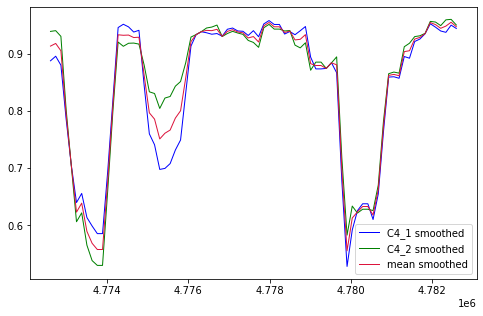

In [1210]:
#Visualise -> effect of averageing -> CG

#SJ file
sj = pd.read_csv('/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/L2-3_IT/SJ.out.tab', 
                 sep='\t', header=None, names=['chromosome', 'SJ_start', 'SJ_end', 'strand', 'NA', 'annotated',
                                                 'n_unq', 'n_mult', 'overhang'])
data_type = 'CG' #atac, cg or cac
path = '/cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/' #path to celldirs
curr_sj = sj.loc[5]
print(curr_sj)
#Data parameters
#=======================================
flank = 5000 #flanking context either side
binsize=128

#Define interval
int_start, int_end = curr_sj['SJ_start'] - flank, curr_sj['SJ_start'] + flank

#Compute interval for smoothed
prac_chr = out_df[out_df['chr'] == curr_sj['chromosome'].split('chr')[-1]]
prac_chr.index = np.arange(0,len(prac_chr))
prac_sub = prac_chr.loc[int_start//128:((int_start//128) + (int_end - int_start)//128)]

#Visualise mc tracks 
import pyBigWig as bw
# Plot CH and CG methylation
fig,ax = plt.subplots(figsize=(8,5))

plt.plot(prac_sub['start'], prac_sub['C4_1_L2-3_IT_CG.bw'], linewidth=1, c='blue', label='C4_1 smoothed')
plt.plot(prac_sub['start'], prac_sub['C4_2_L2-3_IT_CG.bw'], linewidth=1, c='green', label='C4_2 smoothed')
plt.plot(prac_sub['start'], prac_sub['mean_smoothed'], linewidth=1, c='crimson', label='mean smoothed')

plt.legend()

plt.show()

chromosome       chr1
SJ_start      4777649
SJ_end        4782567
strand              2
NA                  2
annotated           1
n_unq           10433
n_mult             89
overhang           25
Name: 5, dtype: object


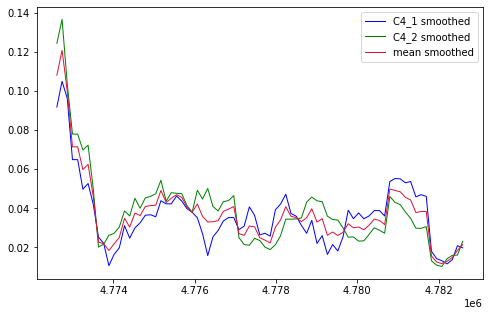

In [1214]:
#Visualise -> effect of averageing -> CH

#SJ file
sj = pd.read_csv('/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/L2-3_IT/SJ.out.tab', 
                 sep='\t', header=None, names=['chromosome', 'SJ_start', 'SJ_end', 'strand', 'NA', 'annotated',
                                                 'n_unq', 'n_mult', 'overhang'])
data_type = 'CAC' #atac, cg or cac
path = '/cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/' #path to celldirs
curr_sj = sj.loc[5]
print(curr_sj)
#Data parameters
#=======================================
flank = 5000 #flanking context either side
binsize=128

#Define interval
int_start, int_end = curr_sj['SJ_start'] - flank, curr_sj['SJ_start'] + flank

#Compute interval for smoothed
prac_chr = out_df[out_df['chr'] == curr_sj['chromosome'].split('chr')[-1]]
prac_chr.index = np.arange(0,len(prac_chr))
prac_sub = prac_chr.loc[int_start//128:((int_start//128) + (int_end - int_start)//128)]

#Visualise mc tracks 
import pyBigWig as bw
# Plot CH and CG methylation
fig,ax = plt.subplots(figsize=(8,5))

plt.plot(prac_sub['start'], prac_sub['C4_1_L2-3_IT_CAC.bw'], linewidth=1, c='blue', label='C4_1 smoothed')
plt.plot(prac_sub['start'], prac_sub['C4_2_L2-3_IT_CAC.bw'], linewidth=1, c='green', label='C4_2 smoothed')
plt.plot(prac_sub['start'], prac_sub['mean_smoothed'], linewidth=1, c='crimson', label='mean smoothed')

plt.legend()

plt.show()

chromosome       chr1
SJ_start      4777649
SJ_end        4782567
strand              2
NA                  2
annotated           1
n_unq           10433
n_mult             89
overhang           25
Name: 5, dtype: object
/cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/L2-3_IT/C4_1_L2-3_IT_CG.bw /cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/L2-3_IT/C4_2_L2-3_IT_CG.bw


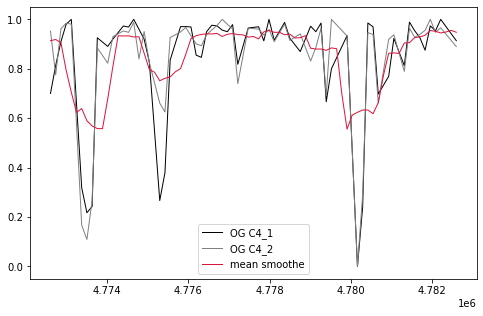

In [1219]:
#Visualise -> effect of mean smootheing -> CG 

#SJ file
sj = pd.read_csv('/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/L2-3_IT/SJ.out.tab', 
                 sep='\t', header=None, names=['chromosome', 'SJ_start', 'SJ_end', 'strand', 'NA', 'annotated',
                                                 'n_unq', 'n_mult', 'overhang'])
data_type = 'CG' #atac, cg or cac
path = '/cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/' #path to celldirs
curr_sj = sj.loc[5]
print(curr_sj)
#Data parameters
#=======================================
flank = 5000 #flanking context either side
binsize=128


cell = name_l[0]
data_l = glob.glob(path + cell + '/*' + data_type + '*')
data1 =data_l[2]
data2 =data_l[3]

print(data1, data2)

#Define interval
int_start, int_end = curr_sj['SJ_start'] - flank, curr_sj['SJ_start'] + flank

curr_bw = bw.open(data1)
bw_int1 = np.asarray(curr_bw.intervals(curr_sj['chromosome'].split('chr')[-1], int_start, int_end))
curr_bw = bw.open(data2)
bw_int2 = np.asarray(curr_bw.intervals(curr_sj['chromosome'].split('chr')[-1], int_start, int_end))


#Compute interval for smoothed
prac_chr = out_df[out_df['chr'] == curr_sj['chromosome'].split('chr')[-1]]
prac_chr.index = np.arange(0,len(prac_chr))
prac_sub = prac_chr.loc[int_start//128:((int_start//128) + (int_end - int_start)//128)]

#Visualise mc tracks 
import pyBigWig as bw
# Plot CH and CG methylation
fig,ax = plt.subplots(figsize=(8,5))
prac = np.asarray(bw_int1)
plt.plot(prac[:,0], prac[:,2], linewidth=1, c='k', label='OG C4_1')
prac = np.asarray(bw_int2)
plt.plot(prac[:,0], prac[:,2], linewidth=1, c='grey', label='OG C4_2')
plt.plot(prac_sub['start'], prac_sub['mean_smoothed'], linewidth=1, c='crimson', label='mean smoothe')

plt.legend()

plt.show()

chromosome       chr1
SJ_start      3421902
SJ_end        3670551
strand              2
NA                  2
annotated           1
n_unq             201
n_mult              8
overhang           25
Name: 2, dtype: object
/cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/L2-3_IT/C4_1_L2-3_IT_CG.bw /cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/L2-3_IT/C4_2_L2-3_IT_CG.bw


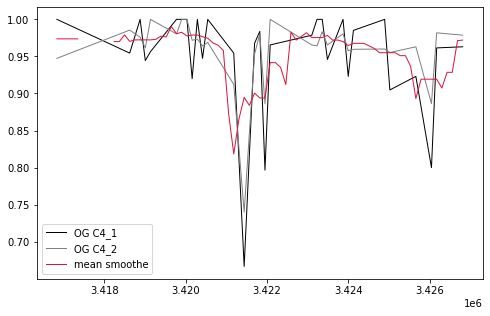

In [1222]:
#Visualise -> effect of mean smootheing -> CG 

#SJ file
sj = pd.read_csv('/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/L2-3_IT/SJ.out.tab', 
                 sep='\t', header=None, names=['chromosome', 'SJ_start', 'SJ_end', 'strand', 'NA', 'annotated',
                                                 'n_unq', 'n_mult', 'overhang'])
data_type = 'CG' #atac, cg or cac
path = '/cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/' #path to celldirs
curr_sj = sj.loc[2]
print(curr_sj)
#Data parameters
#=======================================
flank = 5000 #flanking context either side
binsize=128


cell = name_l[0]
data_l = glob.glob(path + cell + '/*' + data_type + '*')
data1 =data_l[2]
data2 =data_l[3]

print(data1, data2)

#Define interval
int_start, int_end = curr_sj['SJ_start'] - flank, curr_sj['SJ_start'] + flank

curr_bw = bw.open(data1)
bw_int1 = np.asarray(curr_bw.intervals(curr_sj['chromosome'].split('chr')[-1], int_start, int_end))
curr_bw = bw.open(data2)
bw_int2 = np.asarray(curr_bw.intervals(curr_sj['chromosome'].split('chr')[-1], int_start, int_end))


#Compute interval for smoothed
prac_chr = out_df[out_df['chr'] == curr_sj['chromosome'].split('chr')[-1]]
prac_chr.index = np.arange(0,len(prac_chr))
prac_sub = prac_chr.loc[int_start//128:((int_start//128) + (int_end - int_start)//128)]

#Visualise mc tracks 
import pyBigWig as bw
# Plot CH and CG methylation
fig,ax = plt.subplots(figsize=(8,5))
prac = np.asarray(bw_int1)
plt.plot(prac[:,0], prac[:,2], linewidth=1, c='k', label='OG C4_1')
prac = np.asarray(bw_int2)
plt.plot(prac[:,0], prac[:,2], linewidth=1, c='grey', label='OG C4_2')
plt.plot(prac_sub['start'], prac_sub['mean_smoothed'], linewidth=1, c='crimson', label='mean smoothe')

plt.legend()

plt.show()

In [1224]:
 prac_sub['mean_smoothed'].values

array([0.97369999, 0.97369999, 0.97369999, 0.97369999, 0.97369999,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.97      , 0.97      , 0.979     , 0.97031667,
       0.9723    , 0.9723    , 0.9723    , 0.9723    , 0.97306667,
       0.97735   , 0.97622084, 0.9903    , 0.98069168, 0.98255001,
       0.97755667, 0.97885   , 0.97885   , 0.97659   , 0.97456   ,
       0.9682    , 0.96507499, 0.95788333, 0.87371667, 0.81837501,
       0.86571668, 0.894775  , 0.88408   , 0.900525  , 0.89395   ,
       0.89395   , 0.94159999, 0.94159999, 0.93533332, 0.91202499,
       0.98275   , 0.97205001, 0.9771    , 0.98194999, 0.9753875 ,
       0.9753875 , 0.9753875 , 0.97835   , 0.97203333, 0.97208333,
       0.97006999, 0.96467499, 0.96766666, 0.96766666, 0.96766666,
       0.96426665, 0.96078332, 0.955     , 0.955     , 0.955     ,
       0.955     , 0.95101666, 0.95101666, 0.936525  , 0.893125  ,
       0.9193    , 0.9193    , 0.9193    , 0.9193    , 0.90742

chromosome       chr1
SJ_start      4777649
SJ_end        4782567
strand              2
NA                  2
annotated           1
n_unq           10433
n_mult             89
overhang           25
Name: 5, dtype: object
/cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/L2-3_IT/C4_2_L2-3_IT_CAC.bw /cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/L2-3_IT/C4_1_L2-3_IT_CAC.bw


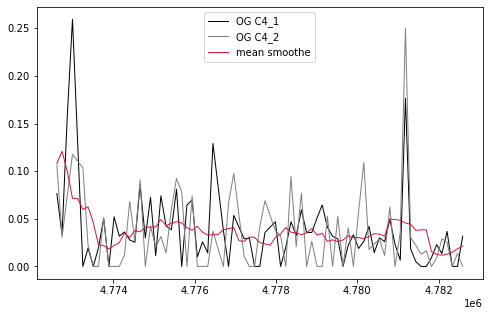

In [1217]:
#Visualise -> effect of mean smootheing -> CAC

#SJ file
sj = pd.read_csv('/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/L2-3_IT/SJ.out.tab', 
                 sep='\t', header=None, names=['chromosome', 'SJ_start', 'SJ_end', 'strand', 'NA', 'annotated',
                                                 'n_unq', 'n_mult', 'overhang'])
data_type = 'CAC' #atac, cg or cac
path = '/cndd2/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/pseudobulk/gran1/' #path to celldirs
curr_sj = sj.loc[5]
print(curr_sj)
#Data parameters
#=======================================
flank = 5000 #flanking context either side
binsize=128


cell = name_l[0]
data_l = glob.glob(path + cell + '/*' + data_type + '*')
data1 =data_l[1]
data2 =data_l[3]

print(data1, data2)

#Define interval
int_start, int_end = curr_sj['SJ_start'] - flank, curr_sj['SJ_start'] + flank

curr_bw = bw.open(data1)
bw_int1 = np.asarray(curr_bw.intervals(curr_sj['chromosome'].split('chr')[-1], int_start, int_end))
curr_bw = bw.open(data2)
bw_int2 = np.asarray(curr_bw.intervals(curr_sj['chromosome'].split('chr')[-1], int_start, int_end))


#Compute interval for smoothed
prac_chr = out_df[out_df['chr'] == curr_sj['chromosome'].split('chr')[-1]]
prac_chr.index = np.arange(0,len(prac_chr))
prac_sub = prac_chr.loc[int_start//128:((int_start//128) + (int_end - int_start)//128)]

#Visualise mc tracks 
import pyBigWig as bw
# Plot CH and CG methylation
fig,ax = plt.subplots(figsize=(8,5))
prac = np.asarray(bw_int1)
plt.plot(prac[:,0], prac[:,2], linewidth=1, c='k', label='OG C4_1')
prac = np.asarray(bw_int2)
plt.plot(prac[:,0], prac[:,2], linewidth=1, c='grey', label='OG C4_2')
plt.plot(prac_sub['start'], prac_sub['mean_smoothed'], linewidth=1, c='crimson', label='mean smoothe')

plt.legend()

plt.show()

In [22]:
#ATAC
# baseline -> merge.bingraph.raw
#============================================

#ATAC -> normalise, smoothe, take average
#============================================

gaba_l = [ 'Vip', 'Pvalb', 'Sst', 'Lamp5']
glu_l = ['L2-3_IT', 'L5_IT', 'L6_IT', 'L6_CT', 'L6b']
name_l = glu_l + gaba_l
data_l = ['ATAC']
#PARS
path = '/cndd2/dburrows/DATA/splice/snatacseq-atac_MOp_biccn/pseudobulk/gran1/'
for cell in name_l[:1]:
    for d in data_l[:1]:
        print(glob.glob(path+cell+'/*'+d+'*merge.bingraph.raw')[0])
        curr = pd.read_csv(glob.glob(path+cell+'/*'+d+'*merge.bingraph.raw')[0], sep='\t', 
                           low_memory=False)
        rmv_quot = [i[1:-1] for i in curr.columns[3:]]
        curr.columns =np.append(['chr', 'start', 'end'],rmv_quot)
        lib_size = np.asarray([curr[i].sum() for i in curr.columns[3:] ]) #library size
        chr_sort = np.append(np.asarray(sorted(np.asarray(sorted(curr['chr'].unique())[:-1]).astype(int))).astype(str),'X')
        out_df = pd.DataFrame() #output for new values
        
        #Smoothe -> centered, sliding window, take mean, ignore nans and impute neighbouring values
        #split by chromosome!
        for ch in chr_sort:
            curr_chr = curr[curr['chr'] == ch]
            temp = curr_chr.copy()
        
            #compute sliding window over each sub-cluster first
            for num,c in enumerate(curr_chr.columns[3:]):
                curr_norm = (curr_chr[c] /(lib_size[num])) * 1e6 #compute CPMs
                temp[c] = curr_norm.rolling(window=window_size, min_periods=min_entries, center=True).mean()
                
            out_df = pd.concat([out_df, temp])
        
        #take mean mc across subclusters -> impute nans by ignoring nans again
        out_df['mean_smoothed'] = np.nanmean(out_df[curr.columns[3:]],axis=1)
        out_df.index = np.arange(0,len(out_df))
        out_df.to_csv(f'{path}{cell}/{cell}_{d}.norm-CPM.smoothe8.bingraph.raw', sep='\t', index=False)

        

/cndd2/dburrows/DATA/splice/snatacseq-atac_MOp_biccn/pseudobulk/gran1/L2-3_IT/L2-3_IT_ATAC.merge.bingraph.raw


chromosome       chr1
SJ_start      4777649
SJ_end        4782567
strand              2
NA                  2
annotated           1
n_unq           10433
n_mult             89
overhang           25
Name: 5, dtype: object


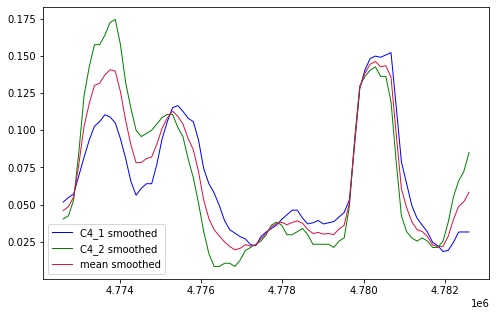

In [24]:
#Visualise -> effect of averageing -> CG

#SJ file
sj = pd.read_csv('/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/L2-3_IT/SJ.out.tab', 
                 sep='\t', header=None, names=['chromosome', 'SJ_start', 'SJ_end', 'strand', 'NA', 'annotated',
                                                 'n_unq', 'n_mult', 'overhang'])
data_type = 'ATAC' #atac, cg or cac
path = '/cndd2/dburrows/DATA/splice/snatacseq-atac_MOp_biccn/pseudobulk/gran1/' #path to celldirs
curr_sj = sj.loc[5]
print(curr_sj)
#Data parameters
#=======================================
flank = 5000 #flanking context either side
binsize=128

#Define interval
int_start, int_end = curr_sj['SJ_start'] - flank, curr_sj['SJ_start'] + flank

#Compute interval for smoothed
prac_chr = out_df[out_df['chr'] == curr_sj['chromosome'].split('chr')[-1]]
prac_chr.index = np.arange(0,len(prac_chr))
prac_sub = prac_chr.loc[int_start//128:((int_start//128) + (int_end - int_start)//128)]

#Visualise mc tracks 
import pyBigWig as bw
# Plot CH and CG methylation
fig,ax = plt.subplots(figsize=(8,5))

plt.plot(prac_sub['start'], prac_sub['C4_1_L2-3_IT_ATAC.bw'], linewidth=1, c='blue', label='C4_1 smoothed')
plt.plot(prac_sub['start'], prac_sub['C4_2_L2-3_IT_ATAC.bw'], linewidth=1, c='green', label='C4_2 smoothed')
plt.plot(prac_sub['start'], prac_sub['mean_smoothed'], linewidth=1, c='crimson', label='mean smoothed')

plt.legend()

plt.show()

chromosome       chr1
SJ_start      4777649
SJ_end        4782567
strand              2
NA                  2
annotated           1
n_unq           10433
n_mult             89
overhang           25
Name: 5, dtype: object
/cndd2/dburrows/DATA/splice/snatacseq-atac_MOp_biccn/pseudobulk/gran1/L2-3_IT/C4_1_L2-3_IT_ATAC.headerissue.bw /cndd2/dburrows/DATA/splice/snatacseq-atac_MOp_biccn/pseudobulk/gran1/L2-3_IT/C4_2_L2-3_IT_ATAC.bw


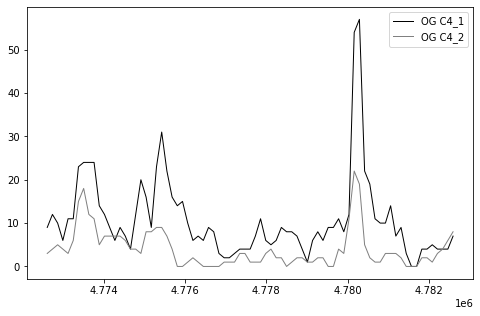

In [30]:
#Visualise -> effect of mean smootheing -> CG 

#SJ file
sj = pd.read_csv('/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/L2-3_IT/SJ.out.tab', 
                 sep='\t', header=None, names=['chromosome', 'SJ_start', 'SJ_end', 'strand', 'NA', 'annotated',
                                                 'n_unq', 'n_mult', 'overhang'])
data_type = 'ATAC' #atac, cg or cac
path = '/cndd2/dburrows/DATA/splice/snatacseq-atac_MOp_biccn/pseudobulk/gran1/' #path to celldirs
curr_sj = sj.loc[5]
print(curr_sj)
#Data parameters
#=======================================
flank = 5000 #flanking context either side
binsize=128


cell = name_l[0]
data_l = glob.glob(path + cell + '/*' + data_type + '*')
data1 =data_l[0]
data2 =data_l[1]

print(data1, data2)

#Define interval
int_start, int_end = curr_sj['SJ_start'] - flank, curr_sj['SJ_start'] + flank

curr_bw = bw.open(data1)
bw_int1 = np.asarray(curr_bw.intervals(curr_sj['chromosome'].split('chr')[-1], int_start, int_end))
curr_bw = bw.open(data2)
bw_int2 = np.asarray(curr_bw.intervals(curr_sj['chromosome'].split('chr')[-1], int_start, int_end))


#Compute interval for smoothed
prac_chr = out_df[out_df['chr'] == curr_sj['chromosome'].split('chr')[-1]]
prac_chr.index = np.arange(0,len(prac_chr))
prac_sub = prac_chr.loc[int_start//128:((int_start//128) + (int_end - int_start)//128)]

#Visualise mc tracks 
import pyBigWig as bw
# Plot CH and CG methylation
fig,ax = plt.subplots(figsize=(8,5))
prac = np.asarray(bw_int1)
plt.plot(prac[:,0], prac[:,2], linewidth=1, c='k', label='OG C4_1')
prac = np.asarray(bw_int2)
plt.plot(prac[:,0], prac[:,2], linewidth=1, c='grey', label='OG C4_2')
plt.legend()

plt.show()

chromosome       chr1
SJ_start      4777649
SJ_end        4782567
strand              2
NA                  2
annotated           1
n_unq           10433
n_mult             89
overhang           25
Name: 5, dtype: object
/cndd2/dburrows/DATA/splice/snatacseq-atac_MOp_biccn/pseudobulk/gran1/L2-3_IT/C4_1_L2-3_IT_ATAC.headerissue.bw /cndd2/dburrows/DATA/splice/snatacseq-atac_MOp_biccn/pseudobulk/gran1/L2-3_IT/C4_2_L2-3_IT_ATAC.bw


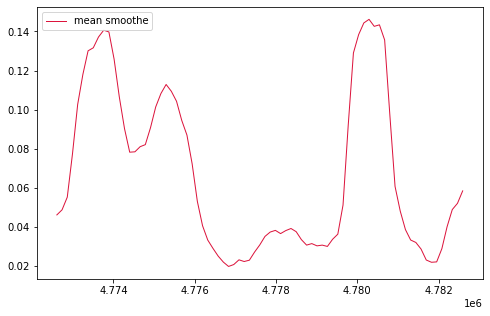

In [31]:
#Visualise -> effect of mean smootheing -> CG 

#SJ file
sj = pd.read_csv('/cndd2/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/gran1/L2-3_IT/SJ.out.tab', 
                 sep='\t', header=None, names=['chromosome', 'SJ_start', 'SJ_end', 'strand', 'NA', 'annotated',
                                                 'n_unq', 'n_mult', 'overhang'])
data_type = 'ATAC' #atac, cg or cac
path = '/cndd2/dburrows/DATA/splice/snatacseq-atac_MOp_biccn/pseudobulk/gran1/' #path to celldirs
curr_sj = sj.loc[5]
print(curr_sj)
#Data parameters
#=======================================
flank = 5000 #flanking context either side
binsize=128


cell = name_l[0]
data_l = glob.glob(path + cell + '/*' + data_type + '*')
data1 =data_l[0]
data2 =data_l[1]

print(data1, data2)

#Define interval
int_start, int_end = curr_sj['SJ_start'] - flank, curr_sj['SJ_start'] + flank

curr_bw = bw.open(data1)
bw_int1 = np.asarray(curr_bw.intervals(curr_sj['chromosome'].split('chr')[-1], int_start, int_end))
curr_bw = bw.open(data2)
bw_int2 = np.asarray(curr_bw.intervals(curr_sj['chromosome'].split('chr')[-1], int_start, int_end))


#Compute interval for smoothed
prac_chr = out_df[out_df['chr'] == curr_sj['chromosome'].split('chr')[-1]]
prac_chr.index = np.arange(0,len(prac_chr))
prac_sub = prac_chr.loc[int_start//128:((int_start//128) + (int_end - int_start)//128)]

#Visualise mc tracks 
import pyBigWig as bw
# Plot CH and CG methylation
fig,ax = plt.subplots(figsize=(8,5))
prac = np.asarray(bw_int1)
plt.plot(prac_sub['start'], prac_sub['mean_smoothed'], linewidth=1, c='crimson', label='mean smoothe')

plt.legend()

plt.show()